# Univariate Model-Based Selection

### Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import gc
import warnings
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, Flatten, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

warnings.filterwarnings("ignore")

Configuration

In [2]:
TARGET_VARIABLES = ['co2', 'gdp', 'primary_energy_consumption']
N_STEPS_IN = 5
N_STEPS_OUT = 1 # Since it is not yet Recursive DL Framework.
VAL_SIZE = 0.15
TEST_SIZE = 0.15
G20_COUNTRIES = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]

### Data Loads

In [3]:
def load_data(save_dir='data_export'):

    selected_features_path = os.path.join(save_dir, '02_results', 'selected_features.pkl')
    lag_path = os.path.join(save_dir, 'lag_df_1965.pkl')

    try:
        with open(selected_features_path, 'rb') as f:
            selected_features = pickle.load(f)
        print(f"Selected features loaded")

        lag_df = pd.read_pickle(lag_path)
        print(f"Time lag dataframe loaded")

        return selected_features, lag_df
    
    except FileNotFoundError as e:
        print(f"Error in loading {e}")
        return None, None

In [4]:
selected_features, lag_df = load_data()

Selected features loaded
Time lag dataframe loaded


### Utility Functions

In [4]:
def clear_memory():
    tf.keras.backend.clear_session()
    gc.collect()

In [12]:
# Root Mean Square Error
def rmse(y_pred, y_actual):
    return np.sqrt(mean_squared_error(y_actual, y_pred))

In [13]:
# Mean Absolute Scaled Error
def mase(y_actual, y_pred, period=1):

    mae_forecast = mean_absolute_error(y_actual, y_pred)
    
    # MAE of naive forecast
    naive_forecast = y_actual[:-period] if period > 0 else y_actual[:-1]
    actual_for_naive = y_actual[period:] if period > 0 else y_actual[1:]
    
    if len(naive_forecast) == 0:
        return np.nan
    
    mae_naive = mean_absolute_error(actual_for_naive, naive_forecast)
    
    if mae_naive == 0:
        return 0 if mae_forecast == 0 else np.inf
    
    return mae_forecast / mae_naive

In [7]:
# Checking stationary for ARIMA model
def check_stationarity(data, alpha=0.05):
    # P_value = result[1]
    result = adfuller(data)
    return result[1] < alpha, result[1]

In [8]:
# Making stationary if not with differencing
def make_stationary(data, max_diff=2):

    diff_order = 0
    curr_data = data.copy()

    for d in range(max_diff + 1):
        is_stationary, p_value = check_stationarity(curr_data)
        if is_stationary:
            return curr_data, d
        if d < max_diff:
            curr_data = np.diff(curr_data)
            diff_order += 1

    return curr_data, diff_order

In [9]:
# Inversing diff for differeced forecasts
def inv_diff(forecast, original_series, d):

    if d == 0:
        return forecast
    
    # Last values for inv diff
    last_values = []
    temp_series = original_series.copy()

    for i in range(d):
        last_values.append(temp_series[-1])
        if i < d - 1:
            temp_series = np.diff(temp_series)

    # Inversing
    result = forecast
    for i in range(d-1, -1, -1):
        result = np.cumsum(np.concatenate([[last_values[i]], result]))
        # Remove last_values[i]
        result = result[1:]

    return result

### Data Prep

In [10]:
# Preparing for data for ARIMA
def prepare_ARIMA_data(country_data, feature, target, n_steps_in=5):
    
    # (curr + lags)
    feature_cols = [feature]
    for i in range(1, n_steps_in):
        lag_col = f"{feature}_lag{i}"
        if lag_col in country_data.columns:
            feature_cols.append(lag_col)
    
    all_cols = feature_cols + [target] + ['year']
    data_subset = country_data[all_cols].dropna()
    
    # (n_samples, n_features)
    X = data_subset[feature_cols].values
    # (n_samples,) -> change into 1D array with ravel()
    y = data_subset[target].values.ravel()
    years = data_subset['year'].values

    print(f"ARIMA shape X:{X.shape}, y:{y.shape}")
    
    # Split for time series
    n_train = int(len(y) * (1 - TEST_SIZE - VAL_SIZE))
    n_val = int(len(y) * VAL_SIZE)
    
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_val = X[n_train:n_train + n_val]
    y_val = y[n_train:n_train + n_val]
    X_test = X[n_train + n_val:]
    y_test = y[n_train + n_val:]

    test_years = years[n_train+n_val:]

    print(f"Test data length: {len(y_test)}, Test years length: {len(test_years)}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test, test_years

In [11]:
# Preparing data for DL models
def prepare_uni_data(country_data, feature, target, n_steps_in=5):
    """
    Filtering out the data with the feature and its lags to predict target
    """

    feature_cols = [feature]
    for i in range(1, n_steps_in):
        lag_col = f"{feature}_lag{i}"
        if lag_col in country_data.columns:
            feature_cols.append(lag_col)
    
    # Subset data
    target_col = target
    all_cols = feature_cols + [target_col] + ['year']
    data_subset = country_data[all_cols].dropna()
    
    feature_data = []
    for col in feature_cols:
        feature_data.append(data_subset[col].values)

    X = np.column_stack(feature_data)
    y = data_subset[target_col].values
    years = data_subset['year'].values
    
    return X, y, years

In [12]:
def create_sequence(X, y, n_steps_out=1):
    """
    With prepared data, it creates n_steps_out number of sequences for multi-step prediction.
    [t-4, t-3, t-2, t-1, t] -> [t+1, t+2, t+3]
    """
    X_seq, y_seq = [], []

    for i in range(len(y) - n_steps_out + 1):
        X_seq.append(X[i])

        y_output = []
        for j in range(1, n_steps_out+1):
            if i+j < len(y):
                y_output.append(y[i+j])

        if len(y_output) == n_steps_out:
            y_seq.append(y_output)
        else:
            # Remove last X when not enough y values
            X_seq.pop()

    return np.array(X_seq), np.array(y_seq)

In [13]:
def prepare_dl_data(X, y, years, n_steps_out=1, val_size=0.15, test_size=0.15):

    # Sequence
    X_seq, y_seq = create_sequence(X, y, n_steps_out)
    years_seq = years[:len(X_seq)]

    # Split data
    n_total = len(X_seq)
    n_train = int(n_total * (1 - test_size - val_size))
    n_val = int(n_total * val_size)

    X_train = X_seq[:n_train]
    y_train = y_seq[:n_train]
    X_val = X_seq[n_train:n_train + n_val]
    y_val = y_seq[n_train:n_train + n_val]
    X_test = X_seq[n_train + n_val:]
    y_test = y_seq[n_train + n_val:]
    test_years = years_seq[n_train + n_val:]

    # StandardScaler is better for future extrapolation wrt time series (2D)
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    X_scaler.fit(X_train)
    y_scaler.fit(y_train)
    
    X_train_scaled = X_scaler.transform(X_train)
    y_train_scaled = y_scaler.transform(y_train)
    X_val_scaled = X_scaler.transform(X_val)
    y_val_scaled = y_scaler.transform(y_val)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Reshape for LSTM (n_samples, timesteps, n_features)
    X_train_dl = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
    X_val_dl = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
    X_test_dl = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

    #print(f"Scaling range Train: {y_train_scaled.min():.4f} - {y_train_scaled.max():.4f}")

    return (X_train_dl, y_train_scaled, X_val_dl, y_val_scaled, X_test_dl, 
            y_test, y_scaler, test_years)

### Model builds

In [14]:
# Tuning ARIMA with AIC criterion
def tune_ARIMA_params(y_train, exog_train=None, max_p=4, max_d=2, max_q=3):
    """
    p (autoregressive order): num of lag obs to include
    d (differencing degree): num of time data different to make it stationary
    q (moving avg order): size of moving avg window
    Lower AIC -> better model fit
    """

    best_aic = np.inf
    best_params = None
    best_model = None

    # Check if it is stationary
    is_stationary, p_value = check_stationarity(y_train)

    if is_stationary:
        d_range = [0]
    else:
        _, d_needed = make_stationary(y_train, max_diff=2)
        print(f"    Not stationary p_value: {p_value:.4f}")
        d_range = [1]

    # Grid search
    for p in range(max_p + 1):
        for d in d_range:
            for q in range(max_q + 1):
                try:
                    model = ARIMA(y_train, exog=exog_train, order=(p, d, q))
                    fitted_model = model.fit()
                    aic = fitted_model.aic

                    if aic < best_aic:
                        best_aic = aic
                        best_params = (p, d, q)
                        best_model = fitted_model
                
                except:
                    continue

    return best_model, best_params, best_aic

In [15]:
# Simple LSTM model
def build_lstm(input_shape, n_steps_out, hidden=16):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(n_steps_out)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [16]:
# Bi-directional LSTM
def build_bilstm(input_shape, n_steps_out, hidden=8):
    model = Sequential([
        Bidirectional(LSTM(hidden, activation='relu', kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.01)),
                      input_shape=input_shape),
        Dense(n_steps_out)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [17]:
# Encoder-Decoder LSTM
def build_edlstm(input_shape, n_steps_out, hidden=8):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        RepeatVector(n_steps_out),
        LSTM(hidden, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [18]:
# CNN model
def build_cnn(input_shape, n_steps_out, filters=32, hidden=8):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.01)),
        Flatten(),
        Dense(hidden, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(n_steps_out)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

### Training Models

In [19]:
# Training univariate ARIMA
def train_ARIMA_uni(X_train, y_train, X_val, y_val, X_test, y_test):

    try:
        # Let target data be 1D
        if len(y_train.shape) > 1:
            y_train = y_train.ravel()
        if len(y_val.shape) > 1:
            y_val = y_val.ravel()
        if len(y_test.shape) > 1:
            y_test = y_test.ravel()

        print(f"    Tuning ARIMA params with AIC")
        fitted_model, best_params, best_aic = tune_ARIMA_params(y_train, exog_train=X_train)

        if fitted_model is None:
            print(f"    Tuning params failed")
            return None, None, None, None
        
        print(f"\n  Best ARIMA:{best_params}, AIC: {best_aic:.2f}")

        # Train again with Train+Val for Test
        y_trainval = np.concatenate([y_train, y_val])
        X_trainval = np.vstack([X_train, X_val])

        test_model = ARIMA(y_trainval, exog=X_trainval, order=best_params)
        fitted_test_model = test_model.fit()

        # For Multi-step ahead forecast
        if len(y_test) > 0 and len(X_test) > 0:
            steps_to_forecast = min(len(y_test), len(X_test))
            preds = fitted_test_model.forecast(steps=steps_to_forecast, exog=X_test[:steps_to_forecast])
    
        else:
            preds = np.array([])

        preds = np.array(preds).ravel()
        actual = y_test[:len(preds)]

        # Metrics
        if len(preds) > 0 and len(actual) > 0:
            rmse_score = rmse(preds, actual)
            mase_score = mase(actual, preds)
        else:
            rmse_score = np.inf
            mase_score = np.inf

        print(f"ARIMA - RMSE:{rmse_score:.4f}, MASE:{mase_score:.4f}")

        del fitted_test_model, test_model, fitted_model
        clear_memory()

        return preds, actual, rmse_score, mase_score
    
    except Exception as e:
        print(f"ARIMA failed {e}")
        return None, None, None, None

In [20]:
# Training DL models
def train_dl_model(model_build, X, y, years, model_name):
    try:
        print(f"Training {model_name}")
        
        # Prepare data for DL
        (X_train_dl, y_train_scaled, X_val_dl, y_val_scaled, X_test_dl, 
         y_test, y_scaler, test_years) = prepare_dl_data(X, y, years, N_STEPS_OUT, VAL_SIZE, TEST_SIZE)
        
        # Build model
        input_shape = (X_train_dl.shape[1], X_train_dl.shape[2])
        model = model_build(input_shape, N_STEPS_OUT)

        # Early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss', patience=20, restore_best_weights=True, min_delta=0.001
        )

        # Set batch_size min as possible for runtime
        batch_size = min(8, len(X_train_dl))

        # Train model
        history = model.fit(
            X_train_dl, y_train_scaled,
            validation_data=(X_val_dl, y_val_scaled),
            epochs=50,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=0
        )

        preds_scaled = model.predict(X_test_dl, verbose=0)
        
        # Handle ED-LSTM 3D output (batch, steps, 1)
        if len(preds_scaled.shape) == 3:
            preds_scaled = preds_scaled.reshape(preds_scaled.shape[0], preds_scaled.shape[1])
        
        # Inverse transform
        preds_all = y_scaler.inverse_transform(preds_scaled)
        
        # Take only first pred from each multi-step forecast
        preds = preds_all[:, 0]
        actual = y_test[:, 0]
        
        # Metrics
        if len(preds) > 0 and len(actual) > 0:
            rmse_score = rmse(preds, actual)
            mase_score = mase(actual, preds)
        else:
            rmse_score = np.inf
            mase_score = np.inf
        
        print(f"{model_name} - RMSE:{rmse_score:.4f}, MASE:{mase_score:.4f}")
        
        del model, history
        clear_memory()
        
        return preds, actual, rmse_score, mase_score, test_years[:len(preds)]     

    except Exception as e:
        print(f"Traninig DL model failed {e}")
        return None, None, None, None, None

### Testing

In [21]:
# Testing univarite models
def test_uni_models(feature, target, lag_df, save_dir='data_export'):
    
    results = defaultdict(list)
    preds_data = {}

    for country in G20_COUNTRIES:
        country_data = lag_df[lag_df['country'] == country].sort_values('year')
        print(f"\nTesting for {country}")

        # Base data
        feature_cols = [feature]
        for i in range(1, N_STEPS_IN):
            lag_col = f"{feature}_lag{i}"
            if lag_col in country_data.columns:
                feature_cols.append(lag_col)
        
        all_cols = feature_cols + [target] + ['year']
        data_subset = country_data[all_cols].dropna()

        # Get years for plotting
        years = data_subset['year'].values

        # Data prep for ARIMA
        print(f"Training ARIMA")
        ARIMA_data = prepare_ARIMA_data(country_data, feature, target, N_STEPS_IN)
        
        X_train_ar, y_train_ar, X_val_ar, y_val_ar, X_test_ar, y_test_ar, test_years_ar = ARIMA_data

        # Test ARIMA
        preds, actual, rmse_score, mase_score = train_ARIMA_uni(
            X_train_ar, y_train_ar, X_val_ar, y_val_ar, X_test_ar, y_test_ar
            )
        
        if preds is not None:
            results['ARIMA'].append({
                'country': country,
                'rmse': rmse_score,
                'mase': mase_score
            })

            min_len = min(len(preds), len(actual), len(test_years_ar))
            preds_data[(country, 'ARIMA')] = {
                'predictions': preds[:min_len],
                'actuals': actual[:min_len],
                'years': test_years_ar[:min_len]
            }

        # Data prep for DL models
        X = data_subset[feature_cols].values
        y = data_subset[target].values

        model_configs = [
            ('LSTM', build_lstm),
            ('Bi-LSTM', build_bilstm),
            ('ED-LSTM', build_edlstm),
            ('CNN', build_cnn)
        ]

        for model_name, model_build in model_configs:
            result = train_dl_model(model_build, X, y, years, model_name)
            
            if result[0] is not None:
                preds, actual, rmse_score, mase_score, test_years_dl = result
                
                results[model_name].append({
                    'country': country,
                    'rmse': rmse_score,
                    'mase': mase_score
                })

                preds_data[(country, model_name)] = {
                    'predictions': preds,
                    'actuals': actual,
                    'years': test_years_dl
                }

    return results, preds_data

In [22]:
def summary_result(all_results, save_dir='data_export'):

    summary_dir = os.path.join(save_dir, '02_results')
    if not os.path.exists(summary_dir):
        os.makedirs(summary_dir)

    summary_data = []

    for (feature, target), model_results in all_results.items():
        for model_name, results_list in model_results.items():
            rmse_values = [r['rmse'] for r in results_list]
            mase_values = [r['rmse'] for r in results_list]

            summary_data.append({
                'feature': feature,
                'target': target,
                'model': model_name,
                'n_countries': len(results_list),
                'avg_rmse': np.mean(rmse_values),
                'std_rmse': np.std(rmse_values),
                'min_rmse': np.min(rmse_values),
                'max_rmse': np.max(rmse_values),
                'avg_mase': np.mean(mase_values),
                'std_mase': np.std(mase_values),
                'min_mase': np.min(mase_values),
                'max_mase': np.max(mase_values)
            })

    summary_df = pd.DataFrame(summary_data)

    summary_df.to_csv(os.path.join(summary_dir, 'uni_model_summary.csv'), index=False)

    feature_rank = {}

    for target in TARGET_VARIABLES:
        target_df = summary_df[summary_df['target'] == target]

        feature_scores = target_df.groupby('feature')['avg_rmse'].mean().sort_values()
            
        feature_rank[target] = {
            'rankings': feature_scores.to_dict(),
            'ranked_features': feature_scores.index.tolist()
        }
        print(f"\nFeature Ranking for {target} (by average RMSE):")
        for i, (feature, score) in enumerate(feature_scores.items(), 1):
            print(f" {i}. {feature}: {score:.4f}")

    with open(os.path.join(summary_dir, 'univariate_feature_ranking.pkl'), 'wb') as f:
        pickle.dump(feature_rank, f)
    
    return summary_df, feature_rank

In [ ]:
all_results = {}
all_preds_data = {}
target = 'co2'

for feature in tqdm(selected_features):
    if feature == target:
        continue

    print(f"Testing for feature: {feature}")

    results, preds_data = test_uni_models(feature, target, lag_df)

    if results:
        all_results[(feature, target)] = results
        for key, value in preds_data.items():
            all_preds_data[(feature, target, key[0], key[1])] = value

        # Results summary
        print(f"\nResults for {feature} to {target}")
        for model, model_results in results.items():
            if model_results:
                avg_rmse = np.mean([r['rmse'] for r in model_results])
                avg_mase = np.mean([r['mase'] for r in model_results])
                print(f"\n{model}: {len(model_results)} countries, avg RMSE: {avg_rmse:.4f}, avg MASE: {avg_mase:.4f}")

# Save all results
results_dir = os.path.join('data_export', '02_results')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

with open(os.path.join(results_dir, f'{target}_univariate_predictions.pkl'), 'wb') as f:
    pickle.dump(all_preds_data, f)
print(f"All predictions saved to single file")

co2_summary_df, co2_feature_rank = summary_result(all_results)

  0%|          | 0/21 [00:00<?, ?it/s]

Testing for feature: electricity_generation

Testing for United States
Training ARIMA
ARIMA shape X:(35, 5), y:(35,)
Test data length: 6, Test years length: 6
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.9894

  Best ARIMA:(3, 1, 2), AIC: 291.68
ARIMA - RMSE:198.0702, MASE:0.7647

Training LSTM
LSTM - RMSE:603.4701, MASE:2.3720
Training Bi-LSTM
Bi-LSTM - RMSE:646.9604, MASE:2.5637
Training ED-LSTM
ED-LSTM - RMSE:592.9695, MASE:2.3243
Training CNN
CNN - RMSE:593.8387, MASE:2.3312

Testing for China
Training ARIMA
ARIMA shape X:(35, 5), y:(35,)
Test data length: 6, Test years length: 6
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.9890

  Best ARIMA:(0, 1, 1), AIC: 297.06
ARIMA - RMSE:1446.4328, MASE:3.8501
Training LSTM
LSTM - RMSE:1700.3673, MASE:5.0173
Training Bi-LSTM
Bi-LSTM - RMSE:3437.0344, MASE:9.9032
Training ED-LSTM
ED-LSTM - RMSE:5805.3019, MASE:17.1381
Training CNN
CNN - RMSE:533.9608, MASE:1.4797

Testing for Japan
Training ARIMA
ARIMA shap

  5%|▍         | 1/21 [28:09<9:23:13, 1689.69s/it]


Results for electricity_generation to co2

ARIMA: 19 countries, avg RMSE: 133.3861, avg MASE: 1.7073

LSTM: 19 countries, avg RMSE: 214.5092, avg MASE: 3.3994

Bi-LSTM: 19 countries, avg RMSE: 340.0546, avg MASE: 3.6976

ED-LSTM: 19 countries, avg RMSE: 438.8752, avg MASE: 4.6028

CNN: 19 countries, avg RMSE: 126.5099, avg MASE: 2.7243
Testing for feature: oil_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8736

  Best ARIMA:(0, 1, 3), AIC: 434.97
ARIMA - RMSE:518.7587, MASE:2.5754
Training LSTM
LSTM - RMSE:254.0755, MASE:1.0993
Training Bi-LSTM
Bi-LSTM - RMSE:285.0589, MASE:1.0831
Training ED-LSTM
ED-LSTM - RMSE:257.8774, MASE:1.1183
Training CNN
CNN - RMSE:423.8124, MASE:1.7963

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value:

 10%|▉         | 2/21 [57:10<9:04:30, 1719.51s/it]


Results for oil_consumption to co2

ARIMA: 19 countries, avg RMSE: 166.7768, avg MASE: 2.2706

LSTM: 19 countries, avg RMSE: 399.2925, avg MASE: 7.5563

Bi-LSTM: 19 countries, avg RMSE: 181.8767, avg MASE: 4.0726

ED-LSTM: 19 countries, avg RMSE: 332.7541, avg MASE: 7.0160

CNN: 19 countries, avg RMSE: 290.0109, avg MASE: 5.8649
Testing for feature: energy_cons_change_pct

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8281

  Best ARIMA:(1, 1, 0), AIC: 401.45
ARIMA - RMSE:279.1175, MASE:1.2973
Training LSTM
LSTM - RMSE:288.7957, MASE:1.3414
Training Bi-LSTM
Bi-LSTM - RMSE:278.7689, MASE:1.2811
Training ED-LSTM
ED-LSTM - RMSE:256.0464, MASE:1.1777
Training CNN
CNN - RMSE:289.9548, MASE:1.3749

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value:

 14%|█▍        | 3/21 [1:20:58<7:55:58, 1586.58s/it]


Results for energy_cons_change_pct to co2

ARIMA: 19 countries, avg RMSE: 133.9089, avg MASE: 2.6320

LSTM: 19 countries, avg RMSE: 657.6254, avg MASE: 9.0437

Bi-LSTM: 19 countries, avg RMSE: 665.8679, avg MASE: 8.9657

ED-LSTM: 19 countries, avg RMSE: 666.7233, avg MASE: 9.8244

CNN: 19 countries, avg RMSE: 657.2375, avg MASE: 9.3188
Testing for feature: oil_cons_change_pct

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8281

  Best ARIMA:(1, 1, 1), AIC: 434.50
ARIMA - RMSE:222.1158, MASE:1.0923
Training LSTM
LSTM - RMSE:286.9174, MASE:1.3086
Training Bi-LSTM
Bi-LSTM - RMSE:273.1946, MASE:1.2606
Training ED-LSTM
ED-LSTM - RMSE:259.2597, MASE:1.1951
Training CNN
CNN - RMSE:304.0347, MASE:1.4017

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_va

 19%|█▉        | 4/21 [1:40:25<6:42:38, 1421.07s/it]


Results for oil_cons_change_pct to co2

ARIMA: 19 countries, avg RMSE: 173.6298, avg MASE: 2.7723

LSTM: 19 countries, avg RMSE: 672.1827, avg MASE: 10.0316

Bi-LSTM: 19 countries, avg RMSE: 679.9916, avg MASE: 10.4047

ED-LSTM: 19 countries, avg RMSE: 674.0102, avg MASE: 10.5828

CNN: 19 countries, avg RMSE: 644.9921, avg MASE: 9.8655
Testing for feature: renewables_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8736

  Best ARIMA:(0, 1, 1), AIC: 477.46
ARIMA - RMSE:253.4665, MASE:1.0459
Training LSTM
LSTM - RMSE:2210.8513, MASE:10.4857
Training Bi-LSTM
Bi-LSTM - RMSE:292.7695, MASE:1.4762
Training ED-LSTM
ED-LSTM - RMSE:288.4100, MASE:1.0813
Training CNN
CNN - RMSE:1471.6966, MASE:7.1188

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationar

 24%|██▍       | 5/21 [1:57:34<5:41:11, 1279.47s/it]


Results for renewables_consumption to co2

ARIMA: 19 countries, avg RMSE: 903.4792, avg MASE: 21.3396

LSTM: 19 countries, avg RMSE: 1927.5978, avg MASE: 21.1131

Bi-LSTM: 19 countries, avg RMSE: 1071.4864, avg MASE: 17.7087

ED-LSTM: 19 countries, avg RMSE: 470.5186, avg MASE: 11.2290

CNN: 19 countries, avg RMSE: 865.3632, avg MASE: 15.3513
Testing for feature: wind_cons_change_twh

Testing for United States
Training ARIMA
ARIMA shape X:(36, 5), y:(36,)
Test data length: 6, Test years length: 6
    Tuning ARIMA params with AIC

  Best ARIMA:(2, 0, 2), AIC: 317.84
ARIMA - RMSE:530.7352, MASE:1.9609
Training LSTM
LSTM - RMSE:830.3711, MASE:3.3628
Training Bi-LSTM
Bi-LSTM - RMSE:374.4695, MASE:1.1745
Training ED-LSTM
ED-LSTM - RMSE:446.7054, MASE:1.5649
Training CNN
CNN - RMSE:744.1589, MASE:2.5414

Testing for China
Training ARIMA
ARIMA shape X:(48, 5), y:(48,)
Test data length: 8, Test years length: 8
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.9954

  Best ARIMA:(

 29%|██▊       | 6/21 [2:16:31<5:07:44, 1230.98s/it]


Results for wind_cons_change_twh to co2

ARIMA: 19 countries, avg RMSE: 693.1727, avg MASE: 14.8897

LSTM: 19 countries, avg RMSE: 3826.7676, avg MASE: 155.0971

Bi-LSTM: 19 countries, avg RMSE: 1485.5193, avg MASE: 25.6121

ED-LSTM: 19 countries, avg RMSE: 1960.1916, avg MASE: 74.3694

CNN: 19 countries, avg RMSE: 3758.0507, avg MASE: 162.1296
Testing for feature: hydro_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8736

  Best ARIMA:(0, 1, 1), AIC: 477.48
ARIMA - RMSE:449.3969, MASE:2.0746
Training LSTM
LSTM - RMSE:263.6570, MASE:1.2384
Training Bi-LSTM
Bi-LSTM - RMSE:294.2629, MASE:1.4224
Training ED-LSTM
ED-LSTM - RMSE:259.1873, MASE:1.1952
Training CNN
CNN - RMSE:240.8404, MASE:1.0590

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationa

 33%|███▎      | 7/21 [2:38:01<4:51:45, 1250.41s/it]


Results for hydro_consumption to co2

ARIMA: 19 countries, avg RMSE: 166.8765, avg MASE: 2.4302

LSTM: 19 countries, avg RMSE: 336.3639, avg MASE: 6.9857

Bi-LSTM: 19 countries, avg RMSE: 342.5988, avg MASE: 6.7428

ED-LSTM: 19 countries, avg RMSE: 481.9581, avg MASE: 8.4780

CNN: 19 countries, avg RMSE: 363.2387, avg MASE: 6.9136
Testing for feature: gas_prod_change_twh

Testing for United States
Training ARIMA
ARIMA shape X:(59, 5), y:(59,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.5074

  Best ARIMA:(2, 1, 3), AIC: 509.69
ARIMA - RMSE:350.2880, MASE:1.5983
Training LSTM
LSTM - RMSE:365.8200, MASE:1.7915
Training Bi-LSTM
Bi-LSTM - RMSE:469.5607, MASE:1.7568
Training ED-LSTM
ED-LSTM - RMSE:378.9212, MASE:1.8538
Training CNN
CNN - RMSE:475.7647, MASE:2.3987

Testing for China
Training ARIMA
ARIMA shape X:(59, 5), y:(59,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params with AIC
    Not stationary p_val

 38%|███▊      | 8/21 [3:01:38<4:42:23, 1303.36s/it]


Results for gas_prod_change_twh to co2

ARIMA: 19 countries, avg RMSE: 110.2828, avg MASE: 2.2948

LSTM: 19 countries, avg RMSE: 698.5176, avg MASE: 20.8755

Bi-LSTM: 19 countries, avg RMSE: 474.6955, avg MASE: 16.7027

ED-LSTM: 19 countries, avg RMSE: 622.3693, avg MASE: 11.6622

CNN: 19 countries, avg RMSE: 457.0785, avg MASE: 11.7610
Testing for feature: energy_per_capita

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8736

  Best ARIMA:(1, 1, 1), AIC: 397.37
ARIMA - RMSE:330.8597, MASE:1.5662
Training LSTM
LSTM - RMSE:251.0316, MASE:1.0641
Training Bi-LSTM
Bi-LSTM - RMSE:335.9777, MASE:1.6475
Training ED-LSTM
ED-LSTM - RMSE:267.2422, MASE:1.2550
Training CNN
CNN - RMSE:263.9773, MASE:1.2257

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_val

 43%|████▎     | 9/21 [3:27:40<4:36:50, 1384.18s/it]


Results for energy_per_capita to co2

ARIMA: 19 countries, avg RMSE: 113.3271, avg MASE: 1.6532

LSTM: 19 countries, avg RMSE: 336.8003, avg MASE: 5.9173

Bi-LSTM: 19 countries, avg RMSE: 366.3472, avg MASE: 4.8846

ED-LSTM: 19 countries, avg RMSE: 372.2487, avg MASE: 7.0150

CNN: 19 countries, avg RMSE: 543.8125, avg MASE: 4.8558
Testing for feature: coal_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8736

  Best ARIMA:(0, 1, 2), AIC: 448.31
ARIMA - RMSE:358.0786, MASE:1.7974
Training LSTM
LSTM - RMSE:193.7074, MASE:0.8169
Training Bi-LSTM
Bi-LSTM - RMSE:177.2093, MASE:0.7259
Training ED-LSTM
ED-LSTM - RMSE:220.6963, MASE:1.0209
Training CNN
CNN - RMSE:140.7011, MASE:0.4683

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.9

 48%|████▊     | 10/21 [3:56:05<4:31:58, 1483.46s/it]


Results for coal_consumption to co2

ARIMA: 19 countries, avg RMSE: 99.9631, avg MASE: 2.1740

LSTM: 19 countries, avg RMSE: 468.9128, avg MASE: 8.7717

Bi-LSTM: 19 countries, avg RMSE: 178.3601, avg MASE: 4.8805

ED-LSTM: 19 countries, avg RMSE: 276.8184, avg MASE: 6.4394

CNN: 19 countries, avg RMSE: 209.5353, avg MASE: 5.6360
Testing for feature: renewables_cons_change_twh

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8281

  Best ARIMA:(0, 1, 1), AIC: 460.71
ARIMA - RMSE:413.5681, MASE:1.9493
Training LSTM
LSTM - RMSE:240.1297, MASE:1.0738
Training Bi-LSTM
Bi-LSTM - RMSE:234.8313, MASE:1.0096
Training ED-LSTM
ED-LSTM - RMSE:259.5791, MASE:1.2000
Training CNN
CNN - RMSE:243.8858, MASE:1.1108

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_va

 52%|█████▏    | 11/21 [4:27:02<4:26:16, 1597.61s/it]


Results for renewables_cons_change_twh to co2

ARIMA: 19 countries, avg RMSE: 517.0852, avg MASE: 9.1631

LSTM: 19 countries, avg RMSE: 836.3852, avg MASE: 14.5327

Bi-LSTM: 19 countries, avg RMSE: 696.1667, avg MASE: 10.3203

ED-LSTM: 19 countries, avg RMSE: 625.3674, avg MASE: 9.8216

CNN: 19 countries, avg RMSE: 558.5145, avg MASE: 9.4909
Testing for feature: low_carbon_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8736

  Best ARIMA:(0, 1, 1), AIC: 474.50
ARIMA - RMSE:678.3683, MASE:3.1820
Training LSTM
LSTM - RMSE:637.9390, MASE:2.9181
Training Bi-LSTM
Bi-LSTM - RMSE:442.8565, MASE:1.7742
Training ED-LSTM
ED-LSTM - RMSE:330.1088, MASE:1.2624
Training CNN
CNN - RMSE:681.8762, MASE:3.2098

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not statio

 57%|█████▋    | 12/21 [5:00:10<4:17:28, 1716.45s/it]


Results for low_carbon_consumption to co2

ARIMA: 19 countries, avg RMSE: 1070.0734, avg MASE: 22.0013

LSTM: 19 countries, avg RMSE: 703.8844, avg MASE: 9.2744

Bi-LSTM: 19 countries, avg RMSE: 1237.1400, avg MASE: 15.9208

ED-LSTM: 19 countries, avg RMSE: 493.7137, avg MASE: 6.6556

CNN: 19 countries, avg RMSE: 740.3349, avg MASE: 8.2839
Testing for feature: other_renewables_cons_change_twh

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8281

  Best ARIMA:(0, 1, 1), AIC: 458.32
ARIMA - RMSE:312.3578, MASE:1.2616
Training LSTM
LSTM - RMSE:430.1154, MASE:1.7064
Training Bi-LSTM
Bi-LSTM - RMSE:374.4122, MASE:1.4594
Training ED-LSTM
ED-LSTM - RMSE:288.1031, MASE:1.2933
Training CNN
CNN - RMSE:319.7681, MASE:1.4115

Testing for China
Training ARIMA
ARIMA shape X:(48, 5), y:(48,)
Test data length: 8, Test years length: 8
    Tuning ARIMA params with AIC
    No

 62%|██████▏   | 13/21 [5:34:50<4:03:32, 1826.52s/it]


Results for other_renewables_cons_change_twh to co2

ARIMA: 19 countries, avg RMSE: 185.1739, avg MASE: 2.5479

LSTM: 19 countries, avg RMSE: 2511.6008, avg MASE: 22.5408

Bi-LSTM: 19 countries, avg RMSE: 969.2018, avg MASE: 22.3923

ED-LSTM: 19 countries, avg RMSE: 616.3052, avg MASE: 10.5781

CNN: 19 countries, avg RMSE: 513.8827, avg MASE: 13.7121
Testing for feature: co2_per_unit_energy

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8736

  Best ARIMA:(1, 1, 0), AIC: 471.96
ARIMA - RMSE:128.1134, MASE:0.5438
Training LSTM
LSTM - RMSE:2860.2097, MASE:12.1098
Training Bi-LSTM
Bi-LSTM - RMSE:404.6185, MASE:1.8211
Training ED-LSTM
ED-LSTM - RMSE:242.4554, MASE:1.0353
Training CNN
CNN - RMSE:1717.8708, MASE:8.1885

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    N

 67%|██████▋   | 14/21 [6:12:15<3:47:51, 1953.00s/it]


Results for co2_per_unit_energy to co2

ARIMA: 19 countries, avg RMSE: 102.1926, avg MASE: 2.2136

LSTM: 19 countries, avg RMSE: 485.2330, avg MASE: 8.4433

Bi-LSTM: 19 countries, avg RMSE: 458.5414, avg MASE: 8.0866

ED-LSTM: 19 countries, avg RMSE: 467.2450, avg MASE: 9.3387

CNN: 19 countries, avg RMSE: 386.7320, avg MASE: 7.3570
Testing for feature: fossil_fuel_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8736

  Best ARIMA:(0, 1, 2), AIC: 357.81
ARIMA - RMSE:258.4976, MASE:1.2589
Training LSTM
LSTM - RMSE:242.9987, MASE:0.9380
Training Bi-LSTM
Bi-LSTM - RMSE:253.0754, MASE:0.9651
Training ED-LSTM
ED-LSTM - RMSE:236.9887, MASE:0.9711
Training CNN
CNN - RMSE:501.0391, MASE:2.3017

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_v

 71%|███████▏  | 15/21 [6:51:36<3:27:36, 2076.09s/it]


Results for fossil_fuel_consumption to co2

ARIMA: 19 countries, avg RMSE: 78.2002, avg MASE: 1.1060

LSTM: 19 countries, avg RMSE: 516.9214, avg MASE: 5.7712

Bi-LSTM: 19 countries, avg RMSE: 346.0328, avg MASE: 4.5593

ED-LSTM: 19 countries, avg RMSE: 178.1863, avg MASE: 4.4910

CNN: 19 countries, avg RMSE: 204.7242, avg MASE: 3.3166
Testing for feature: nuclear_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8736

  Best ARIMA:(0, 1, 1), AIC: 473.04
ARIMA - RMSE:409.6315, MASE:1.9138
Training LSTM
LSTM - RMSE:329.0822, MASE:1.2930
Training Bi-LSTM
Bi-LSTM - RMSE:359.9337, MASE:1.4784
Training ED-LSTM
ED-LSTM - RMSE:233.5637, MASE:0.8966
Training CNN
CNN - RMSE:609.0116, MASE:2.9914

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_va

 76%|███████▌  | 16/21 [7:32:58<3:03:10, 2198.17s/it]


Results for nuclear_consumption to co2

ARIMA: 19 countries, avg RMSE: 198.8765, avg MASE: 2.8894

LSTM: 19 countries, avg RMSE: 1293.2515, avg MASE: 10.6687

Bi-LSTM: 19 countries, avg RMSE: 515.7020, avg MASE: 7.9174

ED-LSTM: 19 countries, avg RMSE: 614.7353, avg MASE: 9.7451

CNN: 19 countries, avg RMSE: 338.4439, avg MASE: 7.2809
Testing for feature: co2_growth_prct

Testing for United States
Training ARIMA
ARIMA shape X:(59, 5), y:(59,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.5074

  Best ARIMA:(1, 1, 2), AIC: 400.81
ARIMA - RMSE:74.9821, MASE:0.3452
Training LSTM
LSTM - RMSE:322.4599, MASE:1.4518
Training Bi-LSTM
Bi-LSTM - RMSE:394.7466, MASE:1.8855
Training ED-LSTM
ED-LSTM - RMSE:295.0308, MASE:1.3956
Training CNN
CNN - RMSE:277.1980, MASE:1.2006

Testing for China
Training ARIMA
ARIMA shape X:(59, 5), y:(59,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params with AIC
    Not stationary p_valu

 81%|████████  | 17/21 [8:17:07<2:35:34, 2333.57s/it]


Results for co2_growth_prct to co2

ARIMA: 19 countries, avg RMSE: 94.2408, avg MASE: 2.1781

LSTM: 19 countries, avg RMSE: 695.4420, avg MASE: 9.3313

Bi-LSTM: 19 countries, avg RMSE: 700.5077, avg MASE: 9.7682

ED-LSTM: 19 countries, avg RMSE: 720.7456, avg MASE: 11.7134

CNN: 19 countries, avg RMSE: 698.6879, avg MASE: 9.6642
Testing for feature: gas_cons_change_pct

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8281

  Best ARIMA:(1, 1, 0), AIC: 443.23
ARIMA - RMSE:492.6232, MASE:2.4009
Training LSTM
LSTM - RMSE:260.4621, MASE:1.1949
Training Bi-LSTM
Bi-LSTM - RMSE:253.4952, MASE:1.1555
Training ED-LSTM
ED-LSTM - RMSE:254.1655, MASE:1.1606
Training CNN
CNN - RMSE:257.8468, MASE:1.2043

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.

 86%|████████▌ | 18/21 [9:03:22<2:03:19, 2466.39s/it]


Results for gas_cons_change_pct to co2

ARIMA: 19 countries, avg RMSE: 197.2082, avg MASE: 2.6124

LSTM: 19 countries, avg RMSE: 618.5383, avg MASE: 8.6156

Bi-LSTM: 19 countries, avg RMSE: 642.9540, avg MASE: 9.1280

ED-LSTM: 19 countries, avg RMSE: 653.1969, avg MASE: 9.6804

CNN: 19 countries, avg RMSE: 635.5785, avg MASE: 8.9055
Testing for feature: gas_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8736

  Best ARIMA:(1, 1, 1), AIC: 455.39
ARIMA - RMSE:762.4830, MASE:3.6182
Training LSTM
LSTM - RMSE:2403.6034, MASE:11.0305
Training Bi-LSTM
Bi-LSTM - RMSE:299.9022, MASE:1.1797
Training ED-LSTM
ED-LSTM - RMSE:599.4041, MASE:2.5597
Training CNN
CNN - RMSE:975.6091, MASE:4.5374

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 

 90%|█████████ | 19/21 [9:51:31<1:26:26, 2593.12s/it]


Results for gas_consumption to co2

ARIMA: 19 countries, avg RMSE: 214.1259, avg MASE: 2.8687

LSTM: 19 countries, avg RMSE: 369.5669, avg MASE: 6.8259

Bi-LSTM: 19 countries, avg RMSE: 782.8732, avg MASE: 6.4591

ED-LSTM: 19 countries, avg RMSE: 330.7413, avg MASE: 5.0587

CNN: 19 countries, avg RMSE: 897.1749, avg MASE: 8.6933
Testing for feature: energy_per_gdp

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8329

  Best ARIMA:(2, 1, 2), AIC: 456.96
ARIMA - RMSE:304.6919, MASE:1.2680
Training LSTM
LSTM - RMSE:502.0031, MASE:2.5791
Training Bi-LSTM
Bi-LSTM - RMSE:429.9918, MASE:2.0892
Training ED-LSTM
ED-LSTM - RMSE:282.0945, MASE:1.1155
Training CNN
CNN - RMSE:688.0078, MASE:3.8268

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.9991


 95%|█████████▌| 20/21 [10:41:54<45:22, 2722.43s/it] 


Results for energy_per_gdp to co2

ARIMA: 19 countries, avg RMSE: 91.5567, avg MASE: 2.0079

LSTM: 19 countries, avg RMSE: 707.4474, avg MASE: 12.2196

Bi-LSTM: 19 countries, avg RMSE: 691.8693, avg MASE: 13.0409

ED-LSTM: 19 countries, avg RMSE: 682.8813, avg MASE: 12.4230

CNN: 19 countries, avg RMSE: 709.6024, avg MASE: 12.7482
Testing for feature: population

Testing for United States
Training ARIMA
ARIMA shape X:(59, 5), y:(59,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.5074

  Best ARIMA:(1, 1, 0), AIC: 501.82
ARIMA - RMSE:923.5988, MASE:4.0181
Training LSTM
LSTM - RMSE:676.7360, MASE:3.0504
Training Bi-LSTM
Bi-LSTM - RMSE:519.3137, MASE:2.1454
Training ED-LSTM
ED-LSTM - RMSE:366.3237, MASE:1.4654
Training CNN
CNN - RMSE:786.0012, MASE:3.8288

Testing for China
Training ARIMA
ARIMA shape X:(59, 5), y:(59,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.000

100%|██████████| 21/21 [11:34:38<00:00, 1984.68s/it]


Results for population to co2

ARIMA: 19 countries, avg RMSE: 146.1398, avg MASE: 3.0689

LSTM: 19 countries, avg RMSE: 344.9429, avg MASE: 5.6610

Bi-LSTM: 19 countries, avg RMSE: 341.4722, avg MASE: 3.8913

ED-LSTM: 19 countries, avg RMSE: 308.8327, avg MASE: 6.2331

CNN: 19 countries, avg RMSE: 442.5368, avg MASE: 5.5545
All predictions saved to single file



Feature Ranking for co2 (by average RMSE):
 1. coal_consumption: 246.7179
 2. electricity_generation: 250.6670
 3. fossil_fuel_consumption: 264.8130
 4. oil_consumption: 274.1422
 5. population: 316.7849
 6. hydro_consumption: 338.2072
 7. energy_per_capita: 346.5072
 8. co2_per_unit_energy: 379.9888
 9. gas_prod_change_twh: 472.5887
 10. gas_consumption: 518.8964
 11. gas_cons_change_pct: 549.4952
 12. energy_cons_change_pct: 556.2726
 13. oil_cons_change_pct: 568.9613
 14. energy_per_gdp: 576.6714
 15. co2_growth_prct: 581.9248
 16. nuclear_consumption: 592.2019
 17. renewables_cons_change_twh: 646.7038
 18. low_carbon_consumption: 849.0293
 19. other_renewables_cons_change_twh: 959.2329
 20. renewables_consumption: 1047.6890
 21. wind_cons_change_twh: 2344.7404

Feature Ranking for gdp (by average RMSE):

Feature Ranking for primary_energy_consumption (by average RMSE):


In [24]:
all_results = {}
all_preds_data = {}
target = 'gdp'

for feature in tqdm(selected_features):
    if feature == target:
        continue

    print(f"Testing for feature: {feature}")

    results, preds_data = test_uni_models(feature, target, lag_df)

    if results:
        all_results[(feature, target)] = results
        for key, value in preds_data.items():
            all_preds_data[(feature, target, key[0], key[1])] = value

        # Results summary
        print(f"\nResults for {feature} to {target}")
        for model, model_results in results.items():
            if model_results:
                avg_rmse = np.mean([r['rmse'] for r in model_results])
                avg_mase = np.mean([r['mase'] for r in model_results])
                print(f"\n{model}: {len(model_results)} countries, avg RMSE: {avg_rmse:.4f}, avg MASE: {avg_mase:.4f}")

# Save all results
results_dir = os.path.join('data_export', '02_results')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

with open(os.path.join(results_dir, f'{target}_univariate_predictions.pkl'), 'wb') as f:
    pickle.dump(all_preds_data, f)
print(f"All predictions saved to single file")

gdp_summary_df, gdp_feature_rank = summary_result(all_results)

  0%|          | 0/21 [00:00<?, ?it/s]

Testing for feature: electricity_generation

Testing for United States
Training ARIMA
ARIMA shape X:(34, 5), y:(34,)
Test data length: 6, Test years length: 6
    Tuning ARIMA params with AIC

  Best ARIMA:(2, 0, 1), AIC: 1293.04
ARIMA - RMSE:1453856343037.8840, MASE:2.2589

Training LSTM
LSTM - RMSE:2169343028945.2715, MASE:5.0042
Training Bi-LSTM
Bi-LSTM - RMSE:2186593930095.6909, MASE:5.0324
Training ED-LSTM
ED-LSTM - RMSE:3843837888426.6533, MASE:9.0029
Training CNN
CNN - RMSE:2382124554451.4019, MASE:5.5125

Testing for China
Training ARIMA
ARIMA shape X:(34, 5), y:(34,)
Test data length: 6, Test years length: 6
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(4, 1, 1), AIC: 1187.56
ARIMA - RMSE:749337380240.1266, MASE:0.5800
Training LSTM
LSTM - RMSE:4320610461052.1318, MASE:3.6715
Training Bi-LSTM
Bi-LSTM - RMSE:4971321881601.7061, MASE:4.2351
Training ED-LSTM
ED-LSTM - RMSE:303907177551.5201, MASE:0.2359
Training CNN
CNN - RMSE:453716010108.876

  5%|▍         | 1/21 [08:27<2:49:10, 507.50s/it]


Results for electricity_generation to gdp

ARIMA: 19 countries, avg RMSE: 239380788608.7308, avg MASE: 1.3540

LSTM: 19 countries, avg RMSE: 935295718961.7347, avg MASE: 7.1400

Bi-LSTM: 19 countries, avg RMSE: 892340209245.1260, avg MASE: 6.3879

ED-LSTM: 19 countries, avg RMSE: 1027505253554.6168, avg MASE: 10.1753

CNN: 19 countries, avg RMSE: 528717844913.1382, avg MASE: 6.3308
Testing for feature: oil_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(1, 1, 1), AIC: 1958.34
ARIMA - RMSE:569962944619.0309, MASE:0.9260
Training LSTM
LSTM - RMSE:7051153512343.9141, MASE:17.3653
Training Bi-LSTM
Bi-LSTM - RMSE:7104276886412.8906, MASE:17.5056
Training ED-LSTM
ED-LSTM - RMSE:8099512483747.5234, MASE:19.9924
Training CNN
CNN - RMSE:8445726924256.2285, MASE:20.8684

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
T

 10%|▉         | 2/21 [19:01<3:04:14, 581.82s/it]


Results for oil_consumption to gdp

ARIMA: 19 countries, avg RMSE: 303137434805.8112, avg MASE: 1.4484

LSTM: 19 countries, avg RMSE: 1264308279094.2129, avg MASE: 13.6103

Bi-LSTM: 19 countries, avg RMSE: 1788651163587.3296, avg MASE: 14.5942

ED-LSTM: 19 countries, avg RMSE: 1825154584026.1245, avg MASE: 17.1066

CNN: 19 countries, avg RMSE: 1522361157043.0613, avg MASE: 14.0068
Testing for feature: energy_cons_change_pct

Testing for United States
Training ARIMA
ARIMA shape X:(53, 5), y:(53,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(1, 1, 1), AIC: 1964.60
ARIMA - RMSE:620062321921.3494, MASE:1.0928
Training LSTM
LSTM - RMSE:7859199435724.6387, MASE:18.6170
Training Bi-LSTM
Bi-LSTM - RMSE:8536363869409.6709, MASE:20.3083
Training ED-LSTM
ED-LSTM - RMSE:8064293084196.4863, MASE:19.2175
Training CNN
CNN - RMSE:7512225278272.9053, MASE:17.8552

Testing for China
Training ARIMA
ARIMA shape X:(53, 5), y:(

 14%|█▍        | 3/21 [31:41<3:19:00, 663.38s/it]


Results for energy_cons_change_pct to gdp

ARIMA: 19 countries, avg RMSE: 372255800354.0083, avg MASE: 1.4733

LSTM: 19 countries, avg RMSE: 2467803458009.9712, avg MASE: 16.9171

Bi-LSTM: 19 countries, avg RMSE: 2511158166907.8198, avg MASE: 17.4975

ED-LSTM: 19 countries, avg RMSE: 2582153713274.6289, avg MASE: 19.2983

CNN: 19 countries, avg RMSE: 2470694031942.8730, avg MASE: 17.4199
Testing for feature: oil_cons_change_pct

Testing for United States
Training ARIMA
ARIMA shape X:(53, 5), y:(53,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(1, 1, 1), AIC: 1961.70
ARIMA - RMSE:502560452687.6143, MASE:0.8014
Training LSTM
LSTM - RMSE:8305041554752.0742, MASE:19.7191
Training Bi-LSTM
Bi-LSTM - RMSE:8313666366824.5918, MASE:19.7537
Training ED-LSTM
ED-LSTM - RMSE:8260639987026.2061, MASE:19.6166
Training CNN
CNN - RMSE:8198083067458.7969, MASE:19.4711

Testing for China
Training ARIMA
ARIMA shape X:(53, 5),

 19%|█▉        | 4/21 [47:29<3:39:47, 775.71s/it]


Results for oil_cons_change_pct to gdp

ARIMA: 19 countries, avg RMSE: 392356543615.3758, avg MASE: 1.4849

LSTM: 19 countries, avg RMSE: 2508923842512.8931, avg MASE: 18.1760

Bi-LSTM: 19 countries, avg RMSE: 2548350119458.2173, avg MASE: 18.6870

ED-LSTM: 19 countries, avg RMSE: 2608625744326.9653, avg MASE: 19.6911

CNN: 19 countries, avg RMSE: 2476683209905.6729, avg MASE: 18.3099
Testing for feature: renewables_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(1, 1, 1), AIC: 1988.20
ARIMA - RMSE:491148628900.2626, MASE:0.6048
Training LSTM
LSTM - RMSE:30761863223196.8086, MASE:70.3995
Training Bi-LSTM
Bi-LSTM - RMSE:4895662445385.5977, MASE:11.4830
Training ED-LSTM
ED-LSTM - RMSE:3376820227332.1299, MASE:6.3346
Training CNN
CNN - RMSE:9205031305566.3398, MASE:20.6890

Testing for China
Training ARIMA
ARIMA shape X:(54, 5),

 24%|██▍       | 5/21 [1:04:50<3:52:20, 871.28s/it]


Results for renewables_consumption to gdp

ARIMA: 19 countries, avg RMSE: 2164519174458.2495, avg MASE: 22.0475

LSTM: 19 countries, avg RMSE: 5628599045398.5518, avg MASE: 44.8141

Bi-LSTM: 19 countries, avg RMSE: 2491591939757.9106, avg MASE: 25.7943

ED-LSTM: 19 countries, avg RMSE: 1670779959963.0679, avg MASE: 16.2174

CNN: 19 countries, avg RMSE: 1848309186989.6387, avg MASE: 16.1674
Testing for feature: wind_cons_change_twh

Testing for United States
Training ARIMA
ARIMA shape X:(35, 5), y:(35,)
Test data length: 6, Test years length: 6
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.0784

  Best ARIMA:(4, 1, 2), AIC: 1280.76
ARIMA - RMSE:2211344796291.7920, MASE:3.4500
Training LSTM
LSTM - RMSE:2220433731730.9351, MASE:4.4961
Training Bi-LSTM
Bi-LSTM - RMSE:735291837938.2158, MASE:1.2774
Training ED-LSTM
ED-LSTM - RMSE:2442967787822.9072, MASE:5.3949
Training CNN
CNN - RMSE:5380981037572.8604, MASE:12.6437

Testing for China
Training ARIMA
ARIMA shape X:(47, 5),

 29%|██▊       | 6/21 [1:23:52<4:00:52, 963.50s/it]


Results for wind_cons_change_twh to gdp

ARIMA: 19 countries, avg RMSE: 3022898845941.1191, avg MASE: 36.0713

LSTM: 19 countries, avg RMSE: 21346346524395.9844, avg MASE: 703.5533

Bi-LSTM: 19 countries, avg RMSE: 19863400401181.0625, avg MASE: 470.2692

ED-LSTM: 19 countries, avg RMSE: 2627528003377.4468, avg MASE: 45.3768

CNN: 19 countries, avg RMSE: 8060376475802.1436, avg MASE: 237.7570
Testing for feature: hydro_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(1, 1, 1), AIC: 1981.14
ARIMA - RMSE:719234725189.4403, MASE:1.2421
Training LSTM
LSTM - RMSE:8562519194942.5928, MASE:21.1378
Training Bi-LSTM
Bi-LSTM - RMSE:8816452747133.2090, MASE:21.7570
Training ED-LSTM
ED-LSTM - RMSE:8494454889487.1055, MASE:20.9692
Training CNN
CNN - RMSE:8116035149474.2988, MASE:19.9971

Testing for China
Training ARIMA
ARIMA shape X:(54, 

 33%|███▎      | 7/21 [1:47:18<4:18:30, 1107.90s/it]


Results for hydro_consumption to gdp

ARIMA: 19 countries, avg RMSE: 266048256758.9369, avg MASE: 1.3216

LSTM: 19 countries, avg RMSE: 1629588896489.6265, avg MASE: 15.6237

Bi-LSTM: 19 countries, avg RMSE: 2535303557791.2358, avg MASE: 16.3557

ED-LSTM: 19 countries, avg RMSE: 2156378930788.5969, avg MASE: 18.5057

CNN: 19 countries, avg RMSE: 1482791016603.3936, avg MASE: 16.5260
Testing for feature: gas_prod_change_twh

Testing for United States
Training ARIMA
ARIMA shape X:(58, 5), y:(58,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(1, 1, 1), AIC: 2132.03
ARIMA - RMSE:843725689377.5189, MASE:1.4586
Training LSTM
LSTM - RMSE:8506248102597.3857, MASE:21.0225
Training Bi-LSTM
Bi-LSTM - RMSE:9288437109032.1113, MASE:22.9432
Training ED-LSTM
ED-LSTM - RMSE:9055659295201.9082, MASE:22.3709
Training CNN
CNN - RMSE:8917410565837.8301, MASE:22.0529

Testing for China
Training ARIMA
ARIMA shape X:(58, 5), y:

 38%|███▊      | 8/21 [2:13:10<4:30:41, 1249.37s/it]


Results for gas_prod_change_twh to gdp

ARIMA: 19 countries, avg RMSE: 656198037369.1002, avg MASE: 2.7761

LSTM: 19 countries, avg RMSE: 2630290197498.2622, avg MASE: 24.1348

Bi-LSTM: 19 countries, avg RMSE: 3082432607243.5444, avg MASE: 21.5805

ED-LSTM: 19 countries, avg RMSE: 2489170843813.3999, avg MASE: 19.3910

CNN: 19 countries, avg RMSE: 2298307248252.6851, avg MASE: 17.6434
Testing for feature: energy_per_capita

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(1, 1, 1), AIC: 1972.74
ARIMA - RMSE:614136778972.0812, MASE:1.0646
Training LSTM
LSTM - RMSE:8193350711103.2617, MASE:20.2372
Training Bi-LSTM
Bi-LSTM - RMSE:6877475691697.7500, MASE:17.0016
Training ED-LSTM
ED-LSTM - RMSE:8553164406394.8955, MASE:21.1149
Training CNN
CNN - RMSE:8749567067780.3555, MASE:21.5856

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(5

 43%|████▎     | 9/21 [2:41:19<4:37:23, 1386.98s/it]


Results for energy_per_capita to gdp

ARIMA: 19 countries, avg RMSE: 423528559876.9116, avg MASE: 1.7674

LSTM: 19 countries, avg RMSE: 1184572473431.8875, avg MASE: 12.0266

Bi-LSTM: 19 countries, avg RMSE: 1096939303460.5385, avg MASE: 11.5039

ED-LSTM: 19 countries, avg RMSE: 1865539114932.6694, avg MASE: 14.6492

CNN: 19 countries, avg RMSE: 1649400848462.9326, avg MASE: 14.3658
Testing for feature: coal_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(0, 1, 1), AIC: 1986.04
ARIMA - RMSE:3729220483877.0190, MASE:6.4954
Training LSTM
LSTM - RMSE:8336256657146.9443, MASE:19.6189
Training Bi-LSTM
Bi-LSTM - RMSE:8561197104388.0674, MASE:20.2811
Training ED-LSTM
ED-LSTM - RMSE:8283910983658.4189, MASE:19.8760
Training CNN
CNN - RMSE:8240221890381.4834, MASE:19.4416

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(54,

 48%|████▊     | 10/21 [3:12:12<4:40:39, 1530.85s/it]


Results for coal_consumption to gdp

ARIMA: 19 countries, avg RMSE: 727938221606.0859, avg MASE: 2.5876

LSTM: 19 countries, avg RMSE: 2256615587194.8188, avg MASE: 11.9715

Bi-LSTM: 19 countries, avg RMSE: 1118372110353.8320, avg MASE: 10.0197

ED-LSTM: 19 countries, avg RMSE: 1831445730404.4170, avg MASE: 12.6845

CNN: 19 countries, avg RMSE: 1159670133758.9553, avg MASE: 11.4652
Testing for feature: renewables_cons_change_twh

Testing for United States
Training ARIMA
ARIMA shape X:(53, 5), y:(53,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(1, 1, 1), AIC: 1978.85
ARIMA - RMSE:683964720592.5492, MASE:1.1590
Training LSTM
LSTM - RMSE:8414319718195.3320, MASE:20.0053
Training Bi-LSTM
Bi-LSTM - RMSE:8424925394122.0000, MASE:20.0198
Training ED-LSTM
ED-LSTM - RMSE:8420279543146.8516, MASE:20.0215
Training CNN
CNN - RMSE:8899416305760.4277, MASE:21.1315

Testing for China
Training ARIMA
ARIMA shape X:(53, 5)

 52%|█████▏    | 11/21 [3:45:53<4:40:06, 1680.65s/it]


Results for renewables_cons_change_twh to gdp

ARIMA: 19 countries, avg RMSE: 1866414222612.1636, avg MASE: 19.6515

LSTM: 19 countries, avg RMSE: 1911905701100.5925, avg MASE: 17.4977

Bi-LSTM: 19 countries, avg RMSE: 1909260050474.7754, avg MASE: 16.8121

ED-LSTM: 19 countries, avg RMSE: 2408619305670.2959, avg MASE: 18.7635

CNN: 19 countries, avg RMSE: 1819878138130.3689, avg MASE: 16.2958
Testing for feature: low_carbon_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(0, 1, 1), AIC: 1997.42
ARIMA - RMSE:672196870449.1428, MASE:1.1797
Training LSTM
LSTM - RMSE:4817880814729.6416, MASE:10.5373
Training Bi-LSTM
Bi-LSTM - RMSE:1324805116056.2854, MASE:2.2620
Training ED-LSTM
ED-LSTM - RMSE:584884427508.4006, MASE:1.2004
Training CNN
CNN - RMSE:1742332878781.3325, MASE:4.2490

Testing for China
Training ARIMA
ARIMA shape X:(54

 57%|█████▋    | 12/21 [4:28:48<4:52:53, 1952.66s/it]


Results for low_carbon_consumption to gdp

ARIMA: 19 countries, avg RMSE: 2141089250108.7019, avg MASE: 20.6633

LSTM: 19 countries, avg RMSE: 1548273611495.4734, avg MASE: 11.8969

Bi-LSTM: 19 countries, avg RMSE: 1718025032870.5488, avg MASE: 14.0098

ED-LSTM: 19 countries, avg RMSE: 1615076238876.7688, avg MASE: 15.9667

CNN: 19 countries, avg RMSE: 1268453636544.2507, avg MASE: 12.4552
Testing for feature: other_renewables_cons_change_twh

Testing for United States
Training ARIMA
ARIMA shape X:(53, 5), y:(53,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(1, 1, 1), AIC: 1978.94
ARIMA - RMSE:719607512530.5321, MASE:1.2574
Training LSTM
LSTM - RMSE:8149586828408.0234, MASE:19.3829
Training Bi-LSTM
Bi-LSTM - RMSE:7486521883521.3174, MASE:17.7140
Training ED-LSTM
ED-LSTM - RMSE:8310360442384.8701, MASE:19.7602
Training CNN
CNN - RMSE:8393497877099.6123, MASE:19.9348

Testing for China
Training ARIMA
ARIMA s

 62%|██████▏   | 13/21 [5:33:05<5:37:16, 2529.59s/it]


Results for other_renewables_cons_change_twh to gdp

ARIMA: 19 countries, avg RMSE: 623069372460.8201, avg MASE: 2.1599

LSTM: 19 countries, avg RMSE: 2328380623098.3828, avg MASE: 22.3091

Bi-LSTM: 19 countries, avg RMSE: 3226089953371.5317, avg MASE: 26.1615

ED-LSTM: 19 countries, avg RMSE: 2407719747736.4180, avg MASE: 19.6561

CNN: 19 countries, avg RMSE: 2050404171456.0361, avg MASE: 19.3164
Testing for feature: co2_per_unit_energy

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(2, 1, 1), AIC: 1985.07
ARIMA - RMSE:370881881729.5805, MASE:0.4681
Training LSTM
LSTM - RMSE:27620860622048.2500, MASE:58.9353
Training Bi-LSTM
Bi-LSTM - RMSE:30174589830975.2969, MASE:61.9653
Training ED-LSTM
ED-LSTM - RMSE:2073891054294.4492, MASE:4.3159
Training CNN
CNN - RMSE:4123468261336.7710, MASE:8.2882

Testing for China
Training ARIMA
ARIMA shape 

 67%|██████▋   | 14/21 [6:20:24<5:06:02, 2623.21s/it]


Results for co2_per_unit_energy to gdp

ARIMA: 19 countries, avg RMSE: 519625596722.6965, avg MASE: 1.9463

LSTM: 19 countries, avg RMSE: 3140131543651.0874, avg MASE: 21.1096

Bi-LSTM: 19 countries, avg RMSE: 3055227713804.3174, avg MASE: 20.0244

ED-LSTM: 19 countries, avg RMSE: 2101089816900.0090, avg MASE: 19.7326

CNN: 19 countries, avg RMSE: 1560628418417.5869, avg MASE: 16.7068
Testing for feature: fossil_fuel_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(0, 1, 1), AIC: 1993.57
ARIMA - RMSE:2109340397052.3276, MASE:3.6659
Training LSTM
LSTM - RMSE:5290579064119.2480, MASE:12.8600
Training Bi-LSTM
Bi-LSTM - RMSE:5286932144891.6914, MASE:12.8388
Training ED-LSTM
ED-LSTM - RMSE:7353619703631.9189, MASE:18.1041
Training CNN
CNN - RMSE:4738526019998.8154, MASE:11.4110

Testing for China
Training ARIMA
ARIMA shape X:(54, 5

 71%|███████▏  | 15/21 [7:06:58<4:27:27, 2674.59s/it]


Results for fossil_fuel_consumption to gdp

ARIMA: 19 countries, avg RMSE: 587685723981.4951, avg MASE: 2.0146

LSTM: 19 countries, avg RMSE: 1732458934757.3457, avg MASE: 10.8789

Bi-LSTM: 19 countries, avg RMSE: 1121418157852.5046, avg MASE: 8.9288

ED-LSTM: 19 countries, avg RMSE: 1847868259894.5149, avg MASE: 12.5371

CNN: 19 countries, avg RMSE: 1280913420991.5476, avg MASE: 10.7986
Testing for feature: nuclear_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(0, 1, 1), AIC: 2001.27
ARIMA - RMSE:2206321608328.7661, MASE:3.8970
Training LSTM
LSTM - RMSE:7691104619823.6328, MASE:18.9638
Training Bi-LSTM
Bi-LSTM - RMSE:3749971911733.2134, MASE:8.8729
Training ED-LSTM
ED-LSTM - RMSE:4405993929787.0068, MASE:10.5643
Training CNN
CNN - RMSE:4169443421294.9868, MASE:10.0370

Testing for China
Training ARIMA
ARIMA shape X:(54, 5),

 76%|███████▌  | 16/21 [7:56:18<3:50:02, 2760.51s/it]


Results for nuclear_consumption to gdp

ARIMA: 19 countries, avg RMSE: 965246991813.2256, avg MASE: 2.4001

LSTM: 19 countries, avg RMSE: 1966355131429.3792, avg MASE: 14.8879

Bi-LSTM: 19 countries, avg RMSE: 1195389387451.0430, avg MASE: 14.5366

ED-LSTM: 19 countries, avg RMSE: 1844379481976.5950, avg MASE: 16.6030

CNN: 19 countries, avg RMSE: 2026391368343.1040, avg MASE: 14.5157
Testing for feature: co2_growth_prct

Testing for United States
Training ARIMA
ARIMA shape X:(58, 5), y:(58,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(3, 1, 0), AIC: 18.00
ARIMA - RMSE:1921728204139.3794, MASE:3.3564
Training LSTM
LSTM - RMSE:8935518861727.9785, MASE:22.1393
Training Bi-LSTM
Bi-LSTM - RMSE:8154944360388.9785, MASE:20.1783
Training ED-LSTM
ED-LSTM - RMSE:9066450428572.7930, MASE:22.4183
Training CNN
CNN - RMSE:8790049220822.3994, MASE:21.7664

Testing for China
Training ARIMA
ARIMA shape X:(58, 5), y:(58

 81%|████████  | 17/21 [8:48:14<3:11:09, 2867.41s/it]


Results for co2_growth_prct to gdp

ARIMA: 19 countries, avg RMSE: 434731592333.7997, avg MASE: 2.0395

LSTM: 19 countries, avg RMSE: 2626731273932.1533, avg MASE: 19.2247

Bi-LSTM: 19 countries, avg RMSE: 2609181373030.1548, avg MASE: 19.5387

ED-LSTM: 19 countries, avg RMSE: 2723760404852.5708, avg MASE: 21.3578

CNN: 19 countries, avg RMSE: 2624752485359.4126, avg MASE: 19.4112
Testing for feature: gas_cons_change_pct

Testing for United States
Training ARIMA
ARIMA shape X:(53, 5), y:(53,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(1, 1, 1), AIC: 1977.93
ARIMA - RMSE:712680914611.5929, MASE:1.2447
Training LSTM
LSTM - RMSE:8353637165734.6240, MASE:19.8576
Training Bi-LSTM
Bi-LSTM - RMSE:8316787431392.2275, MASE:19.7711
Training ED-LSTM
ED-LSTM - RMSE:8358226366808.3906, MASE:19.8714
Training CNN
CNN - RMSE:6787847425761.1826, MASE:16.0092

Testing for China
Training ARIMA
ARIMA shape X:(53, 5), y:(53,

 86%|████████▌ | 18/21 [9:43:08<2:29:46, 2995.47s/it]


Results for gas_cons_change_pct to gdp

ARIMA: 19 countries, avg RMSE: 335627555789.2537, avg MASE: 1.4023

LSTM: 19 countries, avg RMSE: 2361028034734.7505, avg MASE: 17.0197

Bi-LSTM: 19 countries, avg RMSE: 2396667410339.4473, avg MASE: 16.7847

ED-LSTM: 19 countries, avg RMSE: 2484586781717.0146, avg MASE: 18.0974

CNN: 19 countries, avg RMSE: 2329350420210.4106, avg MASE: 16.5678
Testing for feature: gas_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(1, 1, 1), AIC: 1982.71
ARIMA - RMSE:224233068898.3506, MASE:0.3304
Training LSTM
LSTM - RMSE:12069595139889.6309, MASE:25.4355
Training Bi-LSTM
Bi-LSTM - RMSE:18670320462894.5430, MASE:38.1162
Training ED-LSTM
ED-LSTM - RMSE:22997605706509.4102, MASE:49.0180
Training CNN
CNN - RMSE:1801699533682.6841, MASE:3.5733

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(5

 90%|█████████ | 19/21 [10:40:41<1:44:25, 3132.93s/it]


Results for gas_consumption to gdp

ARIMA: 19 countries, avg RMSE: 379794428089.5574, avg MASE: 2.2110

LSTM: 19 countries, avg RMSE: 2330454026302.5449, avg MASE: 9.4992

Bi-LSTM: 19 countries, avg RMSE: 3107764197775.4927, avg MASE: 12.9166

ED-LSTM: 19 countries, avg RMSE: 2716220501595.8789, avg MASE: 14.3549

CNN: 19 countries, avg RMSE: 863141380367.4508, avg MASE: 8.2938
Testing for feature: energy_per_gdp

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(1, 1, 2), AIC: 2000.14
ARIMA - RMSE:1474799294337.0110, MASE:2.5992
Training LSTM
LSTM - RMSE:748753560773.8881, MASE:1.7763
Training Bi-LSTM
Bi-LSTM - RMSE:405924674653.1188, MASE:0.7893
Training ED-LSTM
ED-LSTM - RMSE:5267352288312.9033, MASE:13.0165
Training CNN
CNN - RMSE:446077930087.5822, MASE:0.9145

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data l

 95%|█████████▌| 20/21 [11:40:46<54:34, 3274.89s/it]  


Results for energy_per_gdp to gdp

ARIMA: 19 countries, avg RMSE: 494658249792.4243, avg MASE: 1.7386

LSTM: 19 countries, avg RMSE: 1989301094525.9490, avg MASE: 14.8228

Bi-LSTM: 19 countries, avg RMSE: 1912700107062.8059, avg MASE: 14.3746

ED-LSTM: 19 countries, avg RMSE: 2171303659109.7327, avg MASE: 14.7280

CNN: 19 countries, avg RMSE: 1845934594944.9236, avg MASE: 12.8120
Testing for feature: population

Testing for United States
Training ARIMA
ARIMA shape X:(58, 5), y:(58,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(2, 1, 2), AIC: 2126.70
ARIMA - RMSE:391808819344.5186, MASE:0.6718
Training LSTM
LSTM - RMSE:7150527067940.4746, MASE:16.9312
Training Bi-LSTM
Bi-LSTM - RMSE:2645165259953.9888, MASE:6.3365
Training ED-LSTM
ED-LSTM - RMSE:4766917843044.1426, MASE:10.9794
Training CNN
CNN - RMSE:539495191649.3331, MASE:1.2188

Testing for China
Training ARIMA
ARIMA shape X:(58, 5), y:(58,)
Test data

100%|██████████| 21/21 [12:44:10<00:00, 2183.37s/it]


Results for population to gdp

ARIMA: 19 countries, avg RMSE: 581761777244.5980, avg MASE: 2.1255

LSTM: 19 countries, avg RMSE: 1384913213499.5420, avg MASE: 9.1823

Bi-LSTM: 19 countries, avg RMSE: 1250530812086.5652, avg MASE: 8.8329

ED-LSTM: 19 countries, avg RMSE: 1755339670908.5271, avg MASE: 8.8346

CNN: 19 countries, avg RMSE: 1391827939381.0676, avg MASE: 10.8265


All predictions saved to single file

Feature Ranking for co2 (by average RMSE):

Feature Ranking for gdp (by average RMSE):
 1. electricity_generation: 724647963056.6693
 2. energy_per_capita: 1243996060032.9878
 3. population: 1272874682624.0601
 4. fossil_fuel_consumption: 1314068899495.4817
 5. oil_consumption: 1340722523711.3079
 6. coal_consumption: 1418808356663.6218
 7. nuclear_consumption: 1599552472202.6694
 8. hydro_consumption: 1614022131686.3579
 9. low_carbon_consumption: 1658183553979.1489
 10. energy_per_gdp: 1682779541087.1672
 11. gas_consumption: 1879474906826.1851
 12. gas_cons_change_pct: 1981452040558.1753
 13. renewables_cons_change_twh: 1983215483597.6392
 14. co2_per_unit_energy: 2075340617899.1394
 15. energy_cons_change_pct: 2080813034097.8601
 16. oil_cons_change_pct: 2106987891963.8250
 17. other_renewables_cons_change_twh: 2127132773624.6379
 18. co2_growth_prct: 2203831425901.6182
 19. gas_prod_change_twh: 2231279786835.3984
 20. renewables_consumption: 2

In [ ]:
all_results = {}
all_preds_data = {}
target = 'primary_energy_consumption'

for feature in tqdm(selected_features):
    if feature == target:
        continue

    print(f"Testing for feature: {feature}")

    results, preds_data = test_uni_models(feature, target, lag_df)

    if results:
        all_results[(feature, target)] = results
        for key, value in preds_data.items():
            all_preds_data[(feature, target, key[0], key[1])] = value

        # Results summary
        print(f"\nResults for {feature} to {target}")
        for model, model_results in results.items():
            if model_results:
                avg_rmse = np.mean([r['rmse'] for r in model_results])
                avg_mase = np.mean([r['mase'] for r in model_results])
                print(f"\n{model}: {len(model_results)} countries, avg RMSE: {avg_rmse:.4f}, avg MASE: {avg_mase:.4f}")

# Save all results
results_dir = os.path.join('data_export', '02_results')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

with open(os.path.join(results_dir, f'{target}_uni_predictions.pkl'), 'wb') as f:
    pickle.dump(all_preds_data, f)
print(f"All predictions saved to single file")

energy_summary_df, energy_feature_rank = summary_result(all_results)

  0%|          | 0/21 [00:00<?, ?it/s]

Testing for feature: electricity_generation

Testing for United States
Training ARIMA
ARIMA shape X:(35, 5), y:(35,)
Test data length: 6, Test years length: 6
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.3352

  Best ARIMA:(1, 1, 3), AIC: 346.60
ARIMA - RMSE:515.7260, MASE:0.4190
Training LSTM
LSTM - RMSE:750.8209, MASE:0.6854
Training Bi-LSTM
Bi-LSTM - RMSE:804.2878, MASE:0.7757
Training ED-LSTM
ED-LSTM - RMSE:798.4519, MASE:0.7672
Training CNN
CNN - RMSE:758.1251, MASE:0.6962

Testing for China
Training ARIMA
ARIMA shape X:(35, 5), y:(35,)
Test data length: 6, Test years length: 6
    Tuning ARIMA params with AIC
    Not stationary p_value: 1.0000

  Best ARIMA:(0, 1, 2), AIC: 330.67
ARIMA - RMSE:3068.0929, MASE:1.6180
Training LSTM
LSTM - RMSE:13241.1448, MASE:7.3681
Training Bi-LSTM
Bi-LSTM - RMSE:5879.9636, MASE:3.4022
Training ED-LSTM
ED-LSTM - RMSE:23062.0419, MASE:13.3498
Training CNN
CNN - RMSE:23632.3716, MASE:13.6784

Testing for Japan
Training ARIMA
ARIMA 

  5%|▍         | 1/21 [1:06:04<22:01:33, 3964.68s/it]


Results for electricity_generation to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 303.0429, avg MASE: 0.9123

LSTM: 19 countries, avg RMSE: 1298.3114, avg MASE: 4.1377

Bi-LSTM: 19 countries, avg RMSE: 930.5058, avg MASE: 4.7359

ED-LSTM: 19 countries, avg RMSE: 1832.4931, avg MASE: 5.0830

CNN: 19 countries, avg RMSE: 1778.9217, avg MASE: 3.6778
Testing for feature: oil_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8239

  Best ARIMA:(1, 1, 1), AIC: 533.42
ARIMA - RMSE:916.8672, MASE:1.3007
Training LSTM
LSTM - RMSE:2605.8127, MASE:3.9722
Training Bi-LSTM
Bi-LSTM - RMSE:2380.2698, MASE:3.5631
Training ED-LSTM
ED-LSTM - RMSE:3178.8723, MASE:4.9378
Training CNN
CNN - RMSE:2393.4203, MASE:3.5178

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with A

 10%|▉         | 2/21 [2:33:21<24:52:22, 4712.76s/it]


Results for oil_consumption to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 264.6184, avg MASE: 1.1637

LSTM: 19 countries, avg RMSE: 2310.5743, avg MASE: 6.4567

Bi-LSTM: 19 countries, avg RMSE: 1819.4392, avg MASE: 5.9369

ED-LSTM: 19 countries, avg RMSE: 1748.0160, avg MASE: 7.7030

CNN: 19 countries, avg RMSE: 722.1484, avg MASE: 5.2766
Testing for feature: energy_cons_change_pct

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8266

  Best ARIMA:(2, 1, 0), AIC: 463.80
ARIMA - RMSE:220.6768, MASE:0.2642
Training LSTM
LSTM - RMSE:3291.4301, MASE:5.1256
Training Bi-LSTM
Bi-LSTM - RMSE:3321.0218, MASE:5.1736
Training ED-LSTM
ED-LSTM - RMSE:3428.8450, MASE:5.3472
Training CNN
CNN - RMSE:3351.7477, MASE:5.2140

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with A

 14%|█▍        | 3/21 [3:44:50<22:35:52, 4519.58s/it]


Results for energy_cons_change_pct to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 352.9487, avg MASE: 1.4294

LSTM: 19 countries, avg RMSE: 2632.1610, avg MASE: 9.6517

Bi-LSTM: 19 countries, avg RMSE: 2620.6142, avg MASE: 9.7966

ED-LSTM: 19 countries, avg RMSE: 2716.7200, avg MASE: 11.3463

CNN: 19 countries, avg RMSE: 2648.5987, avg MASE: 10.8751
Testing for feature: oil_cons_change_pct

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8266

  Best ARIMA:(1, 1, 1), AIC: 533.54
ARIMA - RMSE:541.5316, MASE:0.6860
Training LSTM
LSTM - RMSE:3438.2272, MASE:5.3626
Training Bi-LSTM
Bi-LSTM - RMSE:3559.8664, MASE:5.5519
Training ED-LSTM
ED-LSTM - RMSE:3049.8570, MASE:4.7303
Training CNN
CNN - RMSE:3240.4547, MASE:5.0389

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params

 19%|█▉        | 4/21 [4:47:11<19:53:28, 4212.24s/it]


Results for oil_cons_change_pct to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 401.8417, avg MASE: 1.8515

LSTM: 19 countries, avg RMSE: 2666.3876, avg MASE: 11.4846

Bi-LSTM: 19 countries, avg RMSE: 2680.7462, avg MASE: 11.4872

ED-LSTM: 19 countries, avg RMSE: 2747.3675, avg MASE: 12.2630

CNN: 19 countries, avg RMSE: 2696.2925, avg MASE: 11.9973
Testing for feature: renewables_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8239

  Best ARIMA:(3, 1, 2), AIC: 575.79
ARIMA - RMSE:703.5986, MASE:0.8927
Training LSTM
LSTM - RMSE:8761.3573, MASE:12.3462
Training Bi-LSTM
Bi-LSTM - RMSE:7212.4548, MASE:10.3761
Training ED-LSTM
ED-LSTM - RMSE:1368.0563, MASE:2.0454
Training CNN
CNN - RMSE:2698.4165, MASE:3.4055

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA pa

 24%|██▍       | 5/21 [5:51:13<18:07:35, 4078.49s/it]


Results for renewables_consumption to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 2961.0376, avg MASE: 19.5709

LSTM: 19 countries, avg RMSE: 2885.4718, avg MASE: 23.5643

Bi-LSTM: 19 countries, avg RMSE: 7208.5395, avg MASE: 32.4886

ED-LSTM: 19 countries, avg RMSE: 2500.3636, avg MASE: 11.3103

CNN: 19 countries, avg RMSE: 2964.8754, avg MASE: 14.7391
Testing for feature: wind_cons_change_twh

Testing for United States
Training ARIMA
ARIMA shape X:(36, 5), y:(36,)
Test data length: 6, Test years length: 6
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.2382

  Best ARIMA:(1, 1, 1), AIC: 363.81
ARIMA - RMSE:736.5643, MASE:0.8123
Training LSTM
LSTM - RMSE:815.5816, MASE:0.7651
Training Bi-LSTM
Bi-LSTM - RMSE:935.8672, MASE:0.8349
Training ED-LSTM
ED-LSTM - RMSE:860.7324, MASE:0.8495
Training CNN
CNN - RMSE:960.6339, MASE:0.8283

Testing for China
Training ARIMA
ARIMA shape X:(48, 5), y:(48,)
Test data length: 8, Test years length: 8
    Tuning ARIMA param

 29%|██▊       | 6/21 [7:19:15<18:41:55, 4487.71s/it]


Results for wind_cons_change_twh to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 1934.9715, avg MASE: 14.9807

LSTM: 19 countries, avg RMSE: 11778.4954, avg MASE: 132.0554

Bi-LSTM: 19 countries, avg RMSE: 4945.7077, avg MASE: 26.6418

ED-LSTM: 19 countries, avg RMSE: 4053.4404, avg MASE: 31.7571

CNN: 19 countries, avg RMSE: 11555.4693, avg MASE: 145.6812
Testing for feature: hydro_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8239

  Best ARIMA:(3, 1, 2), AIC: 576.01
ARIMA - RMSE:589.0383, MASE:0.6930
Training LSTM
LSTM - RMSE:3271.1959, MASE:5.0941
Training Bi-LSTM
Bi-LSTM - RMSE:2946.0361, MASE:4.5718
Training ED-LSTM
ED-LSTM - RMSE:3524.1791, MASE:5.4993
Training CNN
CNN - RMSE:3219.5533, MASE:4.9926

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA pa

 33%|███▎      | 7/21 [9:11:03<20:16:31, 5213.69s/it]


Results for hydro_consumption to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 347.7115, avg MASE: 1.8117

LSTM: 19 countries, avg RMSE: 1769.3274, avg MASE: 7.8873

Bi-LSTM: 19 countries, avg RMSE: 860.7248, avg MASE: 7.4411

ED-LSTM: 19 countries, avg RMSE: 1812.0641, avg MASE: 9.6097

CNN: 19 countries, avg RMSE: 3020.3920, avg MASE: 8.8676
Testing for feature: gas_prod_change_twh

Testing for United States
Training ARIMA
ARIMA shape X:(59, 5), y:(59,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.4456

  Best ARIMA:(1, 1, 1), AIC: 612.48
ARIMA - RMSE:562.1448, MASE:0.6306
Training LSTM
LSTM - RMSE:4518.0655, MASE:7.0916
Training Bi-LSTM
Bi-LSTM - RMSE:4627.1433, MASE:7.2640
Training ED-LSTM
ED-LSTM - RMSE:4175.0149, MASE:6.5385
Training CNN
CNN - RMSE:4465.9369, MASE:6.9514

Testing for China
Training ARIMA
ARIMA shape X:(59, 5), y:(59,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params wit

 38%|███▊      | 8/21 [10:50:56<19:43:23, 5461.80s/it]


Results for gas_prod_change_twh to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 476.2456, avg MASE: 2.5180

LSTM: 19 countries, avg RMSE: 2448.1648, avg MASE: 14.4337

Bi-LSTM: 19 countries, avg RMSE: 2612.8813, avg MASE: 16.0611

ED-LSTM: 19 countries, avg RMSE: 2763.3139, avg MASE: 13.6659

CNN: 19 countries, avg RMSE: 1876.5732, avg MASE: 13.3002
Testing for feature: energy_per_capita

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8239

  Best ARIMA:(1, 1, 1), AIC: 428.57
ARIMA - RMSE:344.1044, MASE:0.3986
Training LSTM
LSTM - RMSE:3816.1309, MASE:5.9658
Training Bi-LSTM
Bi-LSTM - RMSE:2185.2980, MASE:3.3134
Training ED-LSTM
ED-LSTM - RMSE:3437.2176, MASE:5.3601
Training CNN
CNN - RMSE:3152.5568, MASE:4.9029

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params wi

 43%|████▎     | 9/21 [12:15:32<17:48:12, 5341.07s/it]


Results for energy_per_capita to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 91.9335, avg MASE: 0.4816

LSTM: 19 countries, avg RMSE: 1610.5448, avg MASE: 6.1102

Bi-LSTM: 19 countries, avg RMSE: 1610.6421, avg MASE: 5.1071

ED-LSTM: 19 countries, avg RMSE: 1954.3790, avg MASE: 7.8479

CNN: 19 countries, avg RMSE: 698.4977, avg MASE: 4.0803
Testing for feature: coal_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8239

  Best ARIMA:(1, 1, 2), AIC: 551.85
ARIMA - RMSE:2456.3214, MASE:3.3989
Training LSTM
LSTM - RMSE:4199.5954, MASE:6.0800
Training Bi-LSTM
Bi-LSTM - RMSE:3975.2171, MASE:5.4992
Training ED-LSTM
ED-LSTM - RMSE:3558.4071, MASE:5.5093
Training CNN
CNN - RMSE:3071.8523, MASE:4.4333

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
 

 48%|████▊     | 10/21 [14:17:14<18:10:11, 5946.53s/it]


Results for coal_consumption to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 356.2275, avg MASE: 2.1254

LSTM: 19 countries, avg RMSE: 2344.8902, avg MASE: 8.9034

Bi-LSTM: 19 countries, avg RMSE: 1163.6324, avg MASE: 6.2002

ED-LSTM: 19 countries, avg RMSE: 2009.4905, avg MASE: 8.5398

CNN: 19 countries, avg RMSE: 941.5337, avg MASE: 7.3635
Testing for feature: renewables_cons_change_twh

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8266

  Best ARIMA:(1, 1, 0), AIC: 565.06
ARIMA - RMSE:605.0309, MASE:0.7642
Training LSTM
LSTM - RMSE:3036.1542, MASE:4.7094
Training Bi-LSTM
Bi-LSTM - RMSE:3554.6077, MASE:5.5429
Training ED-LSTM
ED-LSTM - RMSE:3259.3998, MASE:5.0713
Training CNN
CNN - RMSE:3328.0565, MASE:5.1710

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params w

 52%|█████▏    | 11/21 [16:30:38<18:16:02, 6576.29s/it]


Results for renewables_cons_change_twh to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 2949.1484, avg MASE: 18.6962

LSTM: 19 countries, avg RMSE: 1894.3781, avg MASE: 12.2989

Bi-LSTM: 19 countries, avg RMSE: 2216.1426, avg MASE: 10.6665

ED-LSTM: 19 countries, avg RMSE: 2560.2804, avg MASE: 11.7915

CNN: 19 countries, avg RMSE: 1805.3358, avg MASE: 11.0195
Testing for feature: low_carbon_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8239

  Best ARIMA:(2, 1, 3), AIC: 572.16
ARIMA - RMSE:1634.5144, MASE:2.0275
Training LSTM
LSTM - RMSE:1705.3172, MASE:2.0134
Training Bi-LSTM
Bi-LSTM - RMSE:2800.5974, MASE:3.8382
Training ED-LSTM
ED-LSTM - RMSE:1273.6041, MASE:1.8887
Training CNN
CNN - RMSE:2539.8407, MASE:3.7528

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning 

 57%|█████▋    | 12/21 [18:24:50<16:39:01, 6660.21s/it]


Results for low_carbon_consumption to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 3125.7843, avg MASE: 19.7926

LSTM: 19 countries, avg RMSE: 1446.1366, avg MASE: 8.7081

Bi-LSTM: 19 countries, avg RMSE: 2327.1971, avg MASE: 9.9100

ED-LSTM: 19 countries, avg RMSE: 2516.0694, avg MASE: 8.8625

CNN: 19 countries, avg RMSE: 2507.6551, avg MASE: 8.0337
Testing for feature: other_renewables_cons_change_twh

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8266

  Best ARIMA:(1, 1, 0), AIC: 562.59
ARIMA - RMSE:731.2976, MASE:0.9055
Training LSTM
LSTM - RMSE:2845.6270, MASE:4.1943
Training Bi-LSTM
Bi-LSTM - RMSE:2704.8328, MASE:4.1610
Training ED-LSTM
ED-LSTM - RMSE:3407.3773, MASE:5.3131
Training CNN
CNN - RMSE:3290.5907, MASE:5.1658

Testing for China
Training ARIMA
ARIMA shape X:(48, 5), y:(48,)
Test data length: 8, Test years length: 8
    Tuning

 62%|██████▏   | 13/21 [20:21:16<15:01:09, 6758.70s/it]


Results for other_renewables_cons_change_twh to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 790.3176, avg MASE: 2.4038

LSTM: 19 countries, avg RMSE: 3041.7146, avg MASE: 25.2938

Bi-LSTM: 19 countries, avg RMSE: 4745.3284, avg MASE: 20.0138

ED-LSTM: 19 countries, avg RMSE: 2828.9986, avg MASE: 16.7847

CNN: 19 countries, avg RMSE: 3847.5552, avg MASE: 16.6021
Testing for feature: co2_per_unit_energy

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8239

  Best ARIMA:(3, 1, 3), AIC: 579.74
ARIMA - RMSE:551.8409, MASE:0.5747
Training LSTM
LSTM - RMSE:9201.1664, MASE:11.8253
Training Bi-LSTM
Bi-LSTM - RMSE:23351.9703, MASE:32.9708
Training ED-LSTM
ED-LSTM - RMSE:4566.3462, MASE:5.4782
Training CNN
CNN - RMSE:6669.3634, MASE:9.2381

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuni

 67%|██████▋   | 14/21 [22:17:21<13:15:46, 6820.98s/it]


Results for co2_per_unit_energy to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 392.5459, avg MASE: 2.2560

LSTM: 19 countries, avg RMSE: 1899.5039, avg MASE: 9.5866

Bi-LSTM: 19 countries, avg RMSE: 2456.9212, avg MASE: 10.8117

ED-LSTM: 19 countries, avg RMSE: 2329.8226, avg MASE: 11.4627

CNN: 19 countries, avg RMSE: 1715.1089, avg MASE: 9.9203
Testing for feature: fossil_fuel_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8239

  Best ARIMA:(1, 1, 1), AIC: 453.99
ARIMA - RMSE:267.9099, MASE:0.3461
Training LSTM
LSTM - RMSE:1071.6795, MASE:1.5347
Training Bi-LSTM
Bi-LSTM - RMSE:1279.6618, MASE:1.8325
Training ED-LSTM
ED-LSTM - RMSE:2586.2304, MASE:3.9860
Training CNN
CNN - RMSE:1597.1712, MASE:2.3437

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA param

 71%|███████▏  | 15/21 [23:44:16<10:33:42, 6337.06s/it]


Results for fossil_fuel_consumption to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 235.4734, avg MASE: 0.8118

LSTM: 19 countries, avg RMSE: 1199.7612, avg MASE: 6.4416

Bi-LSTM: 19 countries, avg RMSE: 640.5235, avg MASE: 3.9985

ED-LSTM: 19 countries, avg RMSE: 1417.3537, avg MASE: 5.3619

CNN: 19 countries, avg RMSE: 399.0258, avg MASE: 1.8912
Testing for feature: nuclear_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8239

  Best ARIMA:(0, 1, 1), AIC: 571.96
ARIMA - RMSE:675.0665, MASE:0.8541
Training LSTM
LSTM - RMSE:586.7193, MASE:0.6960
Training Bi-LSTM
Bi-LSTM - RMSE:589.8113, MASE:0.6781
Training ED-LSTM
ED-LSTM - RMSE:2530.5534, MASE:3.8981
Training CNN
CNN - RMSE:592.1347, MASE:0.7008

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with 

 76%|███████▌  | 16/21 [25:13:18<8:23:08, 6037.62s/it] 


Results for nuclear_consumption to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 759.2549, avg MASE: 2.1945

LSTM: 19 countries, avg RMSE: 2162.1884, avg MASE: 8.6465

Bi-LSTM: 19 countries, avg RMSE: 2654.0516, avg MASE: 8.4710

ED-LSTM: 19 countries, avg RMSE: 1492.0128, avg MASE: 10.2777

CNN: 19 countries, avg RMSE: 1750.2646, avg MASE: 7.6658
Testing for feature: co2_growth_prct

Testing for United States
Training ARIMA
ARIMA shape X:(59, 5), y:(59,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.4456

  Best ARIMA:(1, 1, 1), AIC: 568.56
ARIMA - RMSE:1127.4130, MASE:1.6205
Training LSTM
LSTM - RMSE:4333.5886, MASE:6.7445
Training Bi-LSTM
Bi-LSTM - RMSE:4089.7256, MASE:6.3861
Training ED-LSTM
ED-LSTM - RMSE:4386.4641, MASE:6.8797
Training CNN
CNN - RMSE:5330.4888, MASE:7.9664

Testing for China
Training ARIMA
ARIMA shape X:(59, 5), y:(59,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params wi

 81%|████████  | 17/21 [27:07:53<6:59:17, 6289.38s/it]


Results for co2_growth_prct to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 346.8760, avg MASE: 1.7978

LSTM: 19 countries, avg RMSE: 2804.5828, avg MASE: 10.4547

Bi-LSTM: 19 countries, avg RMSE: 2807.3635, avg MASE: 10.8103

ED-LSTM: 19 countries, avg RMSE: 2934.0657, avg MASE: 12.9582

CNN: 19 countries, avg RMSE: 2880.9410, avg MASE: 11.3835
Testing for feature: gas_cons_change_pct

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8266

  Best ARIMA:(0, 1, 3), AIC: 537.18
ARIMA - RMSE:678.9739, MASE:0.7487
Training LSTM
LSTM - RMSE:3427.0634, MASE:5.3457
Training Bi-LSTM
Bi-LSTM - RMSE:3517.7754, MASE:5.4911
Training ED-LSTM
ED-LSTM - RMSE:3432.5804, MASE:5.3534
Training CNN
CNN - RMSE:2343.9347, MASE:3.3688

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with

 86%|████████▌ | 18/21 [29:16:56<5:36:18, 6726.17s/it]


Results for gas_cons_change_pct to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 449.2132, avg MASE: 2.1103

LSTM: 19 countries, avg RMSE: 2587.6957, avg MASE: 10.2959

Bi-LSTM: 19 countries, avg RMSE: 2647.2095, avg MASE: 10.6468

ED-LSTM: 19 countries, avg RMSE: 2701.1838, avg MASE: 11.2946

CNN: 19 countries, avg RMSE: 2569.6349, avg MASE: 10.5013
Testing for feature: gas_consumption

Testing for United States
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8239

  Best ARIMA:(4, 1, 2), AIC: 548.82
ARIMA - RMSE:433.8568, MASE:0.4674
Training LSTM
LSTM - RMSE:11778.9653, MASE:16.3284
Training Bi-LSTM
Bi-LSTM - RMSE:11171.4174, MASE:15.4581
Training ED-LSTM
ED-LSTM - RMSE:3180.4785, MASE:4.9479
Training CNN
CNN - RMSE:7004.0698, MASE:10.1498

Testing for China
Training ARIMA
ARIMA shape X:(55, 5), y:(55,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params

 90%|█████████ | 19/21 [30:54:38<3:35:32, 6466.40s/it]


Results for gas_consumption to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 734.8571, avg MASE: 2.4877

LSTM: 19 countries, avg RMSE: 1490.7765, avg MASE: 9.5743

Bi-LSTM: 19 countries, avg RMSE: 2885.2050, avg MASE: 7.1615

ED-LSTM: 19 countries, avg RMSE: 2873.4594, avg MASE: 8.0736

CNN: 19 countries, avg RMSE: 1710.1384, avg MASE: 7.2629
Testing for feature: energy_per_gdp

Testing for United States
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.8763

  Best ARIMA:(1, 1, 1), AIC: 554.83
ARIMA - RMSE:693.6801, MASE:0.8953
Training LSTM
LSTM - RMSE:1753.4788, MASE:2.9812
Training Bi-LSTM
Bi-LSTM - RMSE:702.2441, MASE:0.8219
Training ED-LSTM
ED-LSTM - RMSE:2118.0136, MASE:3.6790
Training CNN
CNN - RMSE:1364.7234, MASE:2.1963

Testing for China
Training ARIMA
ARIMA shape X:(54, 5), y:(54,)
Test data length: 9, Test years length: 9
    Tuning ARIMA params with AIC
    N

 95%|█████████▌| 20/21 [32:34:04<1:45:16, 6316.23s/it]


Results for energy_per_gdp to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 297.0234, avg MASE: 1.8198

LSTM: 19 countries, avg RMSE: 2799.8270, avg MASE: 15.6358

Bi-LSTM: 19 countries, avg RMSE: 2734.1068, avg MASE: 14.4917

ED-LSTM: 19 countries, avg RMSE: 2775.8872, avg MASE: 14.8123

CNN: 19 countries, avg RMSE: 2614.8963, avg MASE: 13.8260
Testing for feature: population

Testing for United States
Training ARIMA
ARIMA shape X:(59, 5), y:(59,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params with AIC
    Not stationary p_value: 0.4456

  Best ARIMA:(1, 1, 0), AIC: 611.70
ARIMA - RMSE:2856.0358, MASE:3.4319
Training LSTM
LSTM - RMSE:3071.4337, MASE:4.4376
Training Bi-LSTM
Bi-LSTM - RMSE:5240.5066, MASE:8.0453
Training ED-LSTM
ED-LSTM - RMSE:3860.8525, MASE:6.0384
Training CNN
CNN - RMSE:4964.9379, MASE:7.6955

Testing for China
Training ARIMA
ARIMA shape X:(59, 5), y:(59,)
Test data length: 10, Test years length: 10
    Tuning ARIMA params with AIC


100%|██████████| 21/21 [34:16:36<00:00, 5876.02s/it]  


Results for population to primary_energy_consumption

ARIMA: 19 countries, avg RMSE: 522.8253, avg MASE: 2.8542

LSTM: 19 countries, avg RMSE: 1487.0959, avg MASE: 5.4988

Bi-LSTM: 19 countries, avg RMSE: 1695.8028, avg MASE: 6.5220

ED-LSTM: 19 countries, avg RMSE: 1800.5593, avg MASE: 6.4649

CNN: 19 countries, avg RMSE: 1722.7945, avg MASE: 4.7623


All predictions saved to single file

Feature Ranking for co2 (by average RMSE):

Feature Ranking for gdp (by average RMSE):

Feature Ranking for primary_energy_consumption (by average RMSE):
 1. fossil_fuel_consumption: 778.4275
 2. energy_per_capita: 1193.1994
 3. electricity_generation: 1228.6550
 4. coal_consumption: 1363.1549
 5. oil_consumption: 1372.9593
 6. population: 1445.8156
 7. hydro_consumption: 1562.0440
 8. co2_per_unit_energy: 1758.7805
 9. nuclear_consumption: 1763.5545
 10. gas_consumption: 1938.8873
 11. gas_prod_change_twh: 2035.4358
 12. gas_cons_change_pct: 2190.9874
 13. energy_cons_change_pct: 2194.2085
 14. oil_cons_change_pct: 2238.5271
 15. energy_per_gdp: 2244.3481
 16. renewables_cons_change_twh: 2285.0570
 17. co2_growth_prct: 2354.7658
 18. low_carbon_consumption: 2384.5685
 19. other_renewables_cons_change_twh: 3050.7829
 20. renewables_consumption: 3704.0576
 21. wind_cons_change_twh: 6853.6169


In [3]:
co2_data_path = os.path.join('data_export', '02_results', 'co2_univariate_predictions.pkl')
with open(co2_data_path, 'rb') as f:
    co2_features = pickle.load(f)

gdp_data_path = os.path.join('data_export', '02_results', 'gdp_univariate_predictions.pkl')
with open(gdp_data_path, 'rb') as f:
    gdp_features = pickle.load(f)

energy_data_path = os.path.join('data_export', '02_results', 'primary_energy_consumption_univariate_predictions.pkl')
with open(energy_data_path, 'rb') as f:
    energy_features = pickle.load(f)

In [4]:
co2_features

{('electricity_generation',
  'co2',
  'United States',
  'ARIMA'): {'predictions': array([5309.8039199 , 5144.93116871, 5017.2266776 , 5270.14780255,
         5255.71536895, 5105.23591679]), 'actuals': array([5377.797, 5262.145, 4714.628, 5032.213, 5078.871, 4911.391]), 'years': array([2018, 2019, 2020, 2021, 2022, 2023])},
 ('electricity_generation',
  'co2',
  'United States',
  'LSTM'): {'predictions': array([5704.898 , 5705.241 , 5705.321 , 5705.0938, 5705.185 , 5705.2495],
        dtype=float32), 'actuals': array([5252.932, 5212.162, 5377.797, 5262.145, 4714.628, 5032.213]), 'years': array([2015, 2016, 2017, 2018, 2019, 2020])},
 ('electricity_generation',
  'co2',
  'United States',
  'Bi-LSTM'): {'predictions': array([5747.2246, 5747.756 , 5748.0728, 5752.5337, 5754.976 , 5753.4976],
        dtype=float32), 'actuals': array([5252.932, 5212.162, 5377.797, 5262.145, 4714.628, 5032.213]), 'years': array([2015, 2016, 2017, 2018, 2019, 2020])},
 ('electricity_generation',
  'co2',
 

In [5]:
gdp_features

{('electricity_generation',
  'gdp',
  'United States',
  'ARIMA'): {'predictions': array([1.69701102e+13, 1.74514218e+13, 1.71923768e+13, 1.70059146e+13,
         1.68091665e+13, 1.75648579e+13]), 'actuals': array([1.76061237e+13, 1.81246928e+13, 1.85405517e+13, 1.80273598e+13,
         1.90993777e+13, 1.94931704e+13]), 'years': array([2017, 2018, 2019, 2020, 2021, 2022])},
 ('electricity_generation',
  'gdp',
  'United States',
  'LSTM'): {'predictions': array([1.5525057e+13, 1.5505051e+13, 1.5503090e+13, 1.5483804e+13,
         1.5798484e+13, 1.5933640e+13], dtype=float32), 'actuals': array([1.69376345e+13, 1.72200653e+13, 1.76061237e+13, 1.81246928e+13,
         1.85405517e+13, 1.80273598e+13]), 'years': array([2014, 2015, 2016, 2017, 2018, 2019])},
 ('electricity_generation',
  'gdp',
  'United States',
  'Bi-LSTM'): {'predictions': array([1.5572666e+13, 1.5520379e+13, 1.5490639e+13, 1.5536672e+13,
         1.5712753e+13, 1.5844354e+13], dtype=float32), 'actuals': array([1.6937634

In [6]:
energy_features

{('electricity_generation',
  'primary_energy_consumption',
  'United States',
  'ARIMA'): {'predictions': array([26453.25163444, 26333.11391559, 25774.82087427, 26243.38877382,
         26527.89165335, 26349.69721713]),
  'actuals': array([26768.986, 26578.494, 24622.646, 25956.828, 26504.305, 26189.199]),
  'years': array([2018, 2019, 2020, 2021, 2022, 2023])},
 ('electricity_generation',
  'primary_energy_consumption',
  'United States',
  'LSTM'): {'predictions': array([25624.396, 25621.049, 25625.922, 25642.105, 25648.232, 25647.826],
        dtype=float32),
  'actuals': array([25727.051, 25823.844, 26768.986, 26578.494, 24622.646, 25956.828]),
  'years': array([2015, 2016, 2017, 2018, 2019, 2020])},
 ('electricity_generation',
  'primary_energy_consumption',
  'United States',
  'Bi-LSTM'): {'predictions': array([25499.467, 25500.406, 25507.193, 25503.045, 25510.324, 25523.027],
        dtype=float32),
  'actuals': array([25727.051, 25823.844, 26768.986, 26578.494, 24622.646, 259

### Visualisation

In [5]:
def plot_uni_models(target, countries, feature=None, save_dir='data_export'):

     # Load data for the target
    data_path = os.path.join(save_dir, '02_results', f'{target}_univariate_predictions.pkl')
    
    try:
        with open(data_path, 'rb') as f:
            target_data = pickle.load(f)
        print(f"Loaded data for {target}")
    except FileNotFoundError:
        print(f"Data file not found: {data_path}")
        return
    
    avail_features = list(set([key[0] for key in target_data.keys()]))

    if feature is None:
        feature = avail_features[0]
        print(f"Using feature: {feature}")

    models = ['ARIMA', 'LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN']
    
    for country in countries:
        print(f"Plotting for {country}")
        
        country_models = []
        for model in models:
            key = (feature, target, country, model)
            if key in target_data:
                country_models.append(model)
        
        # Subplot layout
        n_models = len(country_models)
        cols = min(3, n_models)
        rows = (n_models + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
        
        # Single subplot
        if n_models == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes if n_models > 1 else [axes]
        else:
            axes = axes.flatten()
        
        for i, model in enumerate(country_models):
            ax = axes[i]
            key = (feature, target, country, model)
            data = target_data[key]
            
            years = data['years']
            actual = data['actuals']
            preds = data['predictions']
            
            # Ensure same length
            min_len = min(len(years), len(actual), len(preds))
            years = years[:min_len]
            actual = actual[:min_len]
            preds = preds[:min_len]
            
            # Plot
            ax.plot(years, actual, 'b-', label='Actual', linewidth=2, marker='o')
            ax.plot(years, preds, 'r--', label='Predicted', linewidth=2, marker='s')
            
            # Metrics
            rmse_val = rmse(preds, actual)
            mase_val = mase(actual, preds)
            
            ax.set_title(f'{model}\nRMSE: {rmse_val:.4f}, MASE: {mase_val:.4f}', fontsize=10)
            ax.legend(fontsize=8)
            ax.set_xlabel('Year', fontsize=8)
            ax.set_ylabel(f'{target}', fontsize=8)
            ax.tick_params(axis='x', rotation=45, labelsize=7)
            ax.tick_params(axis='y', labelsize=7)
        
        plt.suptitle(f'{country}: {feature} - {target}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        # Save plot
        plots_dir = os.path.join(save_dir, '02_plots', '03_univariate_models')
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)
        
        filename = os.path.join(plots_dir, f'uni_{country}_{feature}_to_{target}.png')
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved: {filename}")
        
        plt.show()

Loaded data for co2
Plotting for United States
Plot saved: data_export\02_plots\03_univariate_models\uni_United States_coal_consumption_to_co2.png


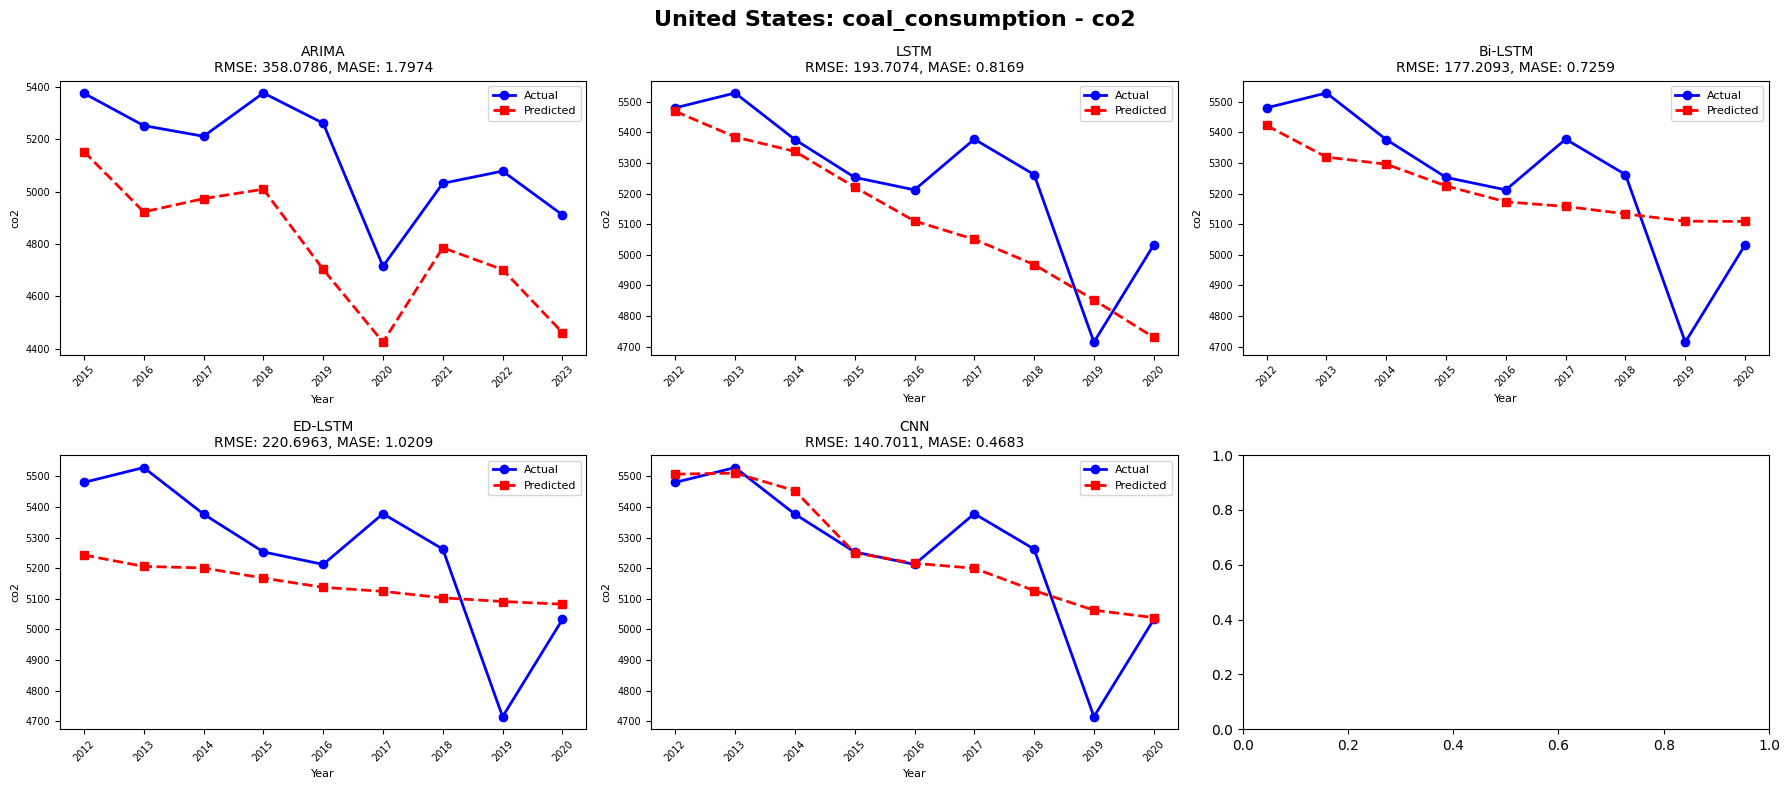

Plotting for China
Plot saved: data_export\02_plots\03_univariate_models\uni_China_coal_consumption_to_co2.png


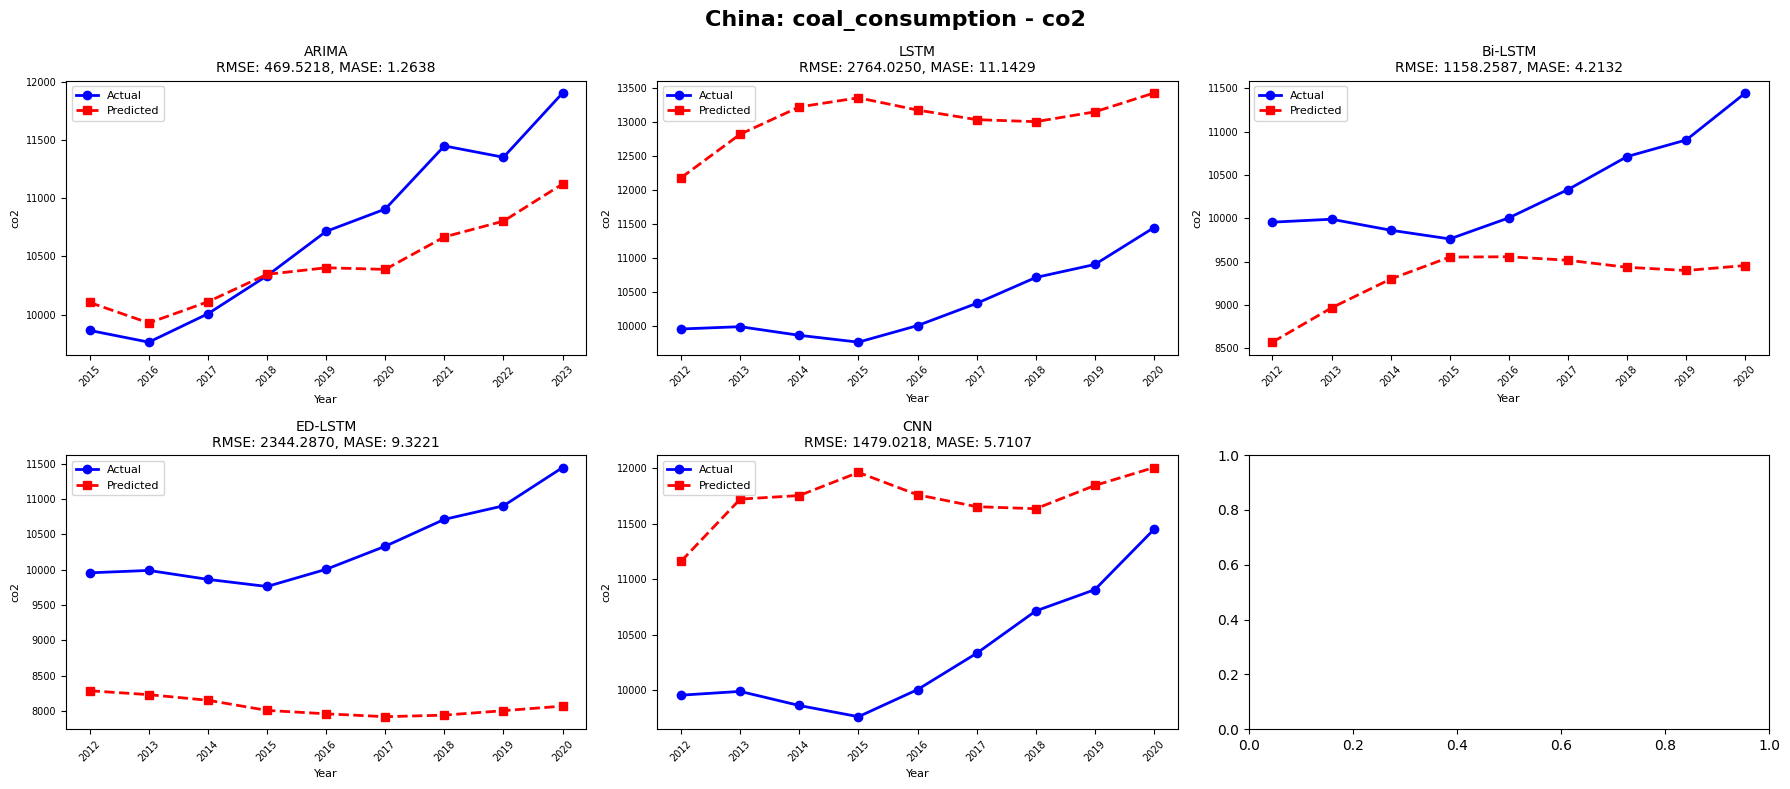

Plotting for India
Plot saved: data_export\02_plots\03_univariate_models\uni_India_coal_consumption_to_co2.png


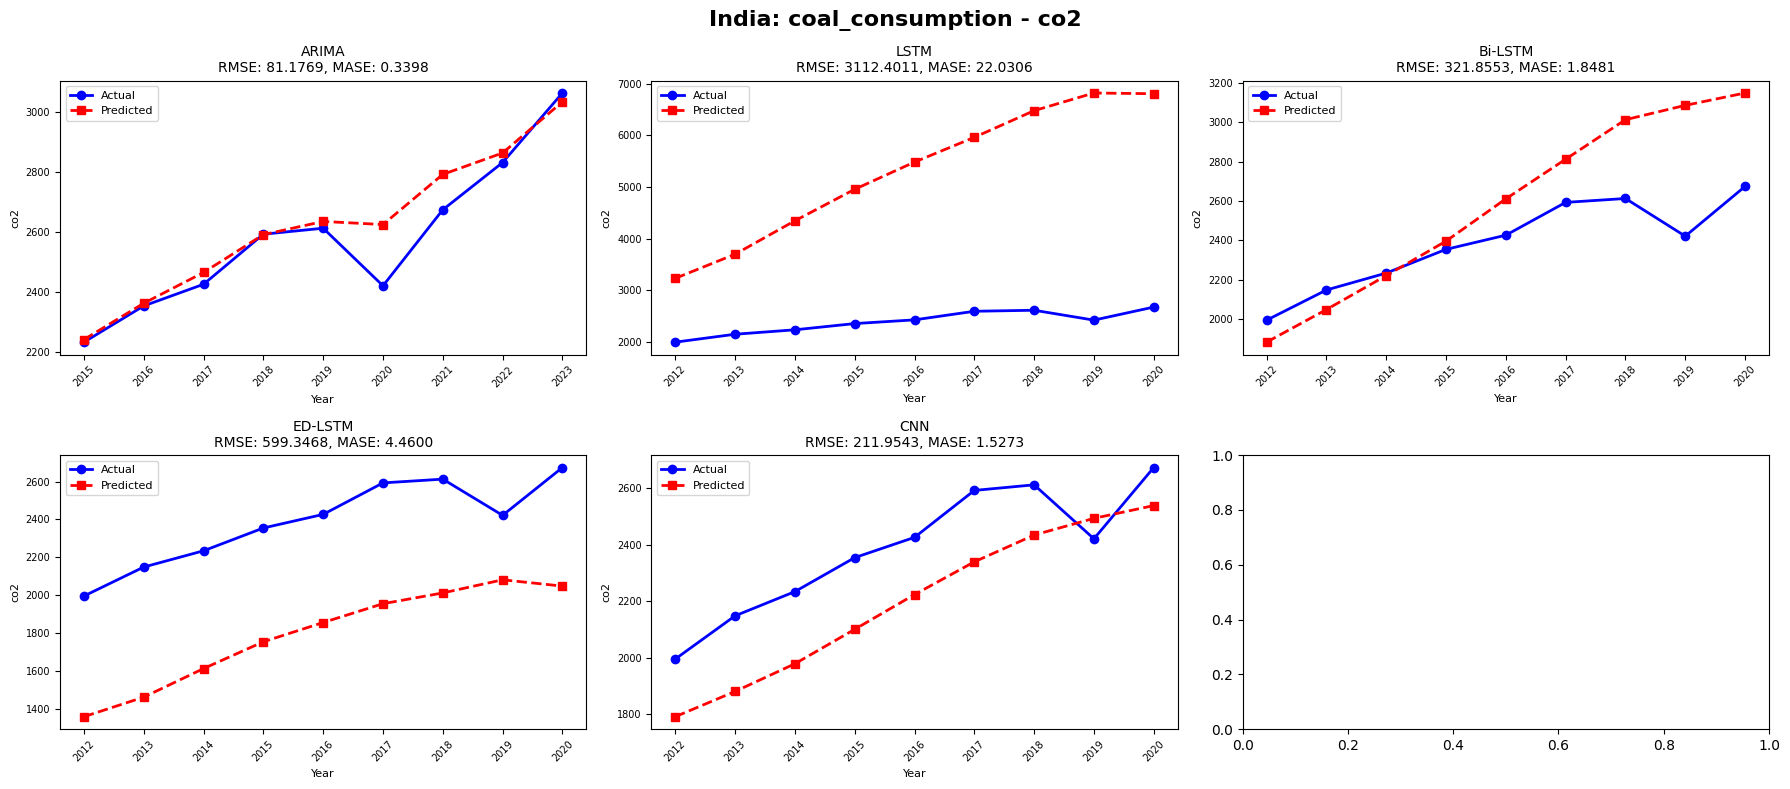

Plotting for Russia
Plot saved: data_export\02_plots\03_univariate_models\uni_Russia_coal_consumption_to_co2.png


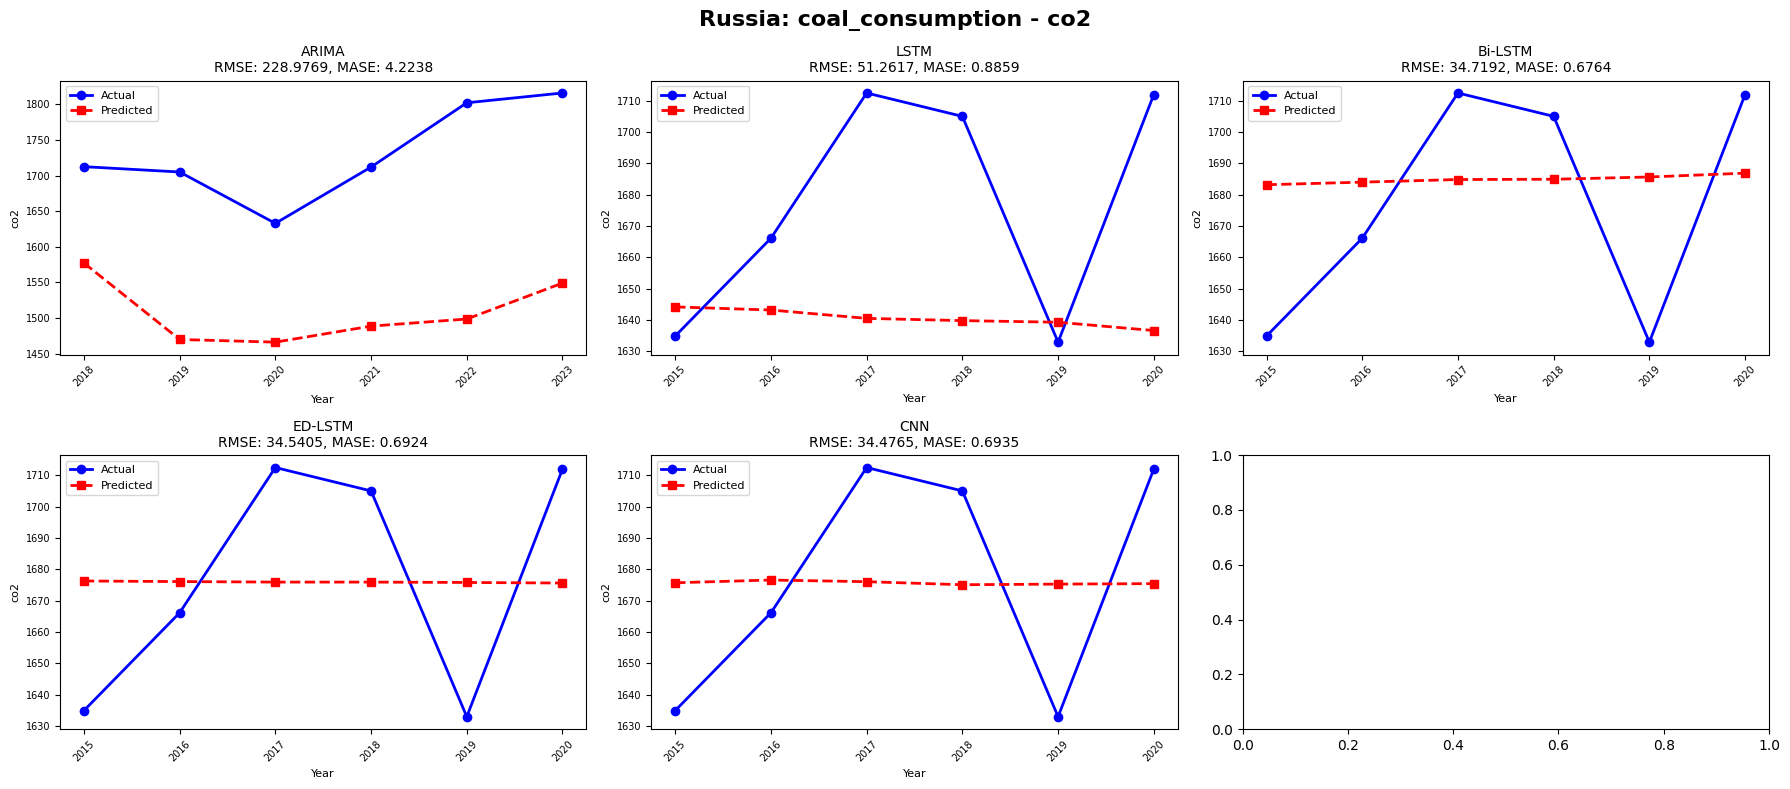

Plotting for Germany
Plot saved: data_export\02_plots\03_univariate_models\uni_Germany_coal_consumption_to_co2.png


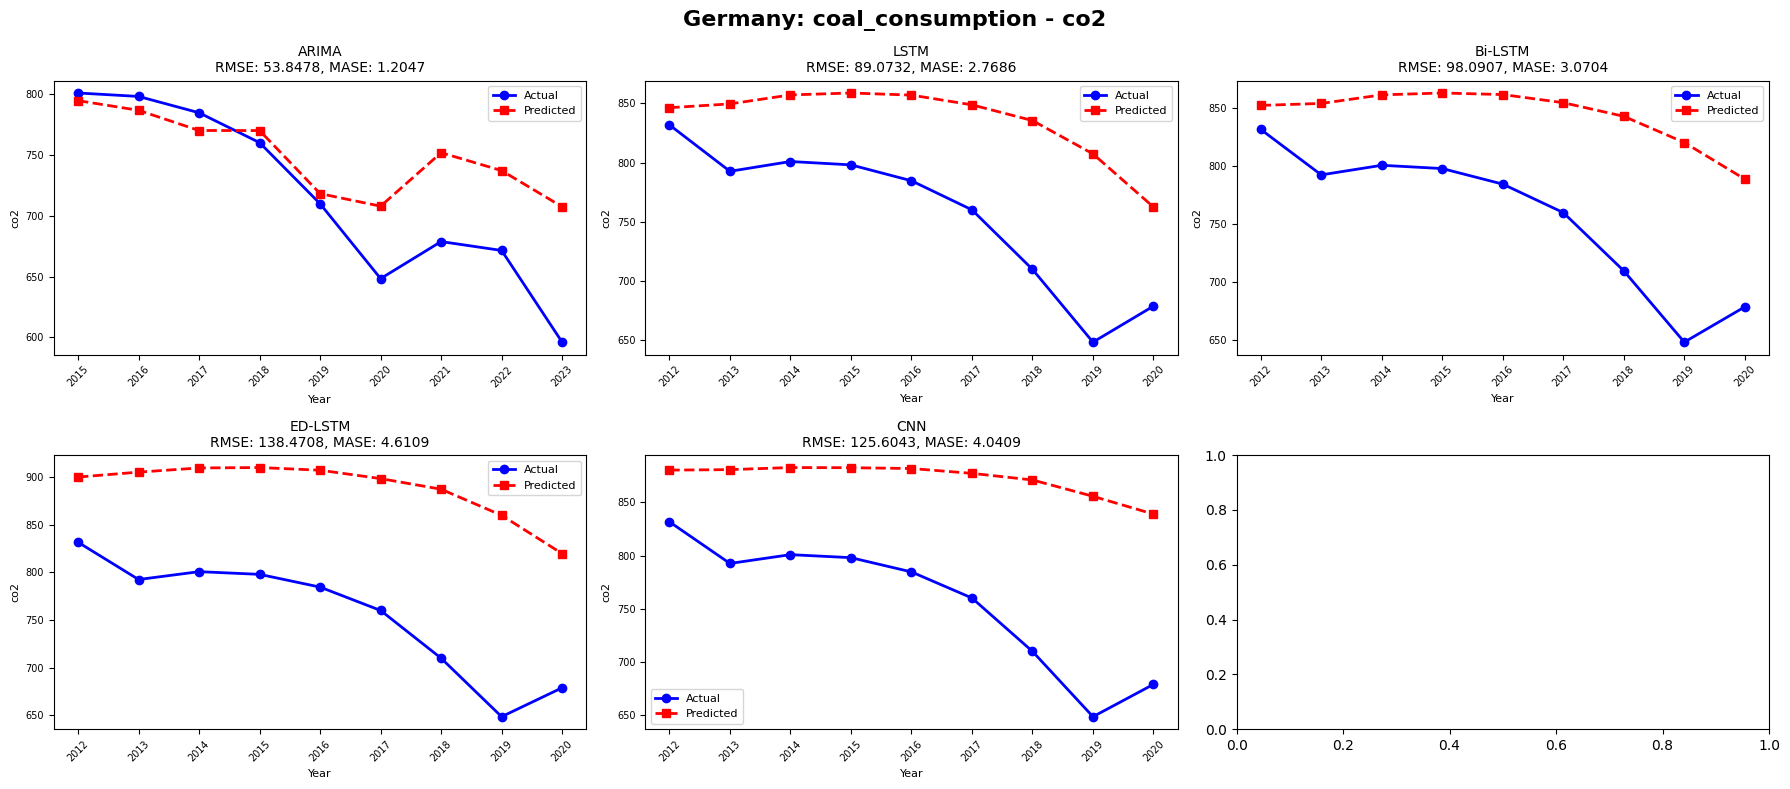

Plotting for Australia
Plot saved: data_export\02_plots\03_univariate_models\uni_Australia_coal_consumption_to_co2.png


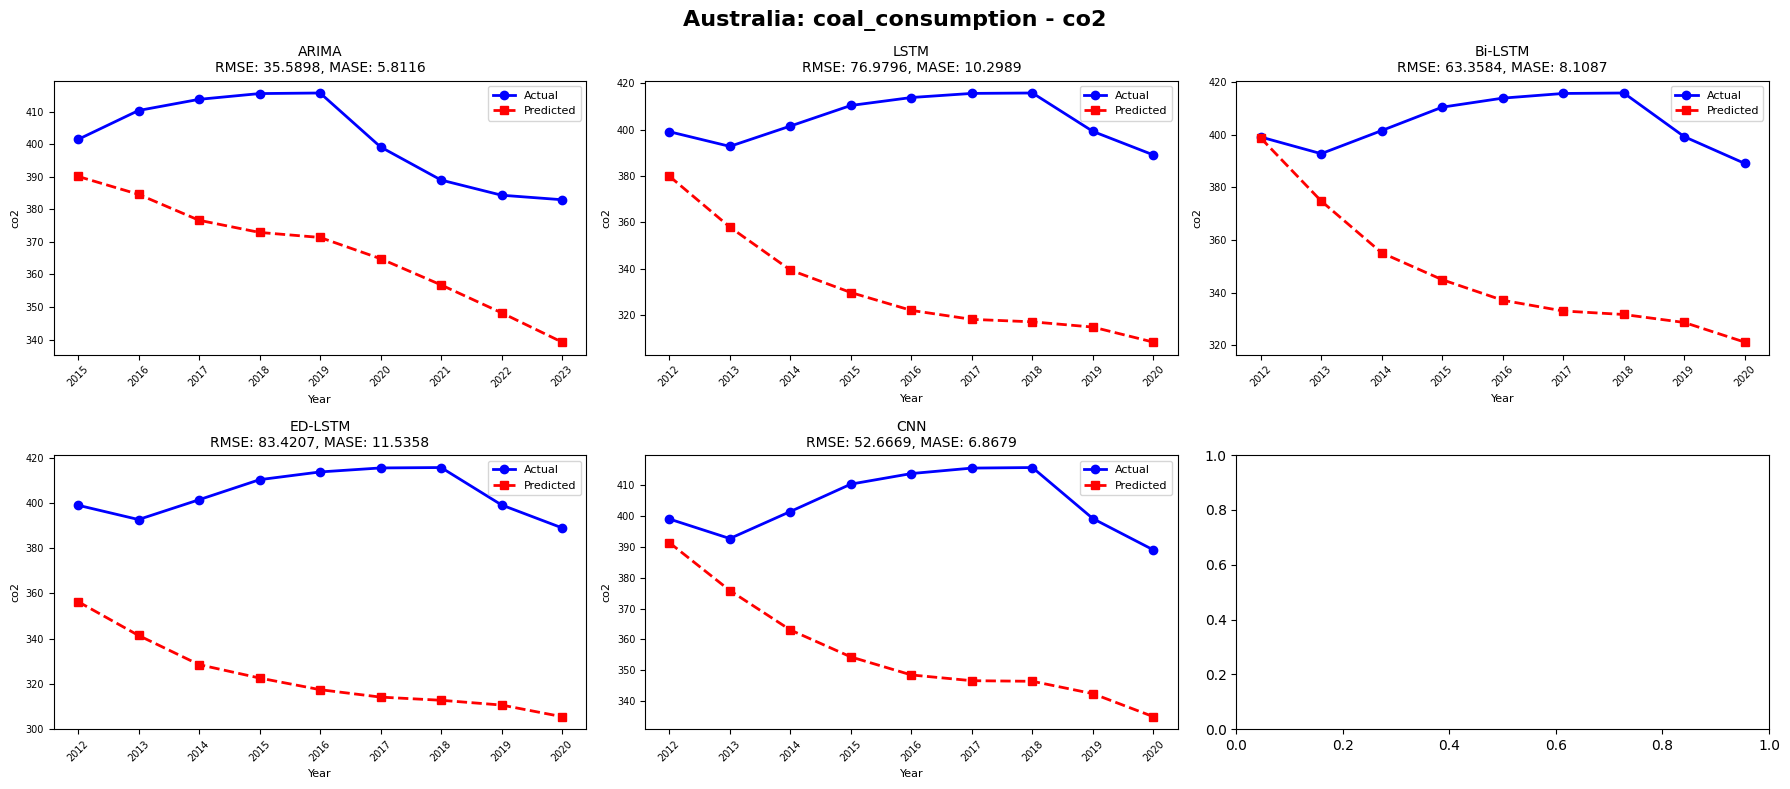

In [17]:
plot_uni_models(target='co2', countries=['United States', 'China', 'India', 'Russia', 'Germany', 'Australia'], feature='coal_consumption')

Loaded data for gdp
Plotting for United States
Plot saved: data_export\02_plots\03_univariate_models\uni_United States_electricity_generation_to_gdp.png


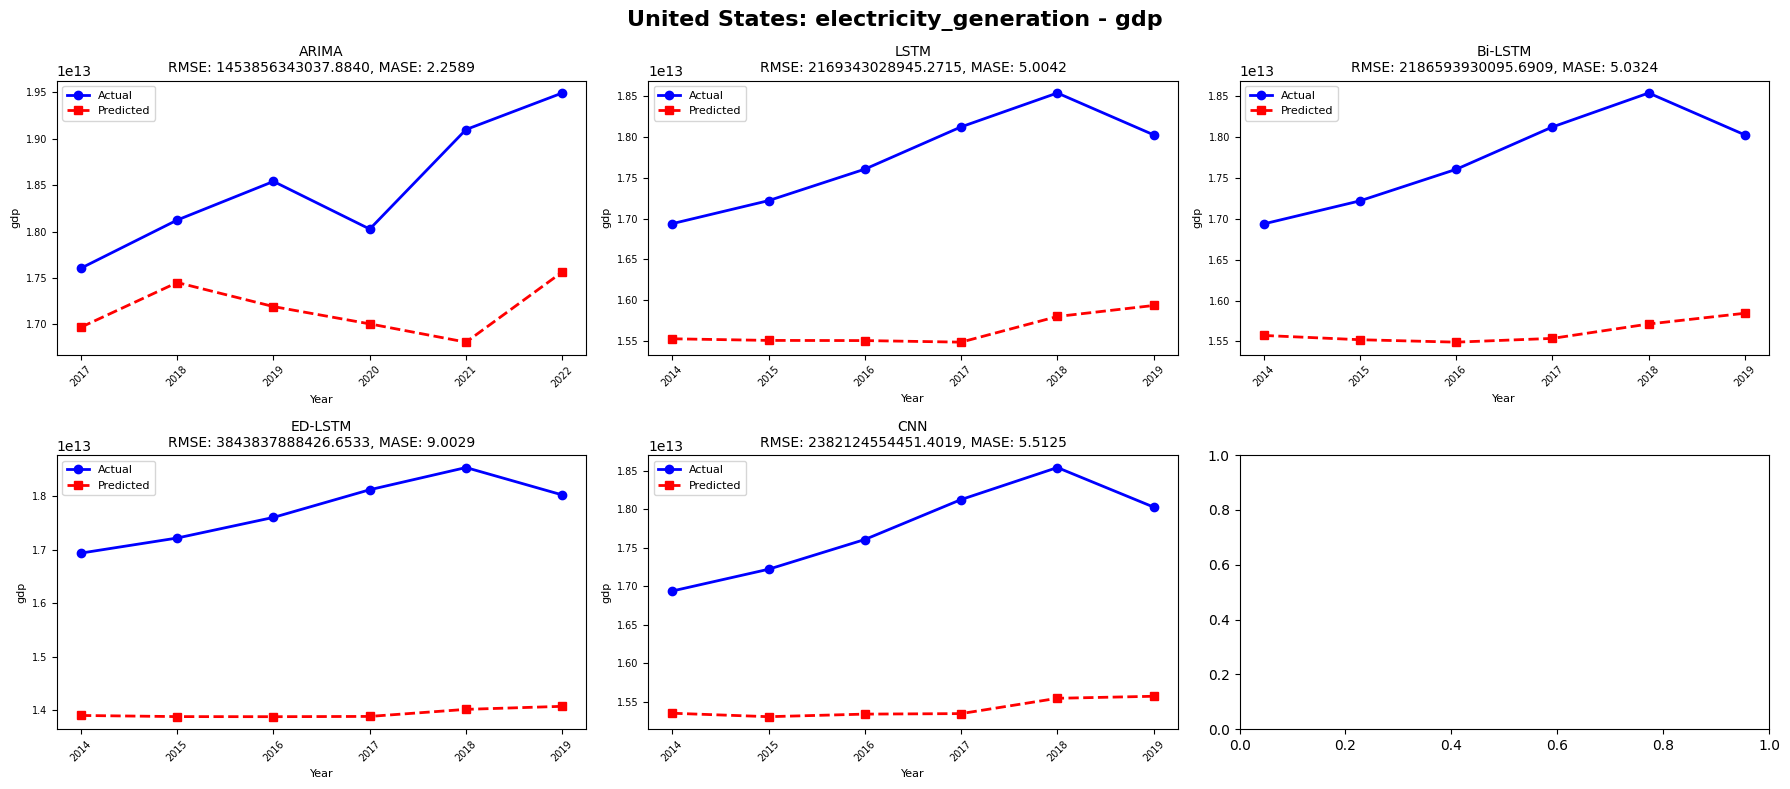

Plotting for China
Plot saved: data_export\02_plots\03_univariate_models\uni_China_electricity_generation_to_gdp.png


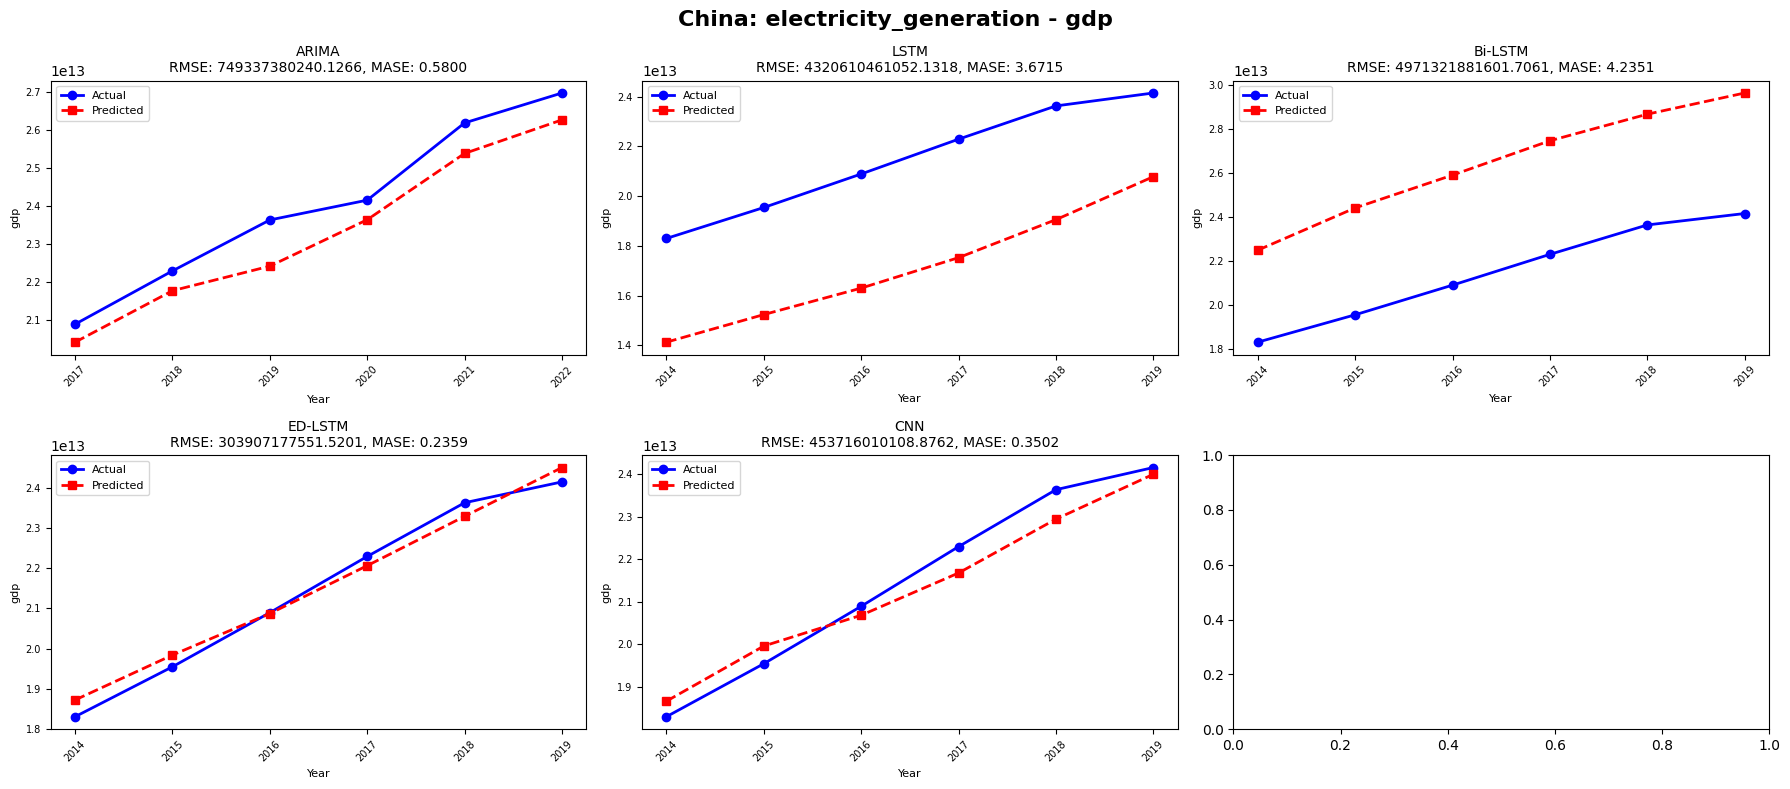

Plotting for India
Plot saved: data_export\02_plots\03_univariate_models\uni_India_electricity_generation_to_gdp.png


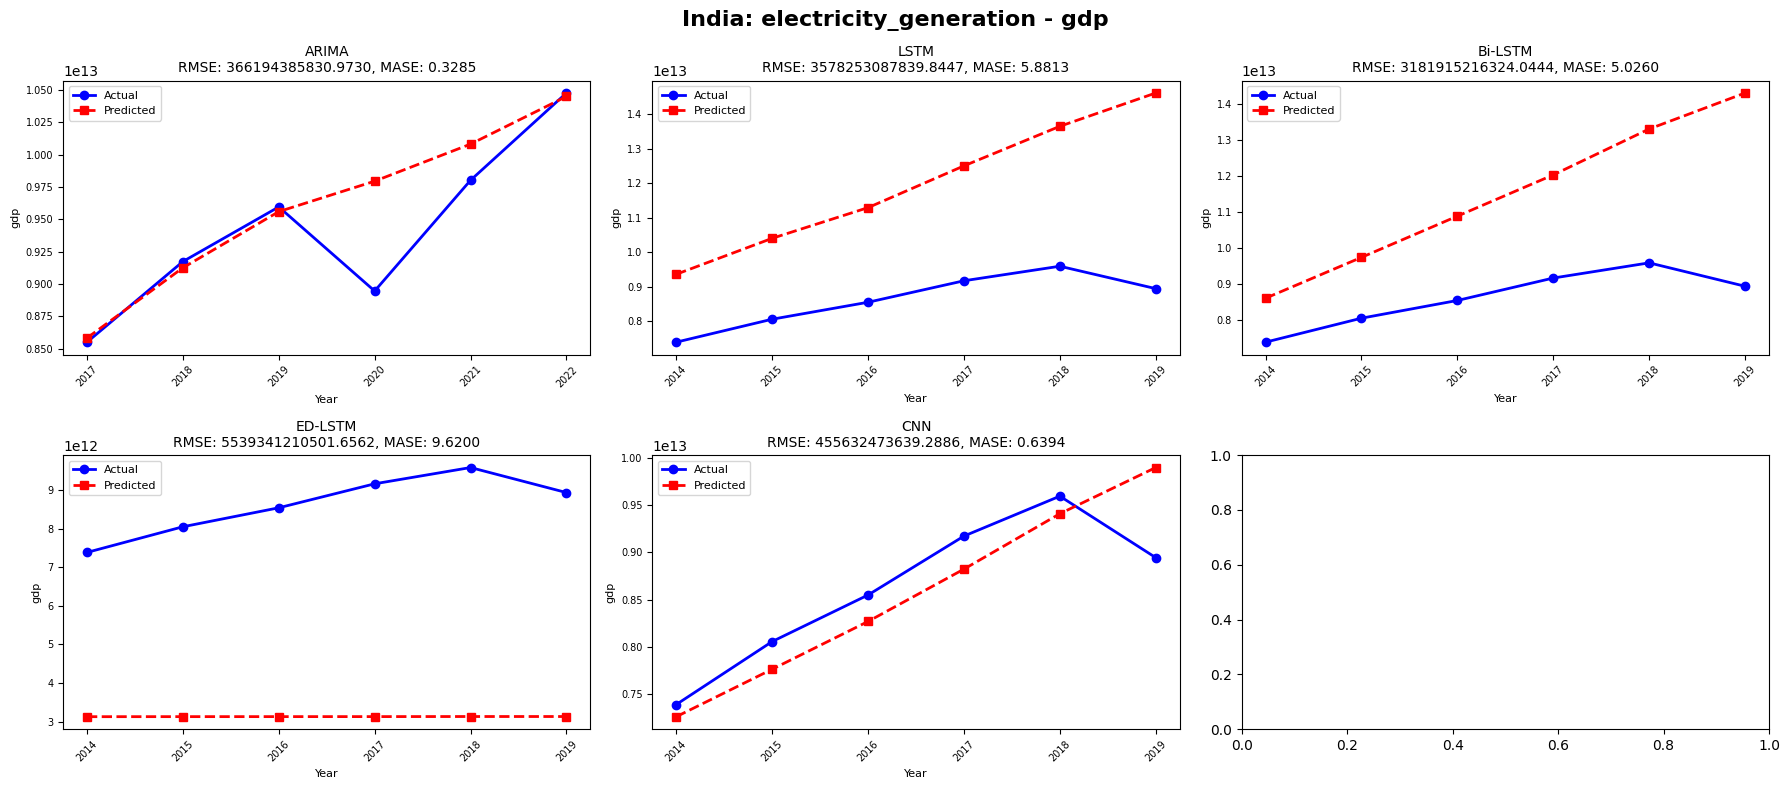

Plotting for Russia
Plot saved: data_export\02_plots\03_univariate_models\uni_Russia_electricity_generation_to_gdp.png


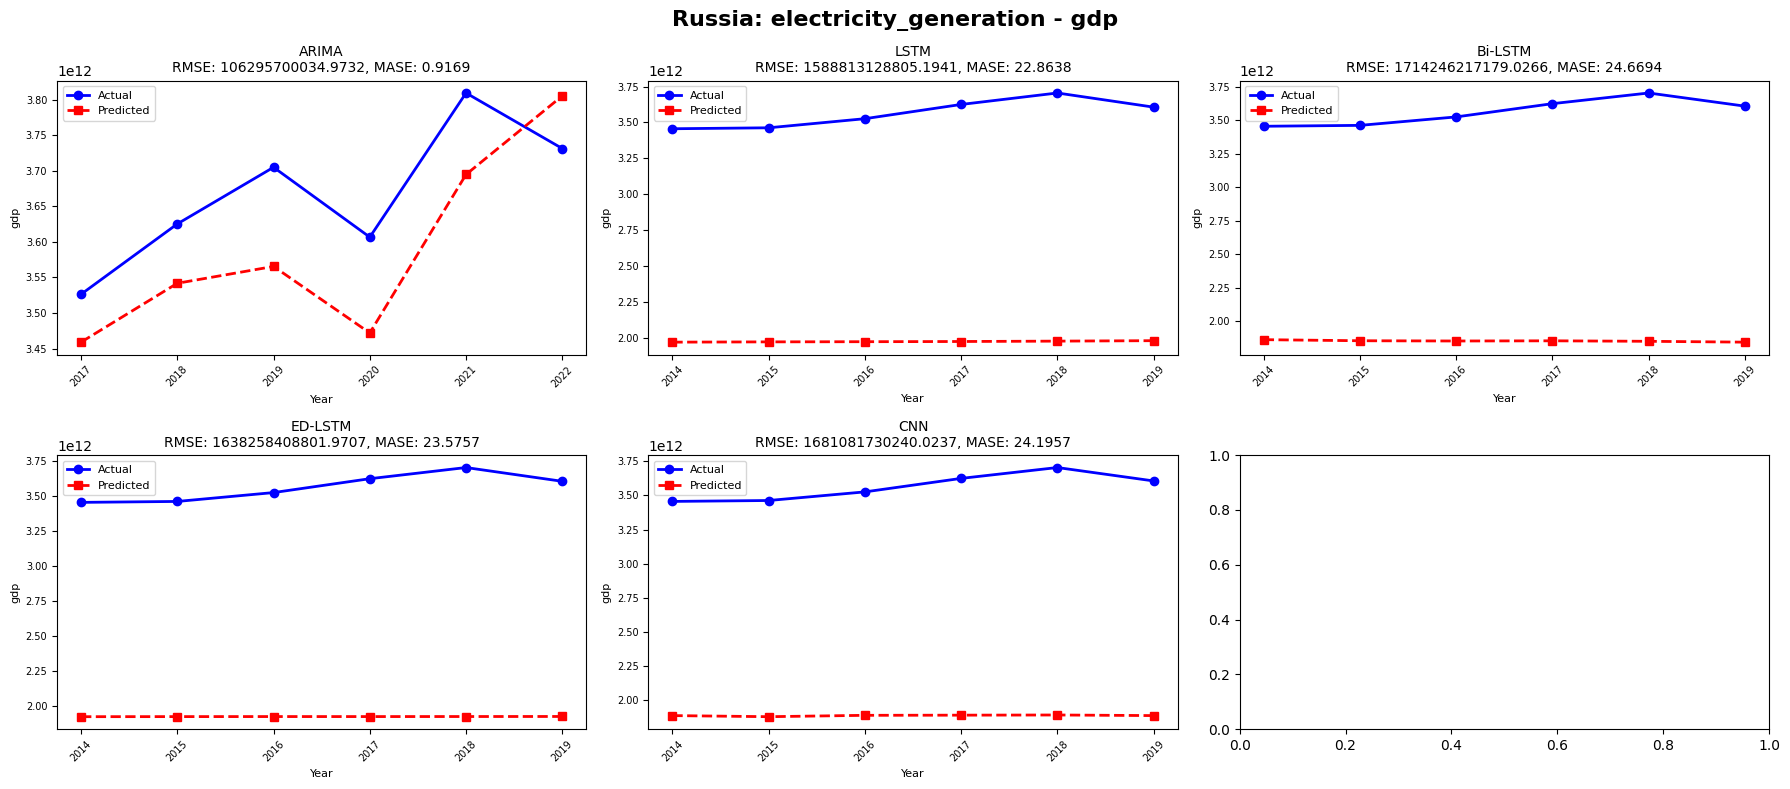

Plotting for Germany
Plot saved: data_export\02_plots\03_univariate_models\uni_Germany_electricity_generation_to_gdp.png


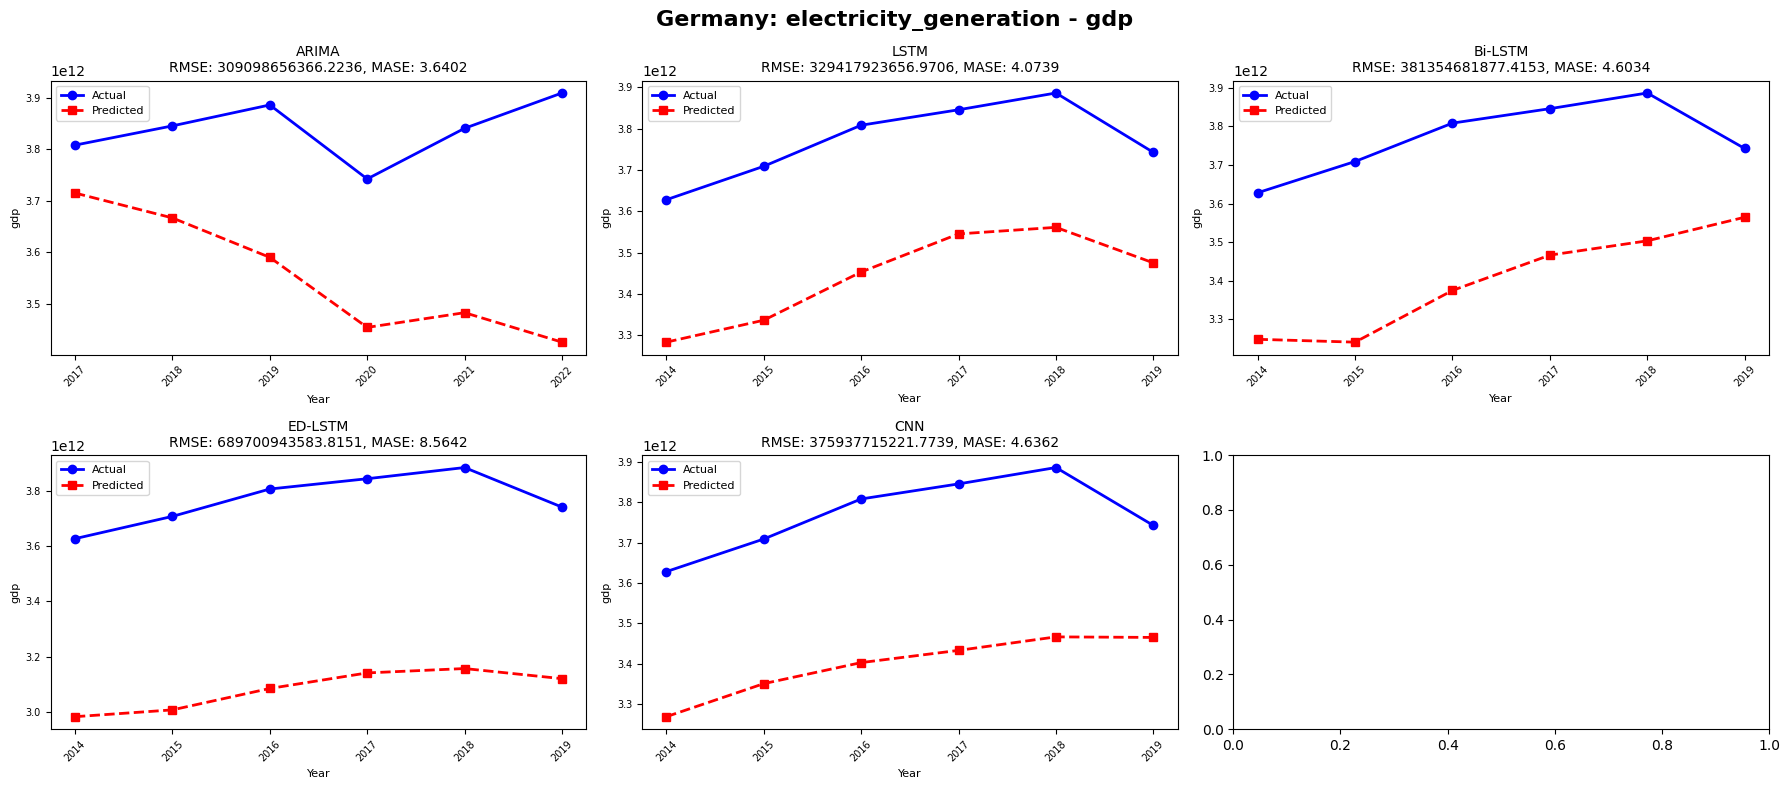

Plotting for Australia
Plot saved: data_export\02_plots\03_univariate_models\uni_Australia_electricity_generation_to_gdp.png


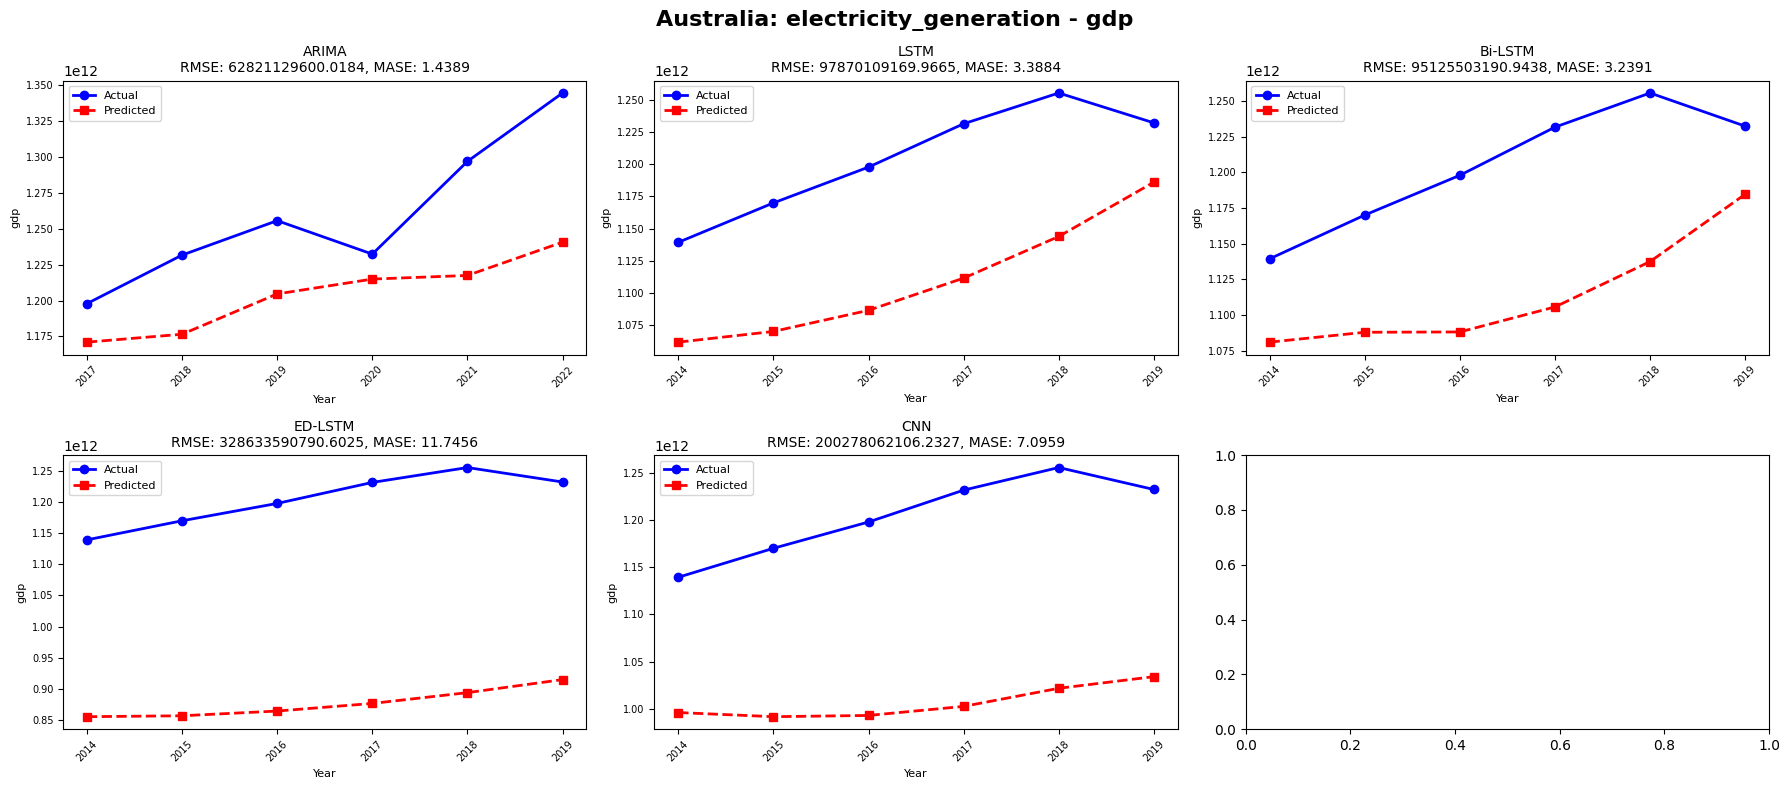

In [18]:
plot_uni_models(target='gdp', countries=['United States', 'China', 'India', 'Russia', 'Germany', 'Australia'], feature='electricity_generation')

Loaded data for primary_energy_consumption
Plotting for United States
Plot saved: data_export\02_plots\03_univariate_models\uni_United States_fossil_fuel_consumption_to_primary_energy_consumption.png


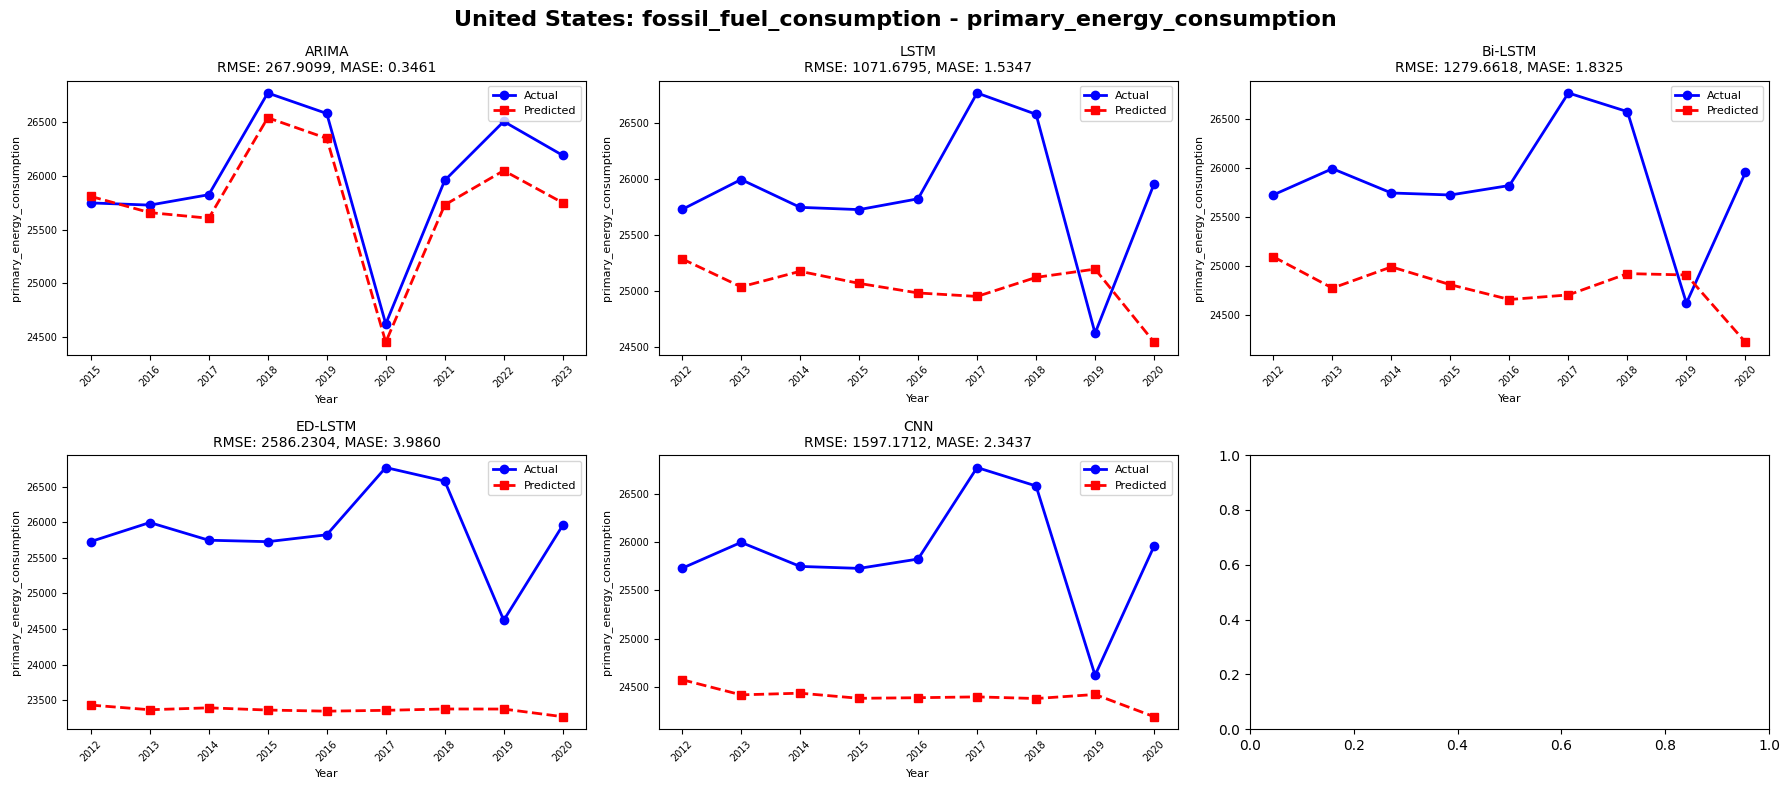

Plotting for China
Plot saved: data_export\02_plots\03_univariate_models\uni_China_fossil_fuel_consumption_to_primary_energy_consumption.png


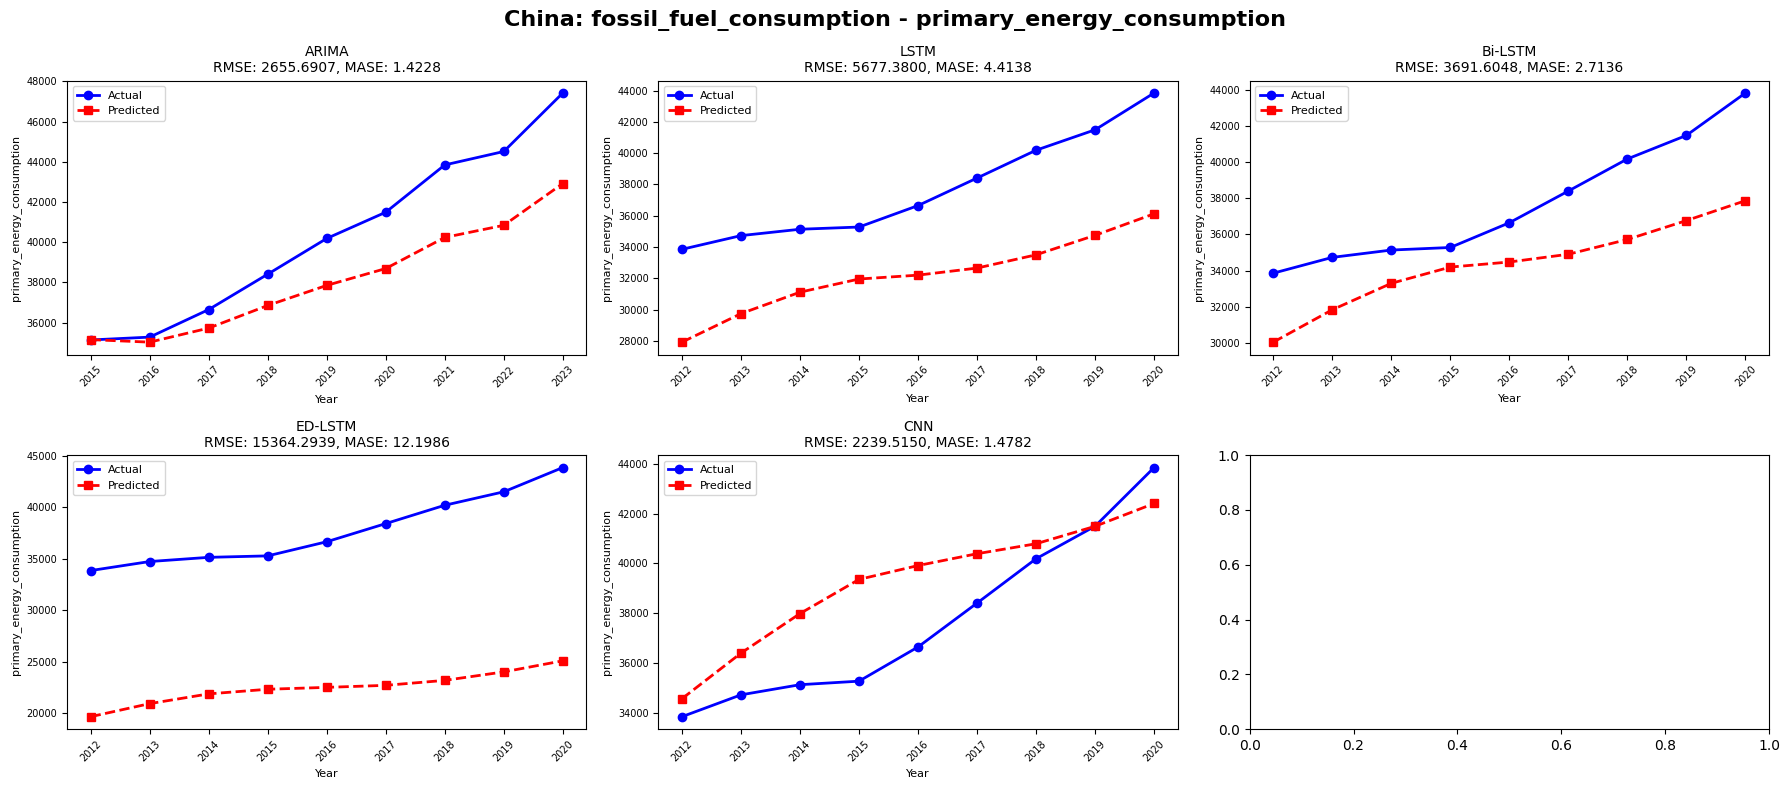

Plotting for India
Plot saved: data_export\02_plots\03_univariate_models\uni_India_fossil_fuel_consumption_to_primary_energy_consumption.png


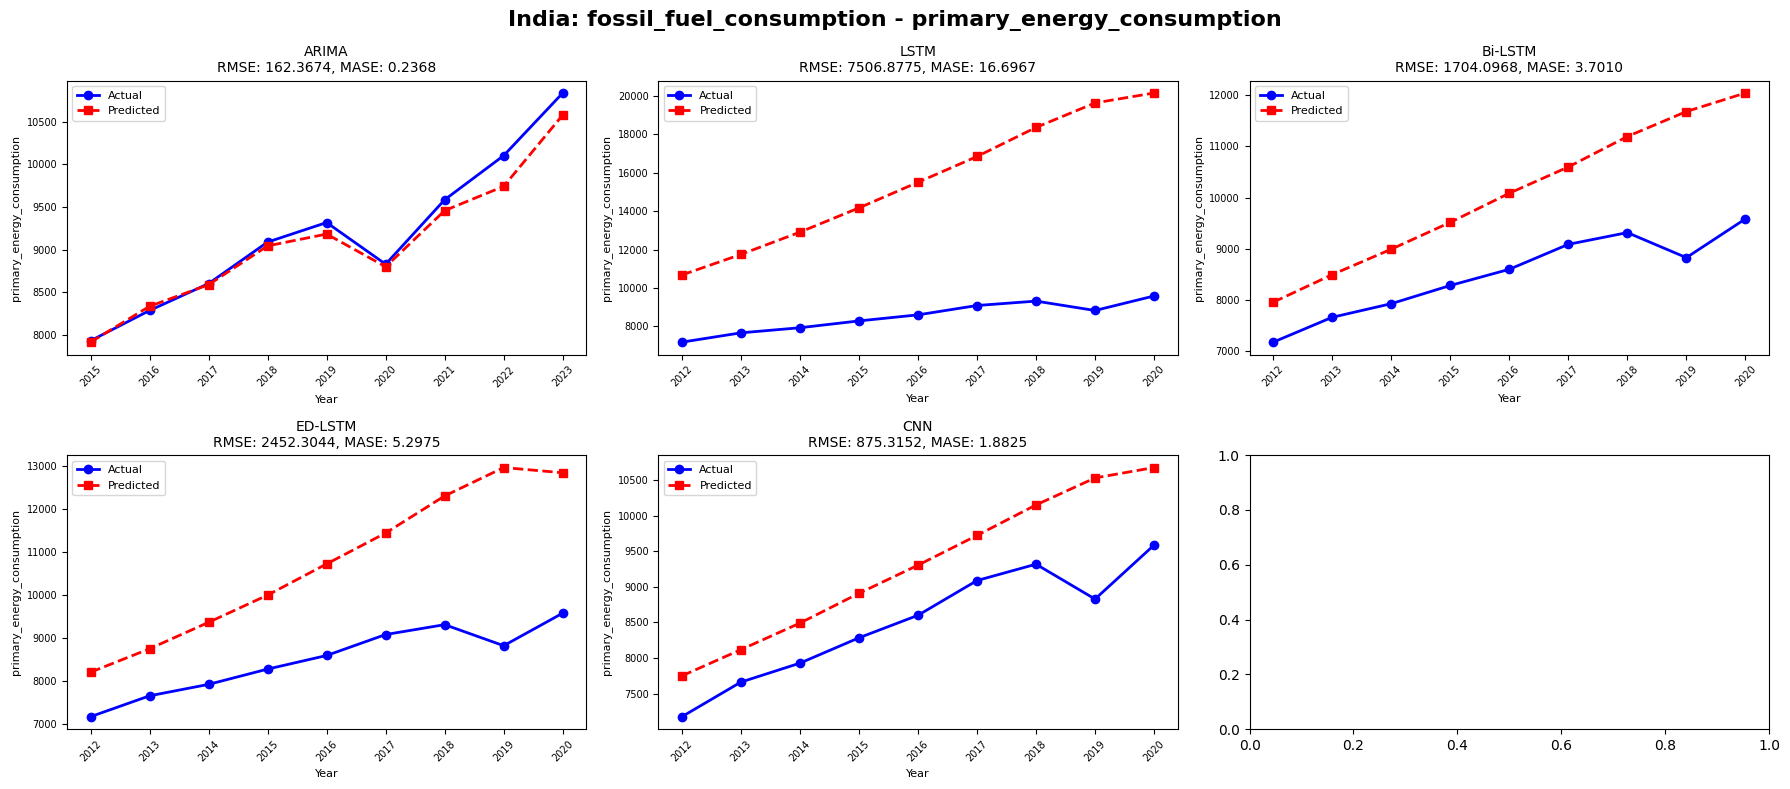

Plotting for Russia
Plot saved: data_export\02_plots\03_univariate_models\uni_Russia_fossil_fuel_consumption_to_primary_energy_consumption.png


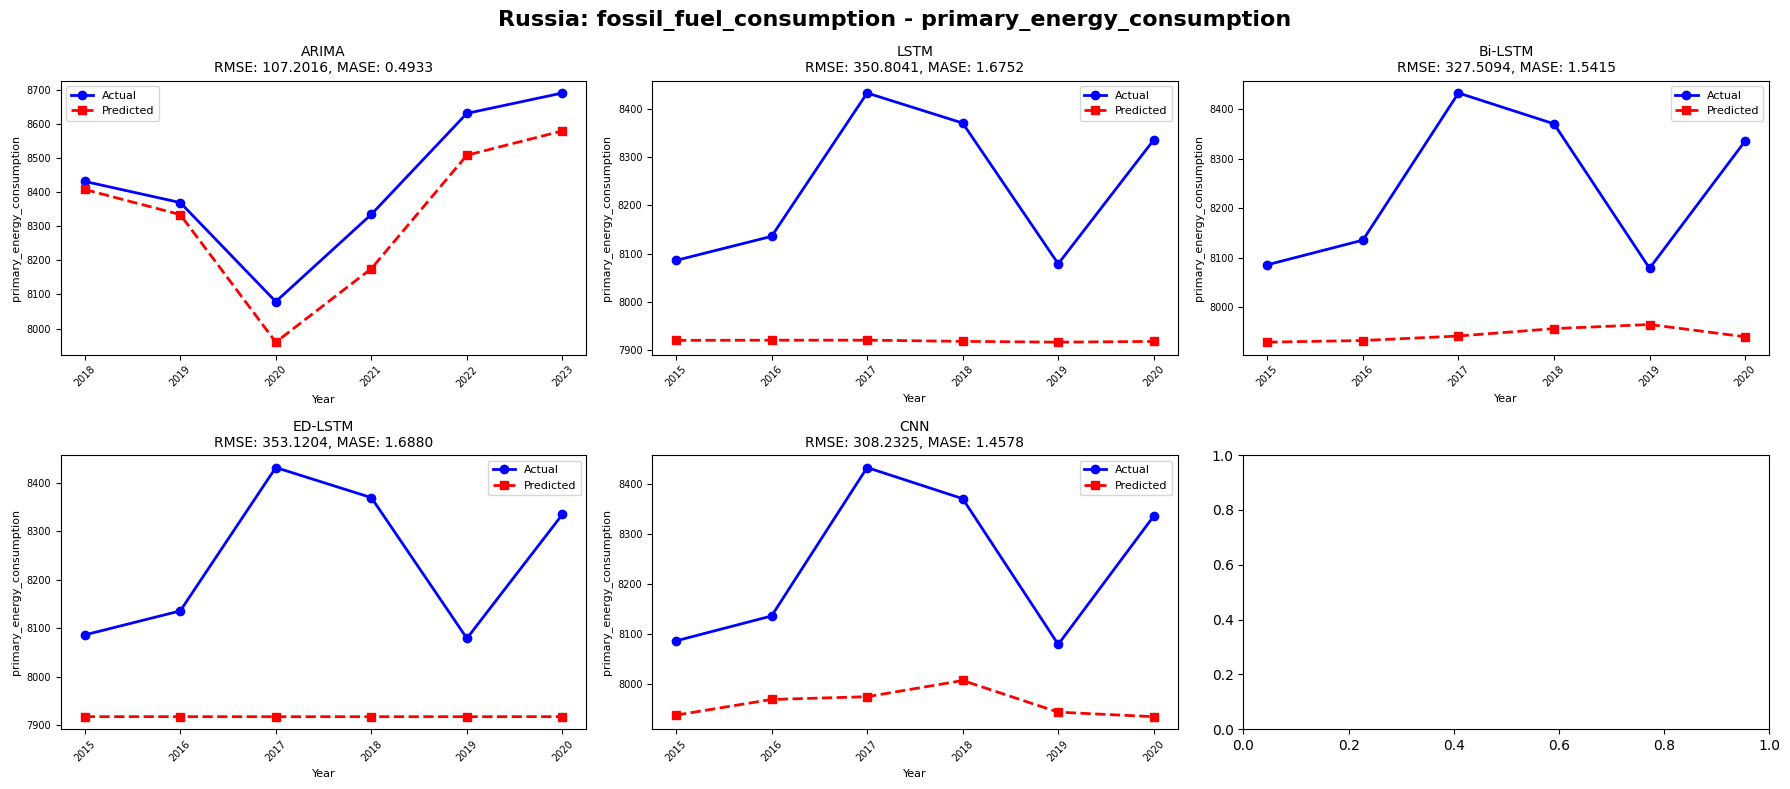

Plotting for Germany
Plot saved: data_export\02_plots\03_univariate_models\uni_Germany_fossil_fuel_consumption_to_primary_energy_consumption.png


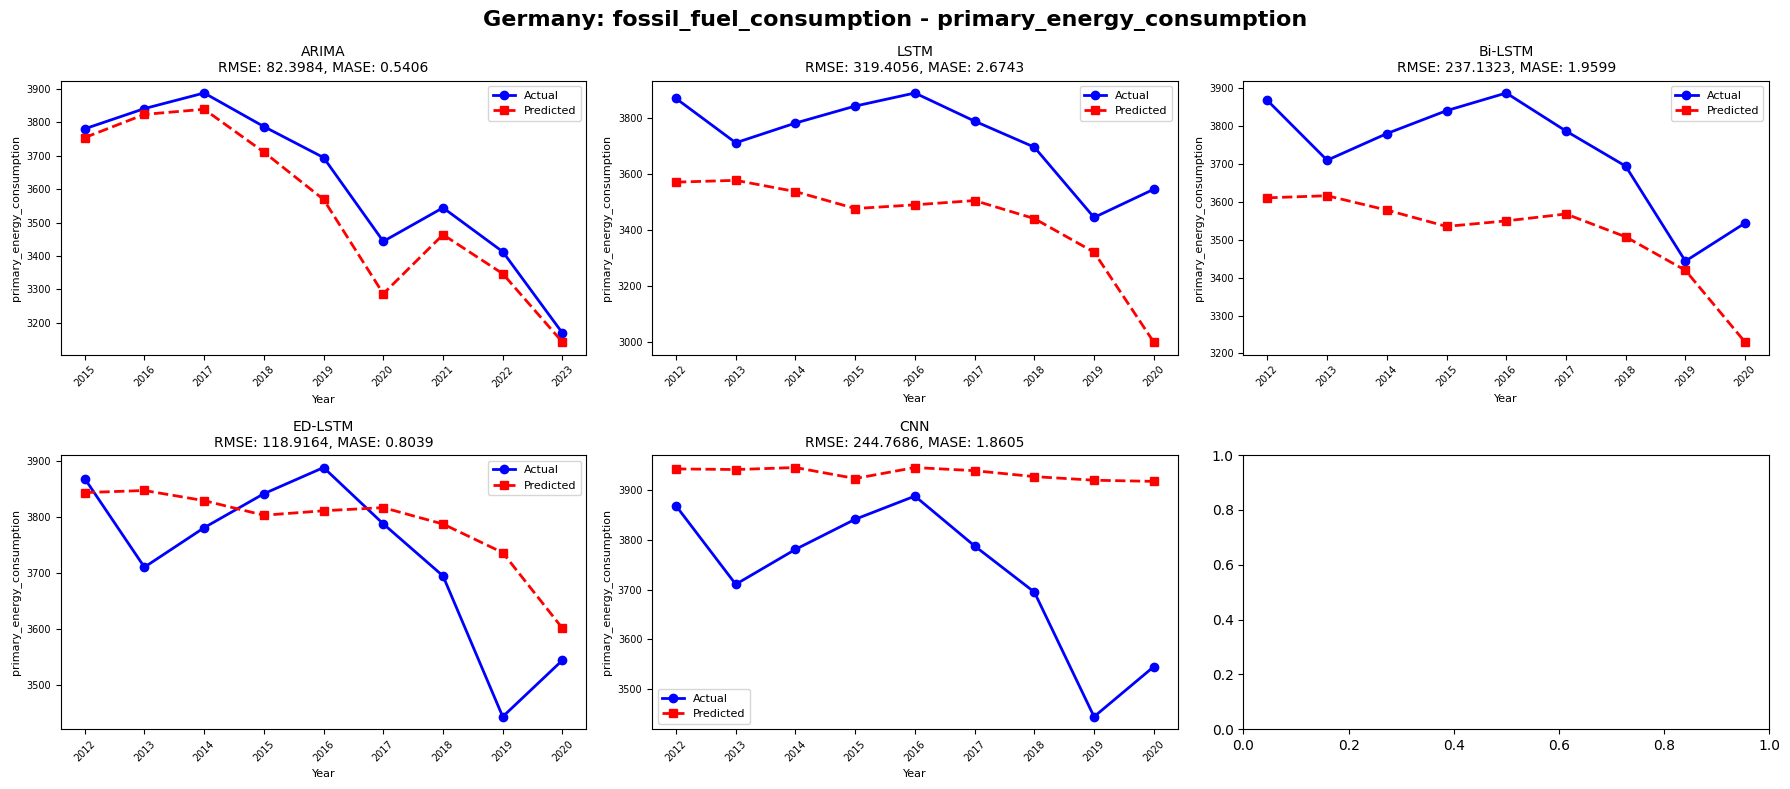

Plotting for Australia
Plot saved: data_export\02_plots\03_univariate_models\uni_Australia_fossil_fuel_consumption_to_primary_energy_consumption.png


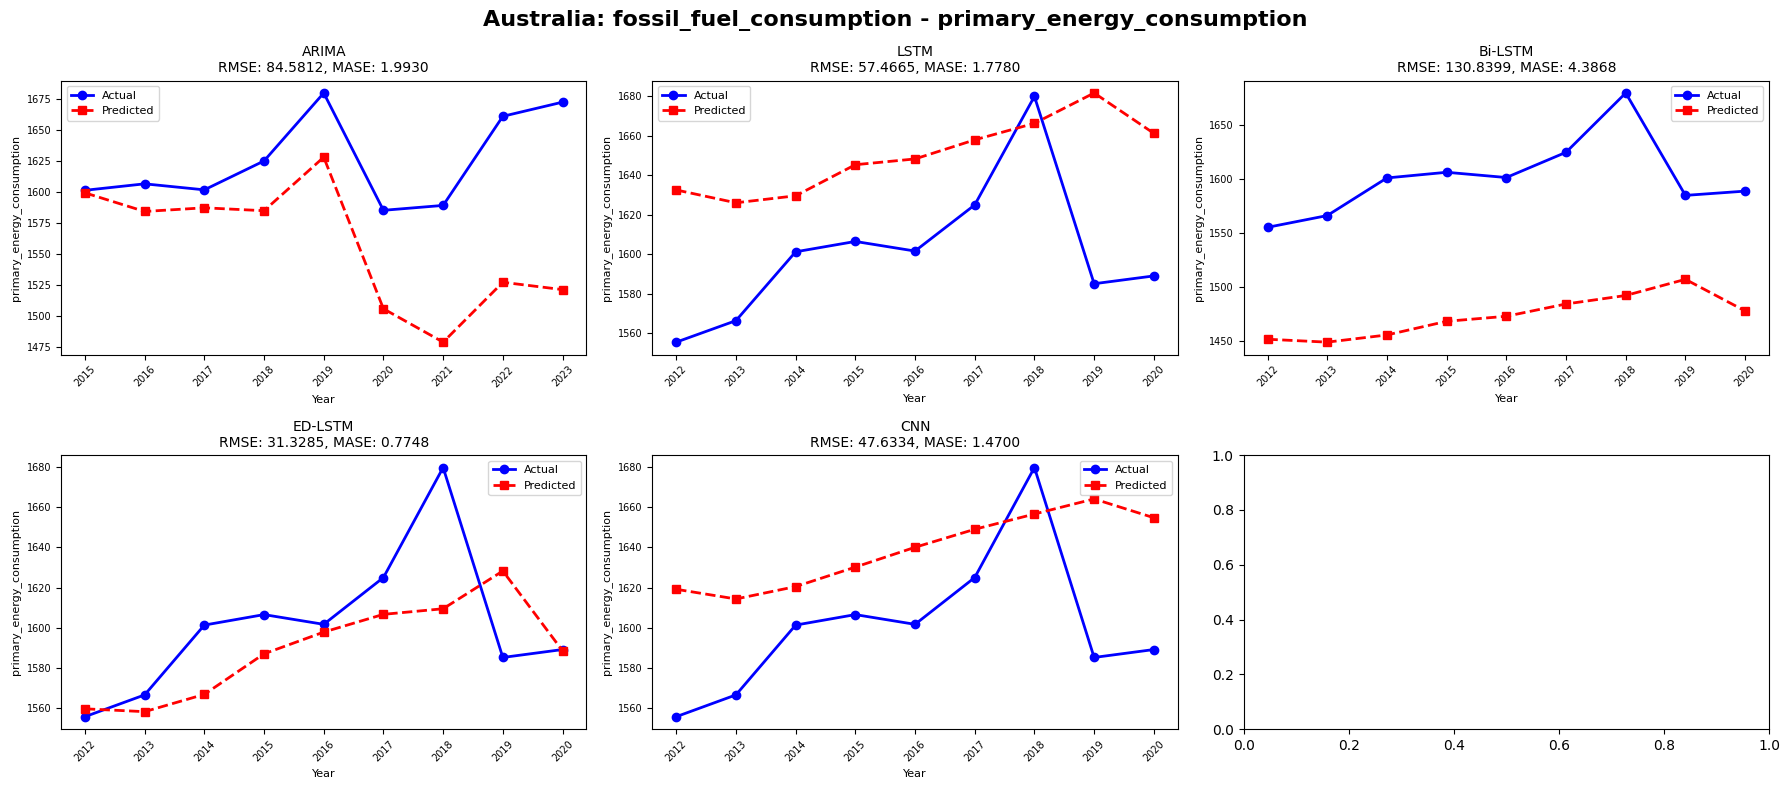

In [19]:
plot_uni_models(target='primary_energy_consumption',
                countries=['United States', 'China', 'India', 'Russia', 'Germany', 'Australia'], feature='fossil_fuel_consumption')

## For the Fast running
The original code took 15+ hours for each target

### Data Prep

In [24]:
def prepare_data_unifited(country_data, feature, target, n_steps_in=5):

    feature_cols = [feature]
    for i in range(1, n_steps_in):
        lag_col = f"{feature}_lag{i}"
        if lag_col in country_data.columns:
            feature_cols.append(lag_col)
    
    all_cols = feature_cols + [target] + ['year']
    data_subset = country_data[all_cols].dropna()
    
    X = data_subset[feature_cols].values
    y = data_subset[target].values.ravel()
    years = data_subset['year'].values
    
    # Consistent split for all models
    n_train = int(len(y) * (1 - TEST_SIZE - VAL_SIZE))
    n_val = int(len(y) * VAL_SIZE)
    
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_val = X[n_train:n_train + n_val]
    y_val = y[n_train:n_train + n_val]
    X_test = X[n_train + n_val:]
    y_test = y[n_train + n_val:]
    test_years = years[n_train + n_val:]
    
    print(f"Data shapes - Train:{len(y_train)}, Val:{len(y_val)}, Test:{len(y_test)}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test, test_years

### Model Training

In [25]:
def train_ARIMA_faster(X_train, y_train, X_val, y_val, X_test, y_test):
    try:
        best_aic = np.inf
        best_model = None
        best_params = None
        
        # Limited parameter ranges instead of full grid search
        param_combinations = [(1,1,1), (2,1,1), (1,1,2), (2,1,2), (0,1,1)]
        
        for p, d, q in param_combinations:
            try:
                model = ARIMA(y_train, exog=X_train, order=(p, d, q))
                fitted_model = model.fit()
                aic = fitted_model.aic
                
                if aic < best_aic:
                    best_aic = aic
                    best_params = (p, d, q)
                    best_model = fitted_model
            except:
                continue
        
        if best_model is None:
            return None, None, None, None
        
        print(f"    Best ARIMA: {best_params}, AIC: {best_aic:.2f}")
        
        y_trainval = np.concatenate([y_train, y_val])
        X_trainval = np.vstack([X_train, X_val])
        
        final_model = ARIMA(y_trainval, exog=X_trainval, order=best_params)
        fitted_final = final_model.fit()
        
        # Multi-step forecast
        n_forecast = len(y_test)
        preds = fitted_final.forecast(steps=n_forecast, exog=X_test)
        preds = np.array(preds).ravel()
        
        rmse_score = rmse(preds, y_test)
        mase_score = mase(y_test, preds)
        
        del fitted_final, final_model, best_model
        clear_memory()
        
        return preds, y_test, rmse_score, mase_score
        
    except Exception as e:
        print(f"    ARIMA failed: {e}")
        return None, None, None, None

In [26]:
def train_dl_faster(model_func, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    try:
        # Scale data
        X_scaler = StandardScaler()
        y_scaler = StandardScaler()
        
        X_train_scaled = X_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
        X_val_scaled = X_scaler.transform(X_val)
        y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1))
        X_test_scaled = X_scaler.transform(X_test)
        
        # Reshape for LSTM, CNN: (n_samples, timesteps, n_features)
        X_train_dl = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
        X_val_dl = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
        X_test_dl = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
        
        # For ED-LSTM, we need y to be (n_samples, n_steps_out, 1)
        if 'ED-LSTM' in model_name:
            y_train_dl = y_train_scaled.reshape(y_train_scaled.shape[0], N_STEPS_OUT, 1)
            y_val_dl = y_val_scaled.reshape(y_val_scaled.shape[0], N_STEPS_OUT, 1)
        else:
            y_train_dl = y_train_scaled.ravel()
            y_val_dl = y_val_scaled.ravel()
        
        # Build model
        input_shape = (X_train_dl.shape[1], X_train_dl.shape[2])
        model = model_func(input_shape, N_STEPS_OUT)
        
        # Fast training
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        model.fit(
            X_train_dl, y_train_dl,
            validation_data=(X_val_dl, y_val_dl),
            epochs=20,
            batch_size=min(16, len(X_train_dl)),
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Predict on test set
        n_test_samples = min(len(X_test_dl), len(y_test))
        if n_test_samples > 0:
            preds_scaled = model.predict(X_test_dl[:n_test_samples], verbose=0)
            
            # Handle ED-LSTM 3D output (batch, steps, 1)
            if len(preds_scaled.shape) == 3:
                preds_scaled = preds_scaled.reshape(preds_scaled.shape[0], preds_scaled.shape[1])
            
            # For single-step prediction, take first column if multi-step
            if len(preds_scaled.shape) == 2 and preds_scaled.shape[1] > 1:
                preds_scaled = preds_scaled[:, 0]
            elif len(preds_scaled.shape) == 2 and preds_scaled.shape[1] == 1:
                preds_scaled = preds_scaled.ravel()
            
            # Inverse transform
            preds = y_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
            actual_test = y_test[:n_test_samples]
        else:
            preds = np.array([])
            actual_test = np.array([])
        
        rmse_score = rmse(preds, actual_test) if len(preds) > 0 else np.inf
        mase_score = mase(actual_test, preds) if len(preds) > 0 else np.inf
        
        del model
        clear_memory()
        
        return preds, actual_test, rmse_score, mase_score
        
    except Exception as e:
        print(f"    {model_name} failed: {e}")
        return None, None, None, None

### Model Test

In [27]:
def test_models_faster(feature, target, lag_df):
    
    results = defaultdict(list)
    preds_data = {}
    
    for country in G20_COUNTRIES:
        country_data = lag_df[lag_df['country'] == country].sort_values('year')
        print(f"\nTesting {country}")
        
        # Unified data preparation
        data_prep = prepare_data_unifited(country_data, feature, target, N_STEPS_IN)
        X_train, y_train, X_val, y_val, X_test, y_test, test_years = data_prep
        
        # Test ARIMA
        print(f"  Training ARIMA")
        arima_result = train_ARIMA_faster(X_train, y_train, X_val, y_val, X_test, y_test)
        
        if arima_result[0] is not None:
            preds, actual, rmse_score, mase_score = arima_result
            results['ARIMA'].append({
                'country': country,
                'rmse': rmse_score,
                'mase': mase_score
            })
            preds_data[(country, 'ARIMA')] = {
                'predictions': preds,
                'actuals': actual,
                'years': test_years
            }
            print(f"    ARIMA - RMSE: {rmse_score:.4f}, MASE: {mase_score:.4f}")
        
        # Test DL models
        dl_models = [
            ('LSTM', build_lstm),
            ('Bi-LSTM', build_bilstm),
            ('ED-LSTM', build_edlstm),
            ('CNN', build_cnn)
        ]
        
        for model_name, model_func in dl_models:
            print(f"  Training {model_name}")
            
            dl_result = train_dl_faster(model_func, X_train, y_train, X_val, y_val, X_test, y_test, model_name)
            
            if dl_result[0] is not None:
                preds, actual, rmse_score, mase_score = dl_result
                
                results[model_name].append({
                    'country': country,
                    'rmse': rmse_score,
                    'mase': mase_score
                })
                
                preds_data[(country, model_name)] = {
                    'predictions': preds,
                    'actuals': actual,
                    'years': test_years
                }
                
                print(f"    {model_name} - RMSE: {rmse_score:.4f}, MASE: {mase_score:.4f}")
    
    return results, preds_data

### Rank feature

In [21]:
def rank_features_by_country(all_results, save_dir='data_export'):
    
    country_rankings = {}
    target_rankings = {}
    
    for target in TARGET_VARIABLES:
        print(f"\nRanking features for {target}")
        target_rankings[target] = {}
        
        target_features = []
        for (feat, tgt), _ in all_results.items():
            if tgt == target:
                target_features.append(feat)
        
        # Rank features for each country
        for country in G20_COUNTRIES:
            country_scores = {}
            
            for feature in target_features:
                key = (feature, target)

                if key in all_results:
                    country_results = []

                    for model_name, model_results in all_results[key].items():
                        for result in model_results:
    
                            if result['country'] == country:
                                country_results.append(result['rmse'])
                    
                    if country_results:
                        country_scores[feature] = np.mean(country_results)
            
            # Rank features
            if country_scores:
                sorted_features = sorted(country_scores.items(), key=lambda x: x[1])
                country_rankings[(country, target)] = {
                    'feature_scores': dict(sorted_features),
                    'feature_rank_order': [f[0] for f in sorted_features]
                }
                
                print(f"\n{country} top 3 features:")
                for i, (feat, score) in enumerate(sorted_features[:3], 1):
                    print(f"  {i}. {feat}: {score:.4f}")
        
        # Final ranking for all
        feature_rank_sums = defaultdict(int)
        feature_counts = defaultdict(int)
        
        for country in G20_COUNTRIES:
            key = (country, target)
            if key in country_rankings:
                rank_order = country_rankings[key]['feature_rank_order']
                for rank, feature in enumerate(rank_order, 1):
                    feature_rank_sums[feature] += rank
                    feature_counts[feature] += 1
        
        # Calculating average rank
        avg_ranks = {}
        for feature in feature_rank_sums:
            if feature_counts[feature] > 0:
                avg_ranks[feature] = feature_rank_sums[feature] / feature_counts[feature]
        
        # Final ranking
        final_ranking = sorted(avg_ranks.items(), key=lambda x: x[1])
        target_rankings[target]['final_ranking'] = final_ranking
        target_rankings[target]['avg_ranks'] = avg_ranks
        
        print(f"\nFinal feature ranking for {target}:")
        for i, (feature, avg_rank) in enumerate(final_ranking[:15], 1):
            print(f"{i}. {feature}: avg rank {avg_rank:.2f}")
    
    # Save rankings
    results_dir = os.path.join(save_dir, '02_results')
    os.makedirs(results_dir, exist_ok=True)
    
    with open(os.path.join(results_dir, 'country_uni_rankings.pkl'), 'wb') as f:
        pickle.dump(country_rankings, f)
    
    with open(os.path.join(results_dir, 'final_uni_rankings.pkl'), 'wb') as f:
        pickle.dump(target_rankings, f)
    
    return country_rankings, target_rankings

### Analysis of features

In [7]:
def run_analysis(selected_features, lag_df, target='co2', save_dir='data_export'):
    
    print(f"Analysis for {target}")
    all_results = {}
    all_preds_data = {}
    
    for feature in tqdm(selected_features):
        if feature == target:
            continue
        
        print(f"\nTesting {feature}")
        results, preds_data = test_models_faster(feature, target, lag_df)
        
        if results:
            all_results[(feature, target)] = results
            for key, value in preds_data.items():
                all_preds_data[(feature, target, key[0], key[1])] = value
    
    # Save results
    results_dir = os.path.join(save_dir, '02_results')
    os.makedirs(results_dir, exist_ok=True)
    
    with open(os.path.join(results_dir, f'{target}_predictions.pkl'), 'wb') as f:
        pickle.dump(all_preds_data, f)
    
    print(f"Results saved for {target}")
    return all_results, all_preds_data

### Summary result for the results

In [8]:
def create_summary_results(all_results, save_dir='data_export'):

    summary_data = []
    
    for (feature, target), model_results in all_results.items():
        for model_name, results_list in model_results.items():
            if results_list:
                rmse_values = [r['rmse'] for r in results_list]
                mase_values = [r['mase'] for r in results_list]
                
                summary_data.append({
                    'feature': feature,
                    'target': target,
                    'model': model_name,
                    'n_countries': len(results_list),
                    'avg_rmse': np.mean(rmse_values),
                    'std_rmse': np.std(rmse_values),
                    'min_rmse': np.min(rmse_values),
                    'max_rmse': np.max(rmse_values),
                    'avg_mase': np.mean(mase_values),
                    'std_mase': np.std(mase_values)
                })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Save summary
    results_dir = os.path.join(save_dir, '02_results')
    os.makedirs(results_dir, exist_ok=True)
    summary_df.to_csv(os.path.join(results_dir, 'uni_model_summary.csv'), index=False)
    
    return summary_df

In [32]:
selected_features, lag_df = load_data()

Selected features loaded
Time lag dataframe loaded


In [ ]:
co2_results, co2_preds = run_analysis(selected_features, lag_df, target='co2')
gdp_results, gdp_preds = run_analysis(selected_features, lag_df, target='gdp')

Selected features loaded
Time lag dataframe loaded
Analysis for co2


  0%|          | 0/21 [00:00<?, ?it/s]


Testing electricity_generation

Testing United States
Data shapes - Train:24, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 297.36

    ARIMA - RMSE: 321.6637, MASE: 1.1379
  Training LSTM
    LSTM - RMSE: 742.6890, MASE: 2.9688
  Training Bi-LSTM
    Bi-LSTM - RMSE: 707.8408, MASE: 2.8163
  Training ED-LSTM
    ED-LSTM - RMSE: 618.8786, MASE: 2.4244
  Training CNN
    CNN - RMSE: 603.8915, MASE: 2.4400

Testing China
Data shapes - Train:24, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 297.06
    ARIMA - RMSE: 1446.4328, MASE: 3.8501
  Training LSTM
    LSTM - RMSE: 158.0729, MASE: 0.3702
  Training Bi-LSTM
    Bi-LSTM - RMSE: 1855.4963, MASE: 4.5843
  Training ED-LSTM
    ED-LSTM - RMSE: 4274.0697, MASE: 11.5611
  Training CNN
    CNN - RMSE: 1541.5475, MASE: 4.1301

Testing Japan
Data shapes - Train:24, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 234.01
    ARIMA - RMSE: 131.3180, MASE: 3.1745
  Training LSTM
    LSTM - RMSE: 179

  5%|▍         | 1/21 [05:21<1:47:02, 321.13s/it]

    CNN - RMSE: 64.5500, MASE: 2.1591

Testing oil_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 437.73
    ARIMA - RMSE: 480.7342, MASE: 2.4108
  Training LSTM
    LSTM - RMSE: 316.0893, MASE: 1.2690
  Training Bi-LSTM
    Bi-LSTM - RMSE: 270.1215, MASE: 1.1644
  Training ED-LSTM
    ED-LSTM - RMSE: 274.8094, MASE: 1.0984
  Training CNN
    CNN - RMSE: 297.8749, MASE: 1.3454

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 468.95
    ARIMA - RMSE: 1774.4346, MASE: 5.5233
  Training LSTM
    LSTM - RMSE: 6751.3109, MASE: 21.1898
  Training Bi-LSTM
    Bi-LSTM - RMSE: 5973.5296, MASE: 18.5179
  Training ED-LSTM
    ED-LSTM - RMSE: 7343.9159, MASE: 23.1837
  Training CNN
    CNN - RMSE: 2560.2885, MASE: 8.1033

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 375.03
    ARIMA - RMSE: 92.9526, MASE: 2.3470
  Tr

 10%|▉         | 2/21 [13:58<2:18:13, 436.48s/it]

    CNN - RMSE: 56.2066, MASE: 2.0848

Testing energy_cons_change_pct

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 402.86
    ARIMA - RMSE: 212.1211, MASE: 0.9755
  Training LSTM
    LSTM - RMSE: 189.8996, MASE: 0.8406
  Training Bi-LSTM
    Bi-LSTM - RMSE: 192.2895, MASE: 0.8761
  Training ED-LSTM
    ED-LSTM - RMSE: 207.4413, MASE: 0.9095
  Training CNN
    CNN - RMSE: 212.6798, MASE: 0.7908

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 459.29
    ARIMA - RMSE: 766.0676, MASE: 1.9408
  Training LSTM
    LSTM - RMSE: 7582.3287, MASE: 24.7883
  Training Bi-LSTM
    Bi-LSTM - RMSE: 8087.3342, MASE: 26.4695
  Training ED-LSTM
    ED-LSTM - RMSE: 8122.4048, MASE: 26.5783
  Training CNN
    CNN - RMSE: 8125.2525, MASE: 26.5803

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 371.17
    ARIMA - RMSE: 184.6179, MASE: 4.8

 14%|█▍        | 3/21 [25:28<2:45:42, 552.34s/it]

    CNN - RMSE: 130.3354, MASE: 5.9597

Testing oil_cons_change_pct

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 434.50
    ARIMA - RMSE: 222.1158, MASE: 1.0923
  Training LSTM
    LSTM - RMSE: 458.2974, MASE: 2.2562
  Training Bi-LSTM
    Bi-LSTM - RMSE: 198.0326, MASE: 0.8474
  Training ED-LSTM
    ED-LSTM - RMSE: 200.0283, MASE: 0.8684
  Training CNN
    CNN - RMSE: 262.7830, MASE: 1.0124

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 470.49
    ARIMA - RMSE: 823.7908, MASE: 2.1307
  Training LSTM
    LSTM - RMSE: 8066.0328, MASE: 26.3924
  Training Bi-LSTM
    Bi-LSTM - RMSE: 7667.8967, MASE: 25.0392
  Training ED-LSTM
    ED-LSTM - RMSE: 8020.1735, MASE: 26.2212
  Training CNN
    CNN - RMSE: 7910.9105, MASE: 25.8196

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 376.21
    ARIMA - RMSE: 138.3026, MASE: 3.429

 19%|█▉        | 4/21 [39:35<3:09:27, 668.68s/it]

    CNN - RMSE: 245.0499, MASE: 11.6081

Testing renewables_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 477.46
    ARIMA - RMSE: 253.4665, MASE: 1.0459
  Training LSTM
    LSTM - RMSE: 2194.8142, MASE: 10.5307
  Training Bi-LSTM
    Bi-LSTM - RMSE: 485.6552, MASE: 2.1926
  Training ED-LSTM
    ED-LSTM - RMSE: 463.0694, MASE: 2.0049
  Training CNN
    CNN - RMSE: 3595.7915, MASE: 18.1589

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 458.94
    ARIMA - RMSE: 1259.1107, MASE: 4.0399
  Training LSTM
    LSTM - RMSE: 3867.5893, MASE: 12.6571
  Training Bi-LSTM
    Bi-LSTM - RMSE: 5631.8326, MASE: 16.7452
  Training ED-LSTM
    ED-LSTM - RMSE: 15164.2629, MASE: 46.6957
  Training CNN
    CNN - RMSE: 11125.3157, MASE: 34.1786

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 391.50
    ARIMA - RMSE: 228.4831, 

 24%|██▍       | 5/21 [57:33<3:37:40, 816.28s/it]

    CNN - RMSE: 2348.7182, MASE: 98.7081

Testing wind_cons_change_twh

Testing United States
Data shapes - Train:25, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 298.98
    ARIMA - RMSE: 232.5756, MASE: 0.9240
  Training LSTM
    LSTM - RMSE: 262.8401, MASE: 1.0239
  Training Bi-LSTM
    Bi-LSTM - RMSE: 193.9621, MASE: 0.6734
  Training ED-LSTM
    ED-LSTM - RMSE: 536.4187, MASE: 2.0852
  Training CNN
    CNN - RMSE: 273.8274, MASE: 0.8901

Testing China
Data shapes - Train:33, Val:7, Test:8
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 418.99
    ARIMA - RMSE: 3349.7694, MASE: 6.9012
  Training LSTM
    LSTM - RMSE: 115780.1786, MASE: 326.7571
  Training Bi-LSTM
    Bi-LSTM - RMSE: 35414.9850, MASE: 75.7311
  Training ED-LSTM
    ED-LSTM - RMSE: 12190.1888, MASE: 28.9725
  Training CNN
    CNN - RMSE: 78943.1368, MASE: 222.3974

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 379.92
    ARIMA - RMSE: 237.2451, 

 29%|██▊       | 6/21 [1:17:04<3:54:12, 936.84s/it]

    CNN - RMSE: 988.6054, MASE: 38.5938

Testing hydro_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 477.48
    ARIMA - RMSE: 449.3969, MASE: 2.0746
  Training LSTM
    LSTM - RMSE: 206.1814, MASE: 0.9294
  Training Bi-LSTM
    Bi-LSTM - RMSE: 212.5931, MASE: 0.9816
  Training ED-LSTM
    ED-LSTM - RMSE: 210.1665, MASE: 0.9519
  Training CNN
    CNN - RMSE: 336.9873, MASE: 1.4726

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 457.94
    ARIMA - RMSE: 1322.7898, MASE: 4.2030
  Training LSTM
    LSTM - RMSE: 5484.9081, MASE: 17.4982
  Training Bi-LSTM
    Bi-LSTM - RMSE: 1037.6095, MASE: 2.9693
  Training ED-LSTM
    ED-LSTM - RMSE: 9542.2638, MASE: 30.5552
  Training CNN
    CNN - RMSE: 4164.9021, MASE: 13.4733

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 393.38
    ARIMA - RMSE: 217.5764, MASE: 5.6503

 33%|███▎      | 7/21 [1:38:31<4:05:18, 1051.34s/it]

    CNN - RMSE: 291.3168, MASE: 13.6965

Testing gas_prod_change_twh

Testing United States
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 510.51
    ARIMA - RMSE: 319.9896, MASE: 1.4186
  Training LSTM
    LSTM - RMSE: 491.0685, MASE: 2.4062
  Training Bi-LSTM
    Bi-LSTM - RMSE: 289.2671, MASE: 1.2865
  Training ED-LSTM
    ED-LSTM - RMSE: 386.1620, MASE: 1.8723
  Training CNN
    CNN - RMSE: 481.9298, MASE: 2.3942

Testing China
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 520.01
    ARIMA - RMSE: 1124.1423, MASE: 3.8403
  Training LSTM
    LSTM - RMSE: 1268.8993, MASE: 3.5365
  Training Bi-LSTM
    Bi-LSTM - RMSE: 4602.4569, MASE: 11.3215
  Training ED-LSTM
    ED-LSTM - RMSE: 3190.3017, MASE: 10.4404
  Training CNN
    CNN - RMSE: 2258.6251, MASE: 7.1897

Testing Japan
Data shapes - Train:36, Val:7, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 377.86
    ARIMA - RMSE: 94.7977, MASE: 2.01

 38%|███▊      | 8/21 [2:08:57<4:41:12, 1297.91s/it]

    CNN - RMSE: 393.5006, MASE: 27.0246

Testing energy_per_capita

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 397.37
    ARIMA - RMSE: 330.8597, MASE: 1.5662
  Training LSTM
    LSTM - RMSE: 321.1939, MASE: 1.5298
  Training Bi-LSTM
    Bi-LSTM - RMSE: 262.4325, MASE: 1.2120
  Training ED-LSTM
    ED-LSTM - RMSE: 212.6399, MASE: 0.9508
  Training CNN
    CNN - RMSE: 1255.5641, MASE: 6.5560

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 435.62
    ARIMA - RMSE: 1072.9212, MASE: 3.3124
  Training LSTM
    LSTM - RMSE: 2553.3256, MASE: 8.2767
  Training Bi-LSTM
    Bi-LSTM - RMSE: 4342.1763, MASE: 14.1405
  Training ED-LSTM
    ED-LSTM - RMSE: 467.0979, MASE: 1.2024
  Training CNN
    CNN - RMSE: 883.4976, MASE: 2.7901

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 365.42
    ARIMA - RMSE: 130.4716, MASE: 3.3937
  

 43%|████▎     | 9/21 [2:42:54<5:05:47, 1528.93s/it]

    CNN - RMSE: 45.4521, MASE: 1.6995

Testing coal_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 449.08
    ARIMA - RMSE: 177.1622, MASE: 0.7614
  Training LSTM
    LSTM - RMSE: 654.7437, MASE: 3.0183
  Training Bi-LSTM
    Bi-LSTM - RMSE: 492.8242, MASE: 2.4032
  Training ED-LSTM
    ED-LSTM - RMSE: 207.6017, MASE: 0.9344
  Training CNN
    CNN - RMSE: 435.2110, MASE: 2.1187

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 430.43
    ARIMA - RMSE: 469.5218, MASE: 1.2638
  Training LSTM
    LSTM - RMSE: 1727.4177, MASE: 5.4960
  Training Bi-LSTM
    Bi-LSTM - RMSE: 1943.5086, MASE: 6.2722
  Training ED-LSTM
    ED-LSTM - RMSE: 1808.0652, MASE: 5.7433
  Training CNN
    CNN - RMSE: 544.4872, MASE: 1.6547

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 380.67
    ARIMA - RMSE: 172.5447, MASE: 4.5120
  Train

 48%|████▊     | 10/21 [3:18:29<5:14:37, 1716.09s/it]

    CNN - RMSE: 13.2950, MASE: 0.4765

Testing renewables_cons_change_twh

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 460.71
    ARIMA - RMSE: 413.5681, MASE: 1.9493
  Training LSTM
    LSTM - RMSE: 242.6291, MASE: 0.9680
  Training Bi-LSTM
    Bi-LSTM - RMSE: 231.5924, MASE: 0.9455
  Training ED-LSTM
    ED-LSTM - RMSE: 209.0985, MASE: 0.9324
  Training CNN
    CNN - RMSE: 236.4333, MASE: 0.9562

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 457.26
    ARIMA - RMSE: 652.6709, MASE: 1.8359
  Training LSTM
    LSTM - RMSE: 2292.8731, MASE: 6.3743
  Training Bi-LSTM
    Bi-LSTM - RMSE: 5502.0828, MASE: 16.4270
  Training ED-LSTM
    ED-LSTM - RMSE: 1031.1211, MASE: 2.1677
  Training CNN
    CNN - RMSE: 6176.5007, MASE: 19.4319

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 373.86
    ARIMA - RMSE: 175.0729, MASE: 4

 52%|█████▏    | 11/21 [3:56:34<5:15:01, 1890.14s/it]

    CNN - RMSE: 153.6022, MASE: 6.4934

Testing low_carbon_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 474.50
    ARIMA - RMSE: 678.3683, MASE: 3.1820
  Training LSTM
    LSTM - RMSE: 854.1781, MASE: 4.1344
  Training Bi-LSTM
    Bi-LSTM - RMSE: 1042.9755, MASE: 5.1966
  Training ED-LSTM
    ED-LSTM - RMSE: 931.4356, MASE: 4.4143
  Training CNN
    CNN - RMSE: 613.5361, MASE: 2.9136

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 459.65
    ARIMA - RMSE: 1545.7030, MASE: 4.7863
  Training LSTM
    LSTM - RMSE: 3624.2396, MASE: 10.1769
  Training Bi-LSTM
    Bi-LSTM - RMSE: 1704.3339, MASE: 5.4664
  Training ED-LSTM
    ED-LSTM - RMSE: 12554.9659, MASE: 36.6055
  Training CNN
    CNN - RMSE: 12376.4269, MASE: 37.8123

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 392.90
    ARIMA - RMSE: 190.4717, MASE:

 57%|█████▋    | 12/21 [4:37:57<5:10:35, 2070.67s/it]

    CNN - RMSE: 69.8249, MASE: 2.4130

Testing other_renewables_cons_change_twh

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 458.32
    ARIMA - RMSE: 312.3578, MASE: 1.2616
  Training LSTM
    LSTM - RMSE: 924.9430, MASE: 3.6974
  Training Bi-LSTM
    Bi-LSTM - RMSE: 1083.8188, MASE: 4.3833
  Training ED-LSTM
    ED-LSTM - RMSE: 208.9513, MASE: 0.9281
  Training CNN
    CNN - RMSE: 580.0425, MASE: 2.4646

Testing China
Data shapes - Train:33, Val:7, Test:8
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 415.22
    ARIMA - RMSE: 1834.2878, MASE: 4.6750
  Training LSTM
    LSTM - RMSE: 6433.7254, MASE: 18.9015
  Training Bi-LSTM
    Bi-LSTM - RMSE: 10129.8099, MASE: 28.5886
  Training ED-LSTM
    ED-LSTM - RMSE: 40562.3532, MASE: 109.9407
  Training CNN
    CNN - RMSE: 12847.6590, MASE: 33.1999

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 372.41
    ARIMA - RMSE: 166

 62%|██████▏   | 13/21 [5:11:33<4:33:50, 2053.87s/it]

    CNN - RMSE: 896.9535, MASE: 38.1495

Testing co2_per_unit_energy

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 472.57
    ARIMA - RMSE: 131.4445, MASE: 0.5593
  Training LSTM
    LSTM - RMSE: 1007.5258, MASE: 5.0555
  Training Bi-LSTM
    Bi-LSTM - RMSE: 1583.6286, MASE: 7.8033
  Training ED-LSTM
    ED-LSTM - RMSE: 1694.2070, MASE: 8.1057
  Training CNN
    CNN - RMSE: 270.1341, MASE: 1.1349

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 487.94
    ARIMA - RMSE: 510.6464, MASE: 1.3707
  Training LSTM
    LSTM - RMSE: 5076.5863, MASE: 14.0752
  Training Bi-LSTM
    Bi-LSTM - RMSE: 2583.7290, MASE: 7.4036
  Training ED-LSTM
    ED-LSTM - RMSE: 3263.3325, MASE: 9.5029
  Training CNN
    CNN - RMSE: 1985.1206, MASE: 5.6901

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 364.78
    ARIMA - RMSE: 112.7758, MASE: 2.78

 67%|██████▋   | 14/21 [5:46:43<4:01:36, 2070.93s/it]

    CNN - RMSE: 70.8148, MASE: 2.9866

Testing fossil_fuel_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 364.94
    ARIMA - RMSE: 256.4086, MASE: 1.2498
  Training LSTM
    LSTM - RMSE: 414.7369, MASE: 1.9600
  Training Bi-LSTM
    Bi-LSTM - RMSE: 360.7429, MASE: 1.6479
  Training ED-LSTM
    ED-LSTM - RMSE: 348.4365, MASE: 1.5829
  Training CNN
    CNN - RMSE: 379.6068, MASE: 1.7921

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 430.23
    ARIMA - RMSE: 634.8173, MASE: 2.0493
  Training LSTM
    LSTM - RMSE: 2685.0573, MASE: 8.7031
  Training Bi-LSTM
    Bi-LSTM - RMSE: 3178.2673, MASE: 10.3292
  Training ED-LSTM
    ED-LSTM - RMSE: 492.5879, MASE: 1.5071
  Training CNN
    CNN - RMSE: 696.3975, MASE: 2.2274

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 361.43
    ARIMA - RMSE: 46.1620, MASE: 1.2316
 

 71%|███████▏  | 15/21 [6:23:44<3:31:36, 2116.15s/it]

    CNN - RMSE: 64.3127, MASE: 2.2044

Testing nuclear_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 473.04
    ARIMA - RMSE: 409.6315, MASE: 1.9138
  Training LSTM
    LSTM - RMSE: 467.9532, MASE: 2.2222
  Training Bi-LSTM
    Bi-LSTM - RMSE: 574.4918, MASE: 2.8331
  Training ED-LSTM
    ED-LSTM - RMSE: 518.9345, MASE: 2.5230
  Training CNN
    CNN - RMSE: 558.2102, MASE: 2.7355

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 462.16
    ARIMA - RMSE: 1966.9042, MASE: 4.8081
  Training LSTM
    LSTM - RMSE: 24781.5746, MASE: 66.4462
  Training Bi-LSTM
    Bi-LSTM - RMSE: 4565.1361, MASE: 13.6639
  Training ED-LSTM
    ED-LSTM - RMSE: 18586.4079, MASE: 53.5958
  Training CNN
    CNN - RMSE: 14283.4050, MASE: 41.3090

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 393.99
    ARIMA - RMSE: 155.1403, MASE: 3.

 76%|███████▌  | 16/21 [7:02:28<3:01:34, 2178.87s/it]

    CNN - RMSE: 53.8111, MASE: 2.4088

Testing co2_growth_prct

Testing United States
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 400.81
    ARIMA - RMSE: 74.9821, MASE: 0.3452
  Training LSTM
    LSTM - RMSE: 326.1098, MASE: 1.5267
  Training Bi-LSTM
    Bi-LSTM - RMSE: 261.6674, MASE: 1.2187
  Training ED-LSTM
    ED-LSTM - RMSE: 155.8067, MASE: 0.7087
  Training CNN
    CNN - RMSE: 289.9351, MASE: 1.4174

Testing China
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 498.92
    ARIMA - RMSE: 463.0091, MASE: 1.4166
  Training LSTM
    LSTM - RMSE: 7999.3858, MASE: 28.0216
  Training Bi-LSTM
    Bi-LSTM - RMSE: 8416.1769, MASE: 29.4539
  Training ED-LSTM
    ED-LSTM - RMSE: 8399.2371, MASE: 29.3972
  Training CNN
    CNN - RMSE: 7712.4304, MASE: 26.9931

Testing Japan
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 339.77
    ARIMA - RMSE: 173.8475, MASE: 4.0921
 

 81%|████████  | 17/21 [7:43:40<2:31:08, 2267.05s/it]

    CNN - RMSE: 97.6557, MASE: 4.5099

Testing gas_cons_change_pct

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 444.32
    ARIMA - RMSE: 458.4491, MASE: 2.2144
  Training LSTM
    LSTM - RMSE: 204.2621, MASE: 0.8855
  Training Bi-LSTM
    Bi-LSTM - RMSE: 212.9919, MASE: 0.9520
  Training ED-LSTM
    ED-LSTM - RMSE: 248.9624, MASE: 0.9556
  Training CNN
    CNN - RMSE: 191.4724, MASE: 0.8543

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 467.39
    ARIMA - RMSE: 403.0969, MASE: 1.1518
  Training LSTM
    LSTM - RMSE: 8157.6961, MASE: 26.6969
  Training Bi-LSTM
    Bi-LSTM - RMSE: 8146.4804, MASE: 26.6576
  Training ED-LSTM
    ED-LSTM - RMSE: 8082.3589, MASE: 26.4457
  Training CNN
    CNN - RMSE: 6990.1340, MASE: 22.7054

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 370.67
    ARIMA - RMSE: 99.9129, MASE: 2.2316


 86%|████████▌ | 18/21 [8:27:12<1:58:31, 2370.50s/it]

    CNN - RMSE: 72.1737, MASE: 2.0963

Testing gas_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 455.39
    ARIMA - RMSE: 762.4830, MASE: 3.6182
  Training LSTM
    LSTM - RMSE: 1282.0268, MASE: 6.1166
  Training Bi-LSTM
    Bi-LSTM - RMSE: 936.1259, MASE: 4.6352
  Training ED-LSTM
    ED-LSTM - RMSE: 1393.3982, MASE: 6.4919
  Training CNN
    CNN - RMSE: 1534.2468, MASE: 7.6138

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 459.68
    ARIMA - RMSE: 1726.3300, MASE: 5.2903
  Training LSTM
    LSTM - RMSE: 3033.2489, MASE: 7.7434
  Training Bi-LSTM
    Bi-LSTM - RMSE: 636.4918, MASE: 1.7536
  Training ED-LSTM
    ED-LSTM - RMSE: 7221.6342, MASE: 23.2790
  Training CNN
    CNN - RMSE: 10485.3727, MASE: 31.6028

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 390.95
    ARIMA - RMSE: 127.6156, MASE: 3.1953
 

 90%|█████████ | 19/21 [9:12:25<1:22:26, 2473.49s/it]

    CNN - RMSE: 77.1928, MASE: 2.5461

Testing energy_per_gdp

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 456.96
    ARIMA - RMSE: 304.6919, MASE: 1.2680
  Training LSTM
    LSTM - RMSE: 832.7599, MASE: 4.1691
  Training Bi-LSTM
    Bi-LSTM - RMSE: 686.0844, MASE: 3.3388
  Training ED-LSTM
    ED-LSTM - RMSE: 548.5572, MASE: 2.5225
  Training CNN
    CNN - RMSE: 273.5152, MASE: 1.0648

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 472.58
    ARIMA - RMSE: 450.3360, MASE: 1.5575
  Training LSTM
    LSTM - RMSE: 8210.7504, MASE: 32.5014
  Training Bi-LSTM
    Bi-LSTM - RMSE: 8129.2233, MASE: 32.2529
  Training ED-LSTM
    ED-LSTM - RMSE: 8057.5255, MASE: 31.9775
  Training CNN
    CNN - RMSE: 6823.6455, MASE: 27.0534

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 370.87
    ARIMA - RMSE: 162.7874, MASE: 4.1461
  Tr

 95%|█████████▌| 20/21 [9:59:26<42:57, 2577.80s/it]  

    CNN - RMSE: 423.7328, MASE: 22.9135

Testing population

Testing United States
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 501.84
    ARIMA - RMSE: 928.5868, MASE: 4.0442
  Training LSTM
    LSTM - RMSE: 846.3163, MASE: 4.1811
  Training Bi-LSTM
    Bi-LSTM - RMSE: 710.0828, MASE: 3.4973
  Training ED-LSTM
    ED-LSTM - RMSE: 1538.5716, MASE: 7.7869
  Training CNN
    CNN - RMSE: 1321.4334, MASE: 6.8556

Testing China
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 523.23
    ARIMA - RMSE: 500.9405, MASE: 1.4882
  Training LSTM
    LSTM - RMSE: 3966.3963, MASE: 13.8421
  Training Bi-LSTM
    Bi-LSTM - RMSE: 4497.3936, MASE: 15.6979
  Training ED-LSTM
    ED-LSTM - RMSE: 1795.9568, MASE: 6.2030
  Training CNN
    CNN - RMSE: 5078.4579, MASE: 17.7267

Testing Japan
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 415.77
    ARIMA - RMSE: 129.6659, MASE: 3.3918
  

100%|██████████| 21/21 [10:48:44<00:00, 1853.53s/it]


    CNN - RMSE: 325.2567, MASE: 17.1166
Results saved for co2
Analysis for gdp


  0%|          | 0/21 [00:00<?, ?it/s]


Testing electricity_generation

Testing United States
Data shapes - Train:23, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 1221.78
    ARIMA - RMSE: 1073685280467.1182, MASE: 1.6301
  Training LSTM
    LSTM - RMSE: 1865964164247.9678, MASE: 3.1236
  Training Bi-LSTM
    Bi-LSTM - RMSE: 1676615434000.3093, MASE: 2.8151
  Training ED-LSTM
    ED-LSTM - RMSE: 1342560048297.5076, MASE: 2.2466
  Training CNN
    CNN - RMSE: 2356087382527.2788, MASE: 3.9413

Testing China
Data shapes - Train:23, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 1191.08
    ARIMA - RMSE: 763108826806.3004, MASE: 0.5906
  Training LSTM
    LSTM - RMSE: 2912711991738.0186, MASE: 2.1660
  Training Bi-LSTM
    Bi-LSTM - RMSE: 6414034939426.0166, MASE: 5.0315
  Training ED-LSTM
    ED-LSTM - RMSE: 7329712957545.0244, MASE: 5.7006
  Training CNN
    CNN - RMSE: 1874968136451.5525, MASE: 1.5205

Testing Japan
Data shapes - Train:23, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (2, 1

  5%|▍         | 1/21 [51:17<17:05:47, 3077.39s/it]

    CNN - RMSE: 131731691749.6067, MASE: 2.4978

Testing oil_consumption

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1958.34
    ARIMA - RMSE: 569962944619.0309, MASE: 0.9260
  Training LSTM
    LSTM - RMSE: 7246635700938.5742, MASE: 14.3152
  Training Bi-LSTM
    Bi-LSTM - RMSE: 7496688502782.8330, MASE: 14.8004
  Training ED-LSTM
    ED-LSTM - RMSE: 8015551740775.9453, MASE: 15.8285
  Training CNN
    CNN - RMSE: 7533683086782.6680, MASE: 14.8179

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 1950.05
    ARIMA - RMSE: 2388876954194.7559, MASE: 1.7143
  Training LSTM
    LSTM - RMSE: 835327454313.3121, MASE: 0.5957
  Training Bi-LSTM
    Bi-LSTM - RMSE: 9450207878354.1055, MASE: 7.0805
  Training ED-LSTM
    ED-LSTM - RMSE: 1897222103585.8379, MASE: 1.5186
  Training CNN
    CNN - RMSE: 3803384910544.2925, MASE: 2.9305

Testing Japan
Data shapes - Train:37, Val:8, T

 10%|▉         | 2/21 [1:44:51<16:40:02, 3158.00s/it]

    CNN - RMSE: 526319363353.1058, MASE: 10.1210

Testing energy_cons_change_pct

Testing United States
Data shapes - Train:37, Val:7, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1964.60
    ARIMA - RMSE: 620062321921.3494, MASE: 1.0928
  Training LSTM
    LSTM - RMSE: 9293990524851.8574, MASE: 16.6895
  Training Bi-LSTM
    Bi-LSTM - RMSE: 9193102971653.5898, MASE: 18.1349
  Training ED-LSTM
    ED-LSTM - RMSE: 8882279936721.8164, MASE: 17.5004
  Training CNN
    CNN - RMSE: 8414218753177.0010, MASE: 15.8701

Testing China
Data shapes - Train:37, Val:7, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1953.82
    ARIMA - RMSE: 2964971867760.7007, MASE: 2.0425
  Training LSTM
    LSTM - RMSE: 18531894536245.4648, MASE: 14.8049
  Training Bi-LSTM
    Bi-LSTM - RMSE: 18181924442797.8516, MASE: 14.5146
  Training ED-LSTM
    ED-LSTM - RMSE: 18649978543598.0625, MASE: 14.8993
  Training CNN
    CNN - RMSE: 18661513431528.2266, MASE: 14.9139

Testing Japan
Data shapes - T

 14%|█▍        | 3/21 [2:40:51<16:15:05, 3250.28s/it]

    CNN - RMSE: 554707965318.2124, MASE: 10.5550

Testing oil_cons_change_pct

Testing United States
Data shapes - Train:37, Val:7, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1961.70
    ARIMA - RMSE: 502560452687.6143, MASE: 0.8014
  Training LSTM
    LSTM - RMSE: 9523473665076.6094, MASE: 17.0308
  Training Bi-LSTM
    Bi-LSTM - RMSE: 8853635980850.6094, MASE: 17.5055
  Training ED-LSTM
    ED-LSTM - RMSE: 8950327876284.8770, MASE: 17.6744
  Training CNN
    CNN - RMSE: 9063352522736.5098, MASE: 17.6516

Testing China
Data shapes - Train:37, Val:7, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 2002.65
    ARIMA - RMSE: 6757573373258.0635, MASE: 4.8114
  Training LSTM
    LSTM - RMSE: 18528918627907.8867, MASE: 14.8035
  Training Bi-LSTM
    Bi-LSTM - RMSE: 17786895269397.8867, MASE: 14.1519
  Training ED-LSTM
    ED-LSTM - RMSE: 18635506198143.7695, MASE: 14.8869
  Training CNN
    CNN - RMSE: 18242701475939.5586, MASE: 14.5094

Testing Japan
Data shapes - Trai

 19%|█▉        | 4/21 [3:40:01<15:54:22, 3368.37s/it]

    CNN - RMSE: 1031535486482.9408, MASE: 19.9021

Testing renewables_consumption

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1988.20
    ARIMA - RMSE: 491148628900.2626, MASE: 0.6048
  Training LSTM
    LSTM - RMSE: 16675750936909.1289, MASE: 29.8675
  Training Bi-LSTM
    Bi-LSTM - RMSE: 8230542415616.0635, MASE: 15.4551
  Training ED-LSTM
    ED-LSTM - RMSE: 15722508000467.0762, MASE: 26.3593
  Training CNN
    CNN - RMSE: 7884357204903.0254, MASE: 15.5474

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 1929.94
    ARIMA - RMSE: 3872440527903.4302, MASE: 2.6932
  Training LSTM
    LSTM - RMSE: 22704836349732.8867, MASE: 15.5951
  Training Bi-LSTM
    Bi-LSTM - RMSE: 1923089148199.8579, MASE: 1.2754
  Training ED-LSTM
    ED-LSTM - RMSE: 15956254151133.5586, MASE: 10.7300
  Training CNN
    CNN - RMSE: 7598880635851.2695, MASE: 5.5278

Testing Japan
Data shapes - Tr

 24%|██▍       | 5/21 [4:41:45<15:30:29, 3489.34s/it]

    CNN - RMSE: 5042116421381.5010, MASE: 82.1866

Testing wind_cons_change_twh

Testing United States
Data shapes - Train:24, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1285.17
    ARIMA - RMSE: 1722820922717.4343, MASE: 2.6028
  Training LSTM
    LSTM - RMSE: 1537420726936.8130, MASE: 2.4471
  Training Bi-LSTM
    Bi-LSTM - RMSE: 1000958133782.8029, MASE: 1.4121
  Training ED-LSTM
    ED-LSTM - RMSE: 1839054979111.8330, MASE: 2.4790
  Training CNN
    CNN - RMSE: 1474674626137.0652, MASE: 1.9203

Testing China
Data shapes - Train:32, Val:7, Test:8
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1704.35
    ARIMA - RMSE: 5005299891846.1445, MASE: 2.6167
  Training LSTM
    LSTM - RMSE: 409221002182796.6875, MASE: 314.4690
  Training Bi-LSTM
    Bi-LSTM - RMSE: 17427614228771.0625, MASE: 13.8935
  Training ED-LSTM
    ED-LSTM - RMSE: 8143749402646.5928, MASE: 6.4430
  Training CNN
    CNN - RMSE: 157458605425751.9375, MASE: 119.6263

Testing Japan
Data shapes - Tra

 29%|██▊       | 6/21 [5:45:29<15:00:48, 3603.26s/it]

    CNN - RMSE: 9076903021716.0781, MASE: 146.0333

Testing hydro_consumption

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1981.14
    ARIMA - RMSE: 719234725189.4403, MASE: 1.2421
  Training LSTM
    LSTM - RMSE: 9488756950324.7695, MASE: 18.7440
  Training Bi-LSTM
    Bi-LSTM - RMSE: 9056242844943.1230, MASE: 17.8884
  Training ED-LSTM
    ED-LSTM - RMSE: 9214954492075.9141, MASE: 18.2026
  Training CNN
    CNN - RMSE: 8405403826111.5312, MASE: 16.4916

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 1928.55
    ARIMA - RMSE: 1443351757708.6343, MASE: 0.9350
  Training LSTM
    LSTM - RMSE: 3403907945488.4961, MASE: 2.6007
  Training Bi-LSTM
    Bi-LSTM - RMSE: 9237955472437.9395, MASE: 7.2975
  Training ED-LSTM
    ED-LSTM - RMSE: 5042088338545.5586, MASE: 3.4183
  Training CNN
    CNN - RMSE: 1146257202427.3245, MASE: 0.8482

Testing Japan
Data shapes - Train:37, Va

 33%|███▎      | 7/21 [6:57:13<14:54:13, 3832.38s/it]

    CNN - RMSE: 1170311293801.7322, MASE: 22.2089

Testing gas_prod_change_twh

Testing United States
Data shapes - Train:40, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 2132.03
    ARIMA - RMSE: 843725689377.5189, MASE: 1.4586
  Training LSTM
    LSTM - RMSE: 9528463188323.8516, MASE: 19.3922
  Training Bi-LSTM
    Bi-LSTM - RMSE: 10366128420097.7715, MASE: 21.0579
  Training ED-LSTM
    ED-LSTM - RMSE: 9652572262808.5312, MASE: 19.6360
  Training CNN
    CNN - RMSE: 15067134765289.2734, MASE: 29.6567

Testing China
Data shapes - Train:40, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 2124.37
    ARIMA - RMSE: 5244578517595.2256, MASE: 3.9573
  Training LSTM
    LSTM - RMSE: 8350643005508.0674, MASE: 6.2423
  Training Bi-LSTM
    Bi-LSTM - RMSE: 6901740354109.3984, MASE: 4.7596
  Training ED-LSTM
    ED-LSTM - RMSE: 4704383905942.3457, MASE: 3.1727
  Training CNN
    CNN - RMSE: 6369734677943.0869, MASE: 4.5937

Testing Japan
Data shapes - Train:3

 38%|███▊      | 8/21 [8:09:38<14:25:42, 3995.55s/it]

    CNN - RMSE: 1253564992197.8677, MASE: 26.2889

Testing energy_per_capita

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1972.74
    ARIMA - RMSE: 614136778972.0812, MASE: 1.0646
  Training LSTM
    LSTM - RMSE: 12003668416858.8008, MASE: 23.6956
  Training Bi-LSTM
    Bi-LSTM - RMSE: 10061404891277.4453, MASE: 19.8689
  Training ED-LSTM
    ED-LSTM - RMSE: 9296651719549.2363, MASE: 18.3676
  Training CNN
    CNN - RMSE: 11183389886761.3262, MASE: 22.0793

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1932.57
    ARIMA - RMSE: 3911190970229.7417, MASE: 2.7723
  Training LSTM
    LSTM - RMSE: 7296086786189.2041, MASE: 5.6833
  Training Bi-LSTM
    Bi-LSTM - RMSE: 2253879085301.3184, MASE: 1.5694
  Training ED-LSTM
    ED-LSTM - RMSE: 4497053231005.1729, MASE: 3.4981
  Training CNN
    CNN - RMSE: 2855394322074.0083, MASE: 1.9587

Testing Japan
Data shapes - Train:37, 

 43%|████▎     | 9/21 [9:40:10<14:48:53, 4444.43s/it]

    CNN - RMSE: 178305868642.1858, MASE: 2.9467

Testing coal_consumption

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 1986.04
    ARIMA - RMSE: 3729220483877.0190, MASE: 6.4954
  Training LSTM
    LSTM - RMSE: 10692699109838.3184, MASE: 20.4962
  Training Bi-LSTM
    Bi-LSTM - RMSE: 10926766079383.3906, MASE: 20.9020
  Training ED-LSTM
    ED-LSTM - RMSE: 10429638001535.7676, MASE: 20.1664
  Training CNN
    CNN - RMSE: 10943223358457.8418, MASE: 20.7749

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 1927.62
    ARIMA - RMSE: 6733794709981.8467, MASE: 4.6083
  Training LSTM
    LSTM - RMSE: 6299821430596.5605, MASE: 4.5185
  Training Bi-LSTM
    Bi-LSTM - RMSE: 4766962503749.8574, MASE: 3.2198
  Training ED-LSTM
    ED-LSTM - RMSE: 3077078081098.2969, MASE: 1.9340
  Training CNN
    CNN - RMSE: 7655134943445.6152, MASE: 5.7219

Testing Japan
Data shapes - Train:37, V

 48%|████▊     | 10/21 [10:57:25<13:45:39, 4503.56s/it]

    CNN - RMSE: 146981786705.3922, MASE: 2.1848

Testing renewables_cons_change_twh

Testing United States
Data shapes - Train:37, Val:7, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1978.85
    ARIMA - RMSE: 683964720592.5492, MASE: 1.1590
  Training LSTM
    LSTM - RMSE: 8727749699376.9512, MASE: 17.2344
  Training Bi-LSTM
    Bi-LSTM - RMSE: 7850886459097.3691, MASE: 15.5074
  Training ED-LSTM
    ED-LSTM - RMSE: 8789080969829.7373, MASE: 17.3503
  Training CNN
    CNN - RMSE: 9147381254224.8418, MASE: 18.0730

Testing China
Data shapes - Train:37, Val:7, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 1983.59
    ARIMA - RMSE: 2473464855734.3511, MASE: 1.7269
  Training LSTM
    LSTM - RMSE: 4352689395279.4814, MASE: 2.6872
  Training Bi-LSTM
    Bi-LSTM - RMSE: 6982864694081.9082, MASE: 5.2255
  Training ED-LSTM
    ED-LSTM - RMSE: 2713650910154.6709, MASE: 1.7821
  Training CNN
    CNN - RMSE: 4628809259409.1064, MASE: 3.4404

Testing Japan
Data shapes - Train:

 52%|█████▏    | 11/21 [12:14:48<12:37:40, 4546.10s/it]

    CNN - RMSE: 758184902162.4163, MASE: 14.4472

Testing low_carbon_consumption

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 1997.42
    ARIMA - RMSE: 672196870449.1428, MASE: 1.1797
  Training LSTM
    LSTM - RMSE: 3912267563953.4487, MASE: 6.8312
  Training Bi-LSTM
    Bi-LSTM - RMSE: 2798117444624.1289, MASE: 4.9426
  Training ED-LSTM
    ED-LSTM - RMSE: 3127981968610.8169, MASE: 5.4427
  Training CNN
    CNN - RMSE: 666653469982.1094, MASE: 1.1241

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 1931.20
    ARIMA - RMSE: 5068684234056.4619, MASE: 3.4843
  Training LSTM
    LSTM - RMSE: 945271221841.8198, MASE: 0.6745
  Training Bi-LSTM
    Bi-LSTM - RMSE: 11064614021332.5957, MASE: 7.9887
  Training ED-LSTM
    ED-LSTM - RMSE: 8544301858886.6211, MASE: 6.6032
  Training CNN
    CNN - RMSE: 7343500147094.7881, MASE: 5.1561

Testing Japan
Data shapes - Train:37, Val:

 57%|█████▋    | 12/21 [13:47:58<12:09:32, 4863.60s/it]

    CNN - RMSE: 215723873970.8030, MASE: 4.0759

Testing other_renewables_cons_change_twh

Testing United States
Data shapes - Train:37, Val:7, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1978.94
    ARIMA - RMSE: 719607512530.5321, MASE: 1.2574
  Training LSTM
    LSTM - RMSE: 6436188811148.5918, MASE: 12.4639
  Training Bi-LSTM
    Bi-LSTM - RMSE: 8628687704315.7539, MASE: 17.0210
  Training ED-LSTM
    ED-LSTM - RMSE: 8831490927816.3164, MASE: 17.4420
  Training CNN
    CNN - RMSE: 6987025055405.9414, MASE: 13.8145

Testing China
Data shapes - Train:32, Val:7, Test:8
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 1704.85
    ARIMA - RMSE: 4674595417776.3848, MASE: 2.8871
  Training LSTM
    LSTM - RMSE: 12610736706326.8867, MASE: 7.7009
  Training Bi-LSTM
    Bi-LSTM - RMSE: 8959836448953.7812, MASE: 5.9717
  Training ED-LSTM
    ED-LSTM - RMSE: 72609624552827.2188, MASE: 49.5647
  Training CNN
    CNN - RMSE: 16902848179893.4219, MASE: 10.7607

Testing Japan
Data shap

 62%|██████▏   | 13/21 [15:37:04<11:56:26, 5373.37s/it]

    CNN - RMSE: 7104694807925.4961, MASE: 134.1126

Testing co2_per_unit_energy

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 1985.07
    ARIMA - RMSE: 370881881729.5805, MASE: 0.4681
  Training LSTM
    LSTM - RMSE: 10172904680752.6562, MASE: 17.1518
  Training Bi-LSTM
    Bi-LSTM - RMSE: 7675820391813.8574, MASE: 13.1281
  Training ED-LSTM
    ED-LSTM - RMSE: 8059873110117.0127, MASE: 15.8958
  Training CNN
    CNN - RMSE: 9777758264460.7969, MASE: 17.7925

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1984.74
    ARIMA - RMSE: 4912193112097.5625, MASE: 3.5501
  Training LSTM
    LSTM - RMSE: 5804705902574.6260, MASE: 3.9051
  Training Bi-LSTM
    Bi-LSTM - RMSE: 7834191549616.6641, MASE: 6.3471
  Training ED-LSTM
    ED-LSTM - RMSE: 5583619024293.8838, MASE: 3.6430
  Training CNN
    CNN - RMSE: 7672065159108.4912, MASE: 6.2169

Testing Japan
Data shapes - Train:37,

 67%|██████▋   | 14/21 [17:10:47<10:35:41, 5448.82s/it]

    CNN - RMSE: 590330635457.7238, MASE: 11.3768

Testing fossil_fuel_consumption

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 1993.57
    ARIMA - RMSE: 2109340397052.3276, MASE: 3.6659
  Training LSTM
    LSTM - RMSE: 5501897575865.4648, MASE: 10.6710
  Training Bi-LSTM
    Bi-LSTM - RMSE: 5677983491991.0986, MASE: 11.0038
  Training ED-LSTM
    ED-LSTM - RMSE: 6506688889841.2559, MASE: 12.6981
  Training CNN
    CNN - RMSE: 4991772529707.5439, MASE: 9.6507

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 1924.10
    ARIMA - RMSE: 5713351646340.2646, MASE: 3.9616
  Training LSTM
    LSTM - RMSE: 5530488286105.0293, MASE: 4.2024
  Training Bi-LSTM
    Bi-LSTM - RMSE: 3755733113989.0923, MASE: 2.6515
  Training ED-LSTM
    ED-LSTM - RMSE: 8069264971662.0449, MASE: 6.0613
  Training CNN
    CNN - RMSE: 5200054139958.2197, MASE: 3.7832

Testing Japan
Data shapes - Train:37

 71%|███████▏  | 15/21 [19:04:36<9:46:27, 5864.64s/it] 

    CNN - RMSE: 229001626557.5560, MASE: 4.3579

Testing nuclear_consumption

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 2001.27
    ARIMA - RMSE: 2206321608328.7661, MASE: 3.8970
  Training LSTM
    LSTM - RMSE: 3798402781632.3413, MASE: 7.1925
  Training Bi-LSTM
    Bi-LSTM - RMSE: 4232342752135.1313, MASE: 8.1236
  Training ED-LSTM
    ED-LSTM - RMSE: 5189064275652.4414, MASE: 10.0515
  Training CNN
    CNN - RMSE: 4488247151999.6631, MASE: 8.6707

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 1953.54
    ARIMA - RMSE: 12057721192434.0996, MASE: 7.8376
  Training LSTM
    LSTM - RMSE: 4287986348090.2119, MASE: 2.9471
  Training Bi-LSTM
    Bi-LSTM - RMSE: 10763190736659.3438, MASE: 6.6329
  Training ED-LSTM
    ED-LSTM - RMSE: 2708886986222.5024, MASE: 1.7920
  Training CNN
    CNN - RMSE: 13412353669435.8750, MASE: 8.2013

Testing Japan
Data shapes - Train:37, Va

 76%|███████▌  | 16/21 [20:38:35<8:03:04, 5796.96s/it]

    CNN - RMSE: 459887481013.7736, MASE: 8.5248

Testing co2_growth_prct

Testing United States
Data shapes - Train:40, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 2123.97
    ARIMA - RMSE: 587564693002.9186, MASE: 0.9950
  Training LSTM
    LSTM - RMSE: 10203816589095.9746, MASE: 19.4518
  Training Bi-LSTM
    Bi-LSTM - RMSE: 9108532513231.8789, MASE: 18.4168
  Training ED-LSTM
    ED-LSTM - RMSE: 8877298251387.3535, MASE: 17.9984
  Training CNN
    CNN - RMSE: 9158913975623.3594, MASE: 18.5709

Testing China
Data shapes - Train:40, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 2146.78
    ARIMA - RMSE: 2986582480422.9668, MASE: 2.0697
  Training LSTM
    LSTM - RMSE: 18705633526754.5391, MASE: 14.9674
  Training Bi-LSTM
    Bi-LSTM - RMSE: 18681025424497.3164, MASE: 14.9522
  Training ED-LSTM
    ED-LSTM - RMSE: 18718181563648.8359, MASE: 14.9761
  Training CNN
    CNN - RMSE: 16600707666820.3438, MASE: 13.3036

Testing Japan
Data shapes - Train:

 81%|████████  | 17/21 [22:07:03<6:16:38, 5649.66s/it]

    CNN - RMSE: 732002897057.7192, MASE: 14.0736

Testing gas_cons_change_pct

Testing United States
Data shapes - Train:37, Val:7, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1977.93
    ARIMA - RMSE: 712680914611.5929, MASE: 1.2447
  Training LSTM
    LSTM - RMSE: 9267281136988.8555, MASE: 18.2832
  Training Bi-LSTM
    Bi-LSTM - RMSE: 7604223029207.7471, MASE: 14.8340
  Training ED-LSTM
    ED-LSTM - RMSE: 8848312469146.0176, MASE: 17.4691
  Training CNN
    CNN - RMSE: 7611841997340.0283, MASE: 14.8748

Testing China
Data shapes - Train:37, Val:7, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 1955.20
    ARIMA - RMSE: 1995515430080.0796, MASE: 1.4440
  Training LSTM
    LSTM - RMSE: 18724476092621.3438, MASE: 14.9616
  Training Bi-LSTM
    Bi-LSTM - RMSE: 17307234266355.2090, MASE: 13.8142
  Training ED-LSTM
    ED-LSTM - RMSE: 18668450096155.8516, MASE: 14.9152
  Training CNN
    CNN - RMSE: 17113378649452.0195, MASE: 13.6800

Testing Japan
Data shapes - Trai

 86%|████████▌ | 18/21 [23:36:03<4:37:49, 5556.61s/it]

    CNN - RMSE: 459575903110.3297, MASE: 8.6447

Testing gas_consumption

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1982.71
    ARIMA - RMSE: 224233068898.3506, MASE: 0.3304
  Training LSTM
    LSTM - RMSE: 22447200187251.3867, MASE: 39.4886
  Training Bi-LSTM
    Bi-LSTM - RMSE: 19350974056012.7383, MASE: 34.3526
  Training ED-LSTM
    ED-LSTM - RMSE: 9555909898158.3301, MASE: 17.2354
  Training CNN
    CNN - RMSE: 8088405119523.4795, MASE: 14.8447

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 1955.11
    ARIMA - RMSE: 984786723750.3729, MASE: 0.7261
  Training LSTM
    LSTM - RMSE: 17960819779906.3008, MASE: 14.3311
  Training Bi-LSTM
    Bi-LSTM - RMSE: 6081264072791.2012, MASE: 4.2835
  Training ED-LSTM
    ED-LSTM - RMSE: 11712967051151.5273, MASE: 9.2190
  Training CNN
    CNN - RMSE: 29490108554645.6953, MASE: 22.5554

Testing Japan
Data shapes - Train:37, V

 90%|█████████ | 19/21 [25:07:25<3:04:28, 5534.21s/it]

    CNN - RMSE: 163984712434.3519, MASE: 3.2442

Testing energy_per_gdp

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 2000.14
    ARIMA - RMSE: 1474799294337.0110, MASE: 2.5992
  Training LSTM
    LSTM - RMSE: 880175821457.4707, MASE: 1.6059
  Training Bi-LSTM
    Bi-LSTM - RMSE: 267322662622.9840, MASE: 0.4493
  Training ED-LSTM
    ED-LSTM - RMSE: 754376259794.1969, MASE: 1.0845
  Training CNN
    CNN - RMSE: 824937188721.4152, MASE: 1.4079

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 1995.17
    ARIMA - RMSE: 6717640997239.5137, MASE: 4.7689
  Training LSTM
    LSTM - RMSE: 18113295714699.6523, MASE: 14.4547
  Training Bi-LSTM
    Bi-LSTM - RMSE: 19409308856820.8281, MASE: 15.4938
  Training ED-LSTM
    ED-LSTM - RMSE: 18831237025711.9883, MASE: 15.0498
  Training CNN
    CNN - RMSE: 16869540106426.2441, MASE: 13.4508

Testing Japan
Data shapes - Train:37, Val:8, 

 95%|█████████▌| 20/21 [26:42:32<1:33:06, 5586.17s/it]

    CNN - RMSE: 1584658563412.7673, MASE: 30.1498

Testing population

Testing United States
Data shapes - Train:40, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 2126.70
    ARIMA - RMSE: 391808819344.5186, MASE: 0.6718
  Training LSTM
    LSTM - RMSE: 795011245917.5359, MASE: 1.4593
  Training Bi-LSTM
    Bi-LSTM - RMSE: 436847677703.3218, MASE: 0.7417
  Training ED-LSTM
    ED-LSTM - RMSE: 390231708498.0413, MASE: 0.7264
  Training CNN
    CNN - RMSE: 390641531679.6620, MASE: 0.6414

Testing China
Data shapes - Train:40, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 2140.89
    ARIMA - RMSE: 7008705559773.5625, MASE: 5.0086
  Training LSTM
    LSTM - RMSE: 10223523843605.7695, MASE: 8.0186
  Training Bi-LSTM
    Bi-LSTM - RMSE: 10563801801818.6309, MASE: 8.3105
  Training ED-LSTM
    ED-LSTM - RMSE: 7392186570389.4756, MASE: 5.7571
  Training CNN
    CNN - RMSE: 12879967024438.1855, MASE: 10.1591

Testing Japan
Data shapes - Train:40, Val:8, Test:

100%|██████████| 21/21 [28:18:43<00:00, 4853.49s/it]  

    CNN - RMSE: 286017735521.8851, MASE: 5.4584


Results saved for gdp
Analysis for primary_energy_consumption


  0%|          | 0/21 [00:00<?, ?it/s]


Testing electricity_generation

Testing United States
Data shapes - Train:24, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 350.34
    ARIMA - RMSE: 518.4959, MASE: 0.5025
  Training LSTM
    LSTM - RMSE: 739.7776, MASE: 0.7252
  Training Bi-LSTM
    Bi-LSTM - RMSE: 717.8858, MASE: 0.6802
  Training ED-LSTM
    ED-LSTM - RMSE: 725.4588, MASE: 0.6908
  Training CNN
    CNN - RMSE: 581.3810, MASE: 0.5873

Testing China
Data shapes - Train:24, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 339.27
    ARIMA - RMSE: 2280.8256, MASE: 1.1791
  Training LSTM
    LSTM - RMSE: 4512.3717, MASE: 2.4052
  Training Bi-LSTM
    Bi-LSTM - RMSE: 6862.0388, MASE: 3.3656
  Training ED-LSTM
    ED-LSTM - RMSE: 4821.0147, MASE: 2.0694
  Training CNN
    CNN - RMSE: 2704.3298, MASE: 1.4420

Testing Japan
Data shapes - Train:24, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 289.33
    ARIMA - RMSE: 355.6773, MASE: 1.7932
  Training LSTM
    LSTM - RMSE: 890.

  5%|▍         | 1/21 [1:39:20<33:06:52, 5960.64s/it]

    CNN - RMSE: 98.1640, MASE: 0.8968

Testing oil_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 533.42
    ARIMA - RMSE: 916.8672, MASE: 1.3007
  Training LSTM
    LSTM - RMSE: 2403.7871, MASE: 3.4401
  Training Bi-LSTM
    Bi-LSTM - RMSE: 2020.1149, MASE: 2.8694
  Training ED-LSTM
    ED-LSTM - RMSE: 2865.6268, MASE: 4.1554
  Training CNN
    CNN - RMSE: 2049.4011, MASE: 2.9055

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 513.76
    ARIMA - RMSE: 1864.9298, MASE: 1.0790
  Training LSTM
    LSTM - RMSE: 13780.4827, MASE: 8.6040
  Training Bi-LSTM
    Bi-LSTM - RMSE: 20906.5065, MASE: 13.0415
  Training ED-LSTM
    ED-LSTM - RMSE: 17283.9852, MASE: 10.6120
  Training CNN
    CNN - RMSE: 5386.7431, MASE: 3.4363

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 419.22
    ARIMA - RMSE: 144.8868, MASE: 0.93

 10%|▉         | 2/21 [3:59:29<39:03:36, 7400.89s/it]

    CNN - RMSE: 260.0647, MASE: 3.1286

Testing energy_cons_change_pct

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 467.03
    ARIMA - RMSE: 220.6696, MASE: 0.2514
  Training LSTM
    LSTM - RMSE: 3616.5865, MASE: 5.2753
  Training Bi-LSTM
    Bi-LSTM - RMSE: 3451.3668, MASE: 4.3802
  Training ED-LSTM
    ED-LSTM - RMSE: 3649.9555, MASE: 5.3292
  Training CNN
    CNN - RMSE: 3781.6618, MASE: 5.5331

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 498.24
    ARIMA - RMSE: 2915.6572, MASE: 1.4053
  Training LSTM
    LSTM - RMSE: 32133.3786, MASE: 20.7425
  Training Bi-LSTM
    Bi-LSTM - RMSE: 32167.1880, MASE: 20.7669
  Training ED-LSTM
    ED-LSTM - RMSE: 32037.3291, MASE: 20.6800
  Training CNN
    CNN - RMSE: 30348.8240, MASE: 19.5458

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 373.63
    ARIMA - RMSE: 41.6496, 

 14%|█▍        | 3/21 [6:05:47<37:24:28, 7481.57s/it]

    CNN - RMSE: 402.8206, MASE: 4.6272

Testing oil_cons_change_pct

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 533.54
    ARIMA - RMSE: 541.5316, MASE: 0.6860
  Training LSTM
    LSTM - RMSE: 3590.3824, MASE: 5.2369
  Training Bi-LSTM
    Bi-LSTM - RMSE: 3649.8898, MASE: 5.3417
  Training ED-LSTM
    ED-LSTM - RMSE: 3698.2586, MASE: 5.2671
  Training CNN
    CNN - RMSE: 2384.1285, MASE: 3.1555

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 521.77
    ARIMA - RMSE: 3362.2113, MASE: 1.6588
  Training LSTM
    LSTM - RMSE: 30201.1897, MASE: 19.4239
  Training Bi-LSTM
    Bi-LSTM - RMSE: 30183.9941, MASE: 19.4173
  Training ED-LSTM
    ED-LSTM - RMSE: 31450.9721, MASE: 20.2820
  Training CNN
    CNN - RMSE: 31031.3671, MASE: 19.9785

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 434.05
    ARIMA - RMSE: 208.7818, MA

In [33]:
energy_results, energy_preds = run_analysis(selected_features, lag_df, target='primary_energy_consumption')

Analysis for primary_energy_consumption


  0%|          | 0/21 [00:00<?, ?it/s]


Testing electricity_generation

Testing United States
Data shapes - Train:24, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 350.34

    ARIMA - RMSE: 518.4959, MASE: 0.5025
  Training LSTM
    LSTM - RMSE: 782.3457, MASE: 0.8154
  Training Bi-LSTM
    Bi-LSTM - RMSE: 743.5827, MASE: 0.7343
  Training ED-LSTM
    ED-LSTM - RMSE: 720.3945, MASE: 0.6864
  Training CNN
    CNN - RMSE: 621.1983, MASE: 0.5962

Testing China
Data shapes - Train:24, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 339.27
    ARIMA - RMSE: 2280.8256, MASE: 1.1791
  Training LSTM
    LSTM - RMSE: 4003.7595, MASE: 2.1870
  Training Bi-LSTM
    Bi-LSTM - RMSE: 7051.7649, MASE: 3.5234
  Training ED-LSTM
    ED-LSTM - RMSE: 12528.7693, MASE: 6.6347
  Training CNN
    CNN - RMSE: 6054.6778, MASE: 3.2789

Testing Japan
Data shapes - Train:24, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 289.33
    ARIMA - RMSE: 355.6773, MASE: 1.7932
  Training LSTM
    LSTM - RMSE: 88

  5%|▍         | 1/21 [05:09<1:43:02, 309.11s/it]

    CNN - RMSE: 111.3997, MASE: 1.0452

Testing oil_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 533.42
    ARIMA - RMSE: 916.8672, MASE: 1.3007
  Training LSTM
    LSTM - RMSE: 2203.1730, MASE: 3.1071
  Training Bi-LSTM
    Bi-LSTM - RMSE: 2191.2435, MASE: 3.1417
  Training ED-LSTM
    ED-LSTM - RMSE: 2737.8544, MASE: 3.9772
  Training CNN
    CNN - RMSE: 1900.6471, MASE: 2.5479

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 513.76
    ARIMA - RMSE: 1864.9298, MASE: 1.0790
  Training LSTM
    LSTM - RMSE: 7940.8448, MASE: 5.0738
  Training Bi-LSTM
    Bi-LSTM - RMSE: 8980.4685, MASE: 5.6974
  Training ED-LSTM
    ED-LSTM - RMSE: 11423.1555, MASE: 7.3351
  Training CNN
    CNN - RMSE: 976.1539, MASE: 0.5925

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 419.22
    ARIMA - RMSE: 144.8868, MASE: 0.9382
 

 10%|▉         | 2/21 [12:58<2:07:46, 403.51s/it]

    CNN - RMSE: 409.5603, MASE: 5.0228

Testing energy_cons_change_pct

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 467.03
    ARIMA - RMSE: 220.6696, MASE: 0.2514
  Training LSTM
    LSTM - RMSE: 3822.3155, MASE: 5.5832
  Training Bi-LSTM
    Bi-LSTM - RMSE: 3828.4354, MASE: 5.6351
  Training ED-LSTM
    ED-LSTM - RMSE: 3764.8442, MASE: 5.5037
  Training CNN
    CNN - RMSE: 3721.0611, MASE: 5.4483

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 498.24
    ARIMA - RMSE: 2915.6572, MASE: 1.4053
  Training LSTM
    LSTM - RMSE: 32223.0088, MASE: 20.8034
  Training Bi-LSTM
    Bi-LSTM - RMSE: 31955.0195, MASE: 20.6121
  Training ED-LSTM
    ED-LSTM - RMSE: 32144.5009, MASE: 20.7507
  Training CNN
    CNN - RMSE: 31752.6336, MASE: 20.4906

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 373.63
    ARIMA - RMSE: 41.6496, 

 14%|█▍        | 3/21 [23:08<2:29:14, 497.49s/it]

    CNN - RMSE: 433.8643, MASE: 4.9310

Testing oil_cons_change_pct

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 533.54
    ARIMA - RMSE: 541.5316, MASE: 0.6860
  Training LSTM
    LSTM - RMSE: 4455.1133, MASE: 4.9235
  Training Bi-LSTM
    Bi-LSTM - RMSE: 3326.3128, MASE: 4.2060
  Training ED-LSTM
    ED-LSTM - RMSE: 3584.7109, MASE: 5.2241
  Training CNN
    CNN - RMSE: 3665.5962, MASE: 5.3324

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 521.77
    ARIMA - RMSE: 3362.2113, MASE: 1.6588
  Training LSTM
    LSTM - RMSE: 29718.8067, MASE: 19.1195
  Training Bi-LSTM
    Bi-LSTM - RMSE: 30427.5779, MASE: 19.5764
  Training ED-LSTM
    ED-LSTM - RMSE: 32186.6784, MASE: 20.7777
  Training CNN
    CNN - RMSE: 30797.2517, MASE: 19.8369

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 434.05
    ARIMA - RMSE: 208.7818, MA

 19%|█▉        | 4/21 [35:34<2:48:48, 595.77s/it]

    CNN - RMSE: 1361.0178, MASE: 17.0163

Testing renewables_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 580.31
    ARIMA - RMSE: 622.5774, MASE: 0.7313
  Training LSTM
    LSTM - RMSE: 4404.6676, MASE: 6.0834
  Training Bi-LSTM
    Bi-LSTM - RMSE: 11874.8210, MASE: 15.9923
  Training ED-LSTM
    ED-LSTM - RMSE: 1743.2161, MASE: 2.2080
  Training CNN
    CNN - RMSE: 10846.5151, MASE: 15.3665

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 525.32
    ARIMA - RMSE: 1839.4725, MASE: 1.0425
  Training LSTM
    LSTM - RMSE: 23175.9516, MASE: 13.9606
  Training Bi-LSTM
    Bi-LSTM - RMSE: 4040.1970, MASE: 2.3120
  Training ED-LSTM
    ED-LSTM - RMSE: 22599.6795, MASE: 12.9410
  Training CNN
    CNN - RMSE: 26502.8246, MASE: 15.9799

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 469.55
    ARIMA - RMSE: 138.9

 24%|██▍       | 5/21 [49:58<3:04:38, 692.42s/it]

    CNN - RMSE: 21627.7473, MASE: 241.3763

Testing wind_cons_change_twh

Testing United States
Data shapes - Train:25, Val:5, Test:6
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 363.81
    ARIMA - RMSE: 736.5643, MASE: 0.8123
  Training LSTM
    LSTM - RMSE: 789.1406, MASE: 0.7611
  Training Bi-LSTM
    Bi-LSTM - RMSE: 1015.5140, MASE: 1.0665
  Training ED-LSTM
    ED-LSTM - RMSE: 729.6686, MASE: 0.6824
  Training CNN
    CNN - RMSE: 708.7239, MASE: 0.7271

Testing China
Data shapes - Train:33, Val:7, Test:8
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 474.82
    ARIMA - RMSE: 6140.8884, MASE: 2.5143
  Training LSTM
    LSTM - RMSE: 709558.6242, MASE: 387.7688
  Training Bi-LSTM
    Bi-LSTM - RMSE: 92300.6517, MASE: 34.0835
  Training ED-LSTM
    ED-LSTM - RMSE: 32394.1739, MASE: 18.4678
  Training CNN
    CNN - RMSE: 860091.7634, MASE: 472.2933

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 458.41
    ARIMA - RMSE: 418.26

 29%|██▊       | 6/21 [1:14:23<3:58:47, 955.20s/it]

    CNN - RMSE: 8156.4732, MASE: 92.5278

Testing hydro_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 580.69
    ARIMA - RMSE: 605.6058, MASE: 0.6924
  Training LSTM
    LSTM - RMSE: 3913.4948, MASE: 5.7104
  Training Bi-LSTM
    Bi-LSTM - RMSE: 3993.8193, MASE: 5.8279
  Training ED-LSTM
    ED-LSTM - RMSE: 3592.8055, MASE: 5.2386
  Training CNN
    CNN - RMSE: 3083.5617, MASE: 4.3886

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 524.86
    ARIMA - RMSE: 1995.7161, MASE: 1.1514
  Training LSTM
    LSTM - RMSE: 9091.3347, MASE: 5.5711
  Training Bi-LSTM
    Bi-LSTM - RMSE: 21438.4870, MASE: 13.8069
  Training ED-LSTM
    ED-LSTM - RMSE: 28796.0593, MASE: 18.6775
  Training CNN
    CNN - RMSE: 10465.7730, MASE: 6.7258

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 468.84
    ARIMA - RMSE: 136.0144, MASE:

 33%|███▎      | 7/21 [1:39:41<4:25:47, 1139.08s/it]

    CNN - RMSE: 1808.1072, MASE: 22.4523

Testing gas_prod_change_twh

Testing United States
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 612.48
    ARIMA - RMSE: 562.1448, MASE: 0.6306
  Training LSTM
    LSTM - RMSE: 4917.7754, MASE: 7.7636
  Training Bi-LSTM
    Bi-LSTM - RMSE: 6239.0510, MASE: 9.8240
  Training ED-LSTM
    ED-LSTM - RMSE: 4996.4379, MASE: 7.8740
  Training CNN
    CNN - RMSE: 7178.9417, MASE: 11.3016

Testing China
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 581.97
    ARIMA - RMSE: 4817.3438, MASE: 2.3265
  Training LSTM
    LSTM - RMSE: 11684.0633, MASE: 7.5000
  Training Bi-LSTM
    Bi-LSTM - RMSE: 9188.6378, MASE: 5.7414
  Training ED-LSTM
    ED-LSTM - RMSE: 14126.1779, MASE: 9.2558
  Training CNN
    CNN - RMSE: 8093.8553, MASE: 4.9380

Testing Japan
Data shapes - Train:36, Val:7, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 449.82
    ARIMA - RMSE: 709.0461, MAS

 38%|███▊      | 8/21 [2:00:06<4:12:46, 1166.64s/it]

    CNN - RMSE: 2321.9711, MASE: 30.2122

Testing energy_per_capita

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 428.57
    ARIMA - RMSE: 344.1044, MASE: 0.3986
  Training LSTM
    LSTM - RMSE: 4578.1255, MASE: 6.7121
  Training Bi-LSTM
    Bi-LSTM - RMSE: 5170.9353, MASE: 7.5907
  Training ED-LSTM
    ED-LSTM - RMSE: 4043.7824, MASE: 5.9174
  Training CNN
    CNN - RMSE: 8400.6154, MASE: 12.3870

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 383.84
    ARIMA - RMSE: 547.9899, MASE: 0.2994
  Training LSTM
    LSTM - RMSE: 6814.3844, MASE: 4.4195
  Training Bi-LSTM
    Bi-LSTM - RMSE: 6103.3527, MASE: 3.8741
  Training ED-LSTM
    ED-LSTM - RMSE: 11114.8982, MASE: 7.0384
  Training CNN
    CNN - RMSE: 3869.9214, MASE: 2.4834

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 283.70
    ARIMA - RMSE: 41.9299, MASE: 0.21

 43%|████▎     | 9/21 [2:22:55<4:05:57, 1229.75s/it]

    CNN - RMSE: 240.7273, MASE: 2.9575

Testing coal_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 551.85
    ARIMA - RMSE: 2456.3214, MASE: 3.3989
  Training LSTM
    LSTM - RMSE: 5816.3290, MASE: 8.2607
  Training Bi-LSTM
    Bi-LSTM - RMSE: 7005.0589, MASE: 9.6668
  Training ED-LSTM
    ED-LSTM - RMSE: 6436.5582, MASE: 8.8851
  Training CNN
    CNN - RMSE: 6002.0211, MASE: 8.4462

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 438.93
    ARIMA - RMSE: 409.3758, MASE: 0.1741
  Training LSTM
    LSTM - RMSE: 4510.3733, MASE: 2.5173
  Training Bi-LSTM
    Bi-LSTM - RMSE: 4597.2333, MASE: 2.5460
  Training ED-LSTM
    ED-LSTM - RMSE: 8906.3175, MASE: 5.5894
  Training CNN
    CNN - RMSE: 4379.0722, MASE: 2.4325

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 462.01
    ARIMA - RMSE: 95.1347, MASE: 0.5992
 

 48%|████▊     | 10/21 [2:48:13<4:01:47, 1318.86s/it]

    CNN - RMSE: 669.9487, MASE: 8.0641

Testing renewables_cons_change_twh

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 565.34
    ARIMA - RMSE: 971.9303, MASE: 1.1878
  Training LSTM
    LSTM - RMSE: 3193.9145, MASE: 4.6210
  Training Bi-LSTM
    Bi-LSTM - RMSE: 3200.7579, MASE: 4.6584
  Training ED-LSTM
    ED-LSTM - RMSE: 3482.6546, MASE: 5.0745
  Training CNN
    CNN - RMSE: 3163.4607, MASE: 4.6407

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 517.05
    ARIMA - RMSE: 2033.2392, MASE: 1.1808
  Training LSTM
    LSTM - RMSE: 8002.3588, MASE: 4.1459
  Training Bi-LSTM
    Bi-LSTM - RMSE: 6112.9320, MASE: 3.4881
  Training ED-LSTM
    ED-LSTM - RMSE: 10911.5105, MASE: 6.7312
  Training CNN
    CNN - RMSE: 13649.0682, MASE: 8.2690

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 453.37
    ARIMA - RMSE: 115.5508, M

 52%|█████▏    | 11/21 [3:16:43<3:59:46, 1438.62s/it]

    CNN - RMSE: 4718.1723, MASE: 49.7104

Testing low_carbon_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 573.38
    ARIMA - RMSE: 1677.0918, MASE: 2.0998
  Training LSTM
    LSTM - RMSE: 1872.1452, MASE: 2.3430
  Training Bi-LSTM
    Bi-LSTM - RMSE: 1104.4436, MASE: 1.2416
  Training ED-LSTM
    ED-LSTM - RMSE: 2669.2981, MASE: 3.8474
  Training CNN
    CNN - RMSE: 2499.6978, MASE: 3.4578

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 526.61
    ARIMA - RMSE: 1797.1903, MASE: 1.0212
  Training LSTM
    LSTM - RMSE: 130013.9912, MASE: 80.4422
  Training Bi-LSTM
    Bi-LSTM - RMSE: 22071.1278, MASE: 12.0444
  Training ED-LSTM
    ED-LSTM - RMSE: 26856.6094, MASE: 15.7277
  Training CNN
    CNN - RMSE: 23621.1458, MASE: 13.9426

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 475.59
    ARIMA - RMSE: 283.1

 57%|█████▋    | 12/21 [3:47:18<3:53:51, 1559.10s/it]

    CNN - RMSE: 192.3287, MASE: 2.0696

Testing other_renewables_cons_change_twh

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 563.21
    ARIMA - RMSE: 745.9892, MASE: 0.9353
  Training LSTM
    LSTM - RMSE: 3244.8798, MASE: 4.7184
  Training Bi-LSTM
    Bi-LSTM - RMSE: 2946.1412, MASE: 4.2715
  Training ED-LSTM
    ED-LSTM - RMSE: 3361.0325, MASE: 4.8924
  Training CNN
    CNN - RMSE: 2593.9318, MASE: 3.6941

Testing China
Data shapes - Train:33, Val:7, Test:8
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 495.48
    ARIMA - RMSE: 1878.8178, MASE: 0.8182
  Training LSTM
    LSTM - RMSE: 11103.9556, MASE: 5.7683
  Training Bi-LSTM
    Bi-LSTM - RMSE: 27451.6275, MASE: 15.4426
  Training ED-LSTM
    ED-LSTM - RMSE: 48309.1139, MASE: 24.3094
  Training CNN
    CNN - RMSE: 38949.0360, MASE: 19.1989

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 455.83
    ARIMA - RMSE: 

 62%|██████▏   | 13/21 [4:28:20<4:04:19, 1832.46s/it]

    CNN - RMSE: 15005.2702, MASE: 194.5179

Testing co2_per_unit_energy

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 580.87
    ARIMA - RMSE: 557.0241, MASE: 0.5887
  Training LSTM
    LSTM - RMSE: 8096.2141, MASE: 10.7097
  Training Bi-LSTM
    Bi-LSTM - RMSE: 5504.9461, MASE: 7.3140
  Training ED-LSTM
    ED-LSTM - RMSE: 9836.7956, MASE: 13.2047
  Training CNN
    CNN - RMSE: 2994.7153, MASE: 3.5970

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 601.84
    ARIMA - RMSE: 1438.5054, MASE: 0.7541
  Training LSTM
    LSTM - RMSE: 7505.1941, MASE: 4.2638
  Training Bi-LSTM
    Bi-LSTM - RMSE: 4675.5774, MASE: 2.0755
  Training ED-LSTM
    ED-LSTM - RMSE: 12567.0996, MASE: 7.2704
  Training CNN
    CNN - RMSE: 5377.7522, MASE: 2.8592

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 474.40
    ARIMA - RMSE: 472.4645, MAS

 67%|██████▋   | 14/21 [5:16:10<4:10:22, 2146.05s/it]

    CNN - RMSE: 420.1442, MASE: 5.1413

Testing fossil_fuel_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 453.99
    ARIMA - RMSE: 267.9099, MASE: 0.3461
  Training LSTM
    LSTM - RMSE: 1246.0290, MASE: 1.6589
  Training Bi-LSTM
    Bi-LSTM - RMSE: 1433.3036, MASE: 1.9561
  Training ED-LSTM
    ED-LSTM - RMSE: 1753.3344, MASE: 2.4544
  Training CNN
    CNN - RMSE: 1309.5311, MASE: 1.7866

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 372.42
    ARIMA - RMSE: 2509.5468, MASE: 1.3951
  Training LSTM
    LSTM - RMSE: 11084.5071, MASE: 7.1993
  Training Bi-LSTM
    Bi-LSTM - RMSE: 17399.8285, MASE: 11.2714
  Training ED-LSTM
    ED-LSTM - RMSE: 3385.6225, MASE: 1.7772
  Training CNN
    CNN - RMSE: 3652.4247, MASE: 2.0338

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 410.03
    ARIMA - RMSE: 485.4676, MAS

 71%|███████▏  | 15/21 [6:00:38<3:50:20, 2303.37s/it]

    CNN - RMSE: 82.9676, MASE: 0.6365

Testing nuclear_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 571.96
    ARIMA - RMSE: 675.0665, MASE: 0.8541
  Training LSTM
    LSTM - RMSE: 858.6408, MASE: 1.1279
  Training Bi-LSTM
    Bi-LSTM - RMSE: 815.7014, MASE: 1.0324
  Training ED-LSTM
    ED-LSTM - RMSE: 1036.6250, MASE: 1.3789
  Training CNN
    CNN - RMSE: 727.5337, MASE: 0.8733

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 518.43
    ARIMA - RMSE: 9148.7209, MASE: 5.2434
  Training LSTM
    LSTM - RMSE: 55013.4404, MASE: 32.0471
  Training Bi-LSTM
    Bi-LSTM - RMSE: 15238.5472, MASE: 6.6681
  Training ED-LSTM
    ED-LSTM - RMSE: 25309.0494, MASE: 13.5243
  Training CNN
    CNN - RMSE: 48635.2745, MASE: 27.6065

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 476.37
    ARIMA - RMSE: 252.0329, MASE: 1

 76%|███████▌  | 16/21 [6:40:10<3:13:39, 2323.92s/it]

    CNN - RMSE: 479.6064, MASE: 5.9264

Testing co2_growth_prct

Testing United States
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 568.56
    ARIMA - RMSE: 1127.4130, MASE: 1.6205
  Training LSTM
    LSTM - RMSE: 4536.9002, MASE: 7.1151
  Training Bi-LSTM
    Bi-LSTM - RMSE: 4048.3526, MASE: 6.3375
  Training ED-LSTM
    ED-LSTM - RMSE: 4421.9017, MASE: 6.9802
  Training CNN
    CNN - RMSE: 4412.7662, MASE: 6.9623

Testing China
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 571.78
    ARIMA - RMSE: 2041.1150, MASE: 1.1114
  Training LSTM
    LSTM - RMSE: 32802.0791, MASE: 23.0546
  Training Bi-LSTM
    Bi-LSTM - RMSE: 32788.4567, MASE: 23.0429
  Training ED-LSTM
    ED-LSTM - RMSE: 32053.4287, MASE: 22.5314
  Training CNN
    CNN - RMSE: 30039.3188, MASE: 21.0773

Testing Japan
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 503.03
    ARIMA - RMSE: 148.6110, MA

 81%|████████  | 17/21 [7:22:12<2:38:53, 2383.48s/it]

    CNN - RMSE: 1279.7118, MASE: 16.5642

Testing gas_cons_change_pct

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 537.32
    ARIMA - RMSE: 542.0505, MASE: 0.4617
  Training LSTM
    LSTM - RMSE: 1901.5629, MASE: 2.5732
  Training Bi-LSTM
    Bi-LSTM - RMSE: 2369.0202, MASE: 3.0188
  Training ED-LSTM
    ED-LSTM - RMSE: 3560.2652, MASE: 5.1911
  Training CNN
    CNN - RMSE: 2446.7572, MASE: 3.1015

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 525.94
    ARIMA - RMSE: 3008.1521, MASE: 1.4262
  Training LSTM
    LSTM - RMSE: 32270.9769, MASE: 20.8360
  Training Bi-LSTM
    Bi-LSTM - RMSE: 32221.3604, MASE: 20.8009
  Training ED-LSTM
    ED-LSTM - RMSE: 32000.5998, MASE: 20.6565
  Training CNN
    CNN - RMSE: 32826.3565, MASE: 21.1966

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 444.01
    ARIMA - RMSE: 119.6385, 

 86%|████████▌ | 18/21 [8:06:41<2:03:28, 2469.42s/it]

    CNN - RMSE: 496.7848, MASE: 5.3985

Testing gas_consumption

Testing United States
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 2), AIC: 549.50
    ARIMA - RMSE: 1103.0492, MASE: 1.3997
  Training LSTM
    LSTM - RMSE: 10826.9005, MASE: 14.0636
  Training Bi-LSTM
    Bi-LSTM - RMSE: 8657.8934, MASE: 11.4347
  Training ED-LSTM
    ED-LSTM - RMSE: 2497.1640, MASE: 3.5726
  Training CNN
    CNN - RMSE: 3387.8469, MASE: 4.5514

Testing China
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 1), AIC: 534.71
    ARIMA - RMSE: 2176.3963, MASE: 1.2762
  Training LSTM
    LSTM - RMSE: 50723.0658, MASE: 30.8279
  Training Bi-LSTM
    Bi-LSTM - RMSE: 59208.1440, MASE: 32.1095
  Training ED-LSTM
    ED-LSTM - RMSE: 26068.0652, MASE: 15.0961
  Training CNN
    CNN - RMSE: 56463.0202, MASE: 34.6452

Testing Japan
Data shapes - Train:38, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (2, 1, 2), AIC: 467.48
    ARIMA - RMSE: 400.4268, MA

 90%|█████████ | 19/21 [8:52:03<1:24:50, 2545.20s/it]

    CNN - RMSE: 141.9822, MASE: 1.4538

Testing energy_per_gdp

Testing United States
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 554.83
    ARIMA - RMSE: 693.6801, MASE: 0.8953
  Training LSTM
    LSTM - RMSE: 1068.8663, MASE: 1.2630
  Training Bi-LSTM
    Bi-LSTM - RMSE: 1293.9894, MASE: 1.6831
  Training ED-LSTM
    ED-LSTM - RMSE: 756.9313, MASE: 0.8063
  Training CNN
    CNN - RMSE: 1499.9390, MASE: 2.0273

Testing China
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 520.60
    ARIMA - RMSE: 1342.7607, MASE: 0.8876
  Training LSTM
    LSTM - RMSE: 30714.8075, MASE: 24.9513
  Training Bi-LSTM
    Bi-LSTM - RMSE: 32258.4272, MASE: 26.1752
  Training ED-LSTM
    ED-LSTM - RMSE: 31313.9734, MASE: 25.4296
  Training CNN
    CNN - RMSE: 30132.5259, MASE: 24.3556

Testing Japan
Data shapes - Train:37, Val:8, Test:9
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 441.24
    ARIMA - RMSE: 125.2842, MASE: 0.

 95%|█████████▌| 20/21 [9:39:40<43:58, 2638.90s/it]  

    CNN - RMSE: 2426.3197, MASE: 31.8685

Testing population

Testing United States
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 611.78
    ARIMA - RMSE: 2886.4895, MASE: 3.4973
  Training LSTM
    LSTM - RMSE: 3682.3531, MASE: 5.6002
  Training Bi-LSTM
    Bi-LSTM - RMSE: 624.6650, MASE: 0.6891
  Training ED-LSTM
    ED-LSTM - RMSE: 2702.1943, MASE: 4.0299
  Training CNN
    CNN - RMSE: 965.3748, MASE: 1.1509

Testing China
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (1, 1, 1), AIC: 593.41
    ARIMA - RMSE: 1929.9484, MASE: 1.0768
  Training LSTM
    LSTM - RMSE: 13400.7746, MASE: 9.3291
  Training Bi-LSTM
    Bi-LSTM - RMSE: 19932.7525, MASE: 13.8941
  Training ED-LSTM
    ED-LSTM - RMSE: 4539.6384, MASE: 2.8413
  Training CNN
    CNN - RMSE: 18442.4161, MASE: 12.8412

Testing Japan
Data shapes - Train:41, Val:8, Test:10
  Training ARIMA
    Best ARIMA: (0, 1, 1), AIC: 504.77
    ARIMA - RMSE: 204.1686, MASE: 1.42

100%|██████████| 21/21 [10:29:17<00:00, 1797.97s/it]

    CNN - RMSE: 187.5341, MASE: 1.9391
Results saved for primary_energy_consumption


In [10]:
def preds_to_results(preds_data, target):

    result = {}

    feature_ = defaultdict(lambda: defaultdict(list))

    for key, data in preds_data.items():
        feature, target_name, country, model = key

        if target_name == target:
            preds = data['predictions']
            actual = data['actuals']

            rmse_score = rmse(preds, actual)
            mase_score = mase(actual, preds)

            feature_[(feature, target)][model].append({
                'country': country,
                'rmse': rmse_score,
                'mase': mase_score
            })

    for (feature, target), models in feature_.items():
        result[(feature, target)] = dict(models)

    return result

In [14]:
all_combined_results = {}

with open(f"data_export/02_results/co2_predictions.pkl", 'rb') as f:
    co2_preds = pickle.load(f)

co2_results = preds_to_results(co2_preds, 'co2')

with open(f"data_export/02_results/gdp_predictions.pkl", 'rb') as f:
    gdp_preds = pickle.load(f)

gdp_results = preds_to_results(gdp_preds, 'gdp')

with open(f"data_export/02_results/primary_energy_consumption_predictions.pkl", 'rb') as f:
    energy_preds = pickle.load(f)

energy_results = preds_to_results(energy_preds, 'primary_energy_consumption')

In [22]:
all_combined_results.update(co2_results)
all_combined_results.update(gdp_results) 
all_combined_results.update(energy_results)

country_rankings, final_rankings = rank_features_by_country(all_combined_results)

summary_df = create_summary_results(all_combined_results)


Ranking features for co2

United States top 3 features:
  1. energy_cons_change_pct: 202.8863
  2. co2_growth_prct: 221.7002
  3. gas_cons_change_pct: 263.2276

China top 3 features:
  1. coal_consumption: 1298.6001
  2. fossil_fuel_consumption: 1537.4255
  3. electricity_generation: 1855.1238

Japan top 3 features:
  1. energy_per_capita: 63.9861
  2. fossil_fuel_consumption: 74.5093
  3. oil_cons_change_pct: 99.4214

Germany top 3 features:
  1. low_carbon_consumption: 63.8098
  2. energy_per_gdp: 64.8269
  3. coal_consumption: 71.9336

United Kingdom top 3 features:
  1. population: 88.2055
  2. co2_per_unit_energy: 91.7352
  3. energy_per_capita: 103.2365

France top 3 features:
  1. energy_per_gdp: 27.5461
  2. coal_consumption: 41.8293
  3. population: 45.2139

Italy top 3 features:
  1. fossil_fuel_consumption: 33.5860
  2. energy_per_capita: 38.3804
  3. oil_consumption: 44.0649

Canada top 3 features:
  1. oil_consumption: 17.6954
  2. hydro_consumption: 18.2029
  3. fossil_f

In [31]:
# Overall rank
def overall_rank(target_rank, save_dir='data_export'):

    target_features = {}
    for target in TARGET_VARIABLES:
        if target in target_rank and 'avg_ranks' in target_rank[target]:
            target_features[target] = set(target_rank[target]['avg_ranks'].keys())
    
    if len(target_features) != len(TARGET_VARIABLES):
        print("Not all targets have rankings available")
        return None

    common_features = set.intersection(*target_features.values())

    overall_scores = {}
    feature_details = {}
    
    for feature in common_features:
        ranks = []
        rank_details = {}
        
        for target in TARGET_VARIABLES:
            rank = target_rank[target]['avg_ranks'][feature]
            ranks.append(rank)
            rank_details[target] = rank
        
        # Calculate average ranks
        overall_scores[feature] = np.mean(ranks)
        feature_details[feature] = rank_details
    
    # Sort by average rank
    overall_ranking = sorted(overall_scores.items(), key=lambda x: x[1])
    
    # Print results
    print(f"\nOverall Ranking of Features:")
    print(f"{'Rank':<4} {'Feature':<25} {'Avg_Rank':<10} {'CO2':<6} {'GDP':<6} {'Energy':<6}")
    
    for i, (feature, avg_rank) in enumerate(overall_ranking[:20], 1):

        details = feature_details[feature]
        co2_rank = details.get('co2', 0)
        gdp_rank = details.get('gdp', 0)
        energy_rank = details.get('primary_energy_consumption', 0)
        print(f"{i:<4} {feature:<25} {avg_rank:<10.1f} {co2_rank:<6.1f} {gdp_rank:<6.1f} {energy_rank:<6.1f}")
    
    overall_results = {
        'ranking': overall_ranking,
        'details': feature_details,
        'common_features': list(common_features)
    }

    # Save as pickle
    results_dir = os.path.join(save_dir, '02_results')
    os.makedirs(results_dir, exist_ok=True)
    
    with open(os.path.join(results_dir, 'overall_feature_ranking.pkl'), 'wb') as f:
        pickle.dump(overall_results, f)
    
    # Save as csv
    ranking_df = pd.DataFrame([
        {
            'rank': i+1,
            'feature': feature,
            'overall_avg_rank': avg_rank,
            'co2_rank': feature_details[feature].get('co2', np.nan),
            'gdp_rank': feature_details[feature].get('gdp', np.nan),
            'energy_rank': feature_details[feature].get('primary_energy_consumption', np.nan)
        }
        for i, (feature, avg_rank) in enumerate(overall_ranking)
    ])
    
    ranking_df.to_csv(os.path.join(results_dir, 'overall_feature_ranking.csv'), index=False)
    
    return overall_results

In [32]:
overall_ranking = overall_rank(final_rankings)


Overall Ranking of Features:
Rank Feature                   Avg_Rank   CO2    GDP    Energy
1    fossil_fuel_consumption   5.1        3.8    7.1    4.3   
2    electricity_generation    5.6        7.7    3.7    5.5   
3    energy_per_capita         6.8        6.2    9.5    4.7   
4    oil_consumption           7.5        7.0    8.7    6.7   
5    population                7.8        8.9    5.8    8.7   
6    gas_consumption           8.5        10.1   6.4    8.9   
7    coal_consumption          9.1        8.4    7.9    11.1  
8    co2_per_unit_energy       10.7       9.3    11.5   11.2  
9    nuclear_consumption       11.0       12.1   10.6   10.3  
10   hydro_consumption         11.3       11.2   11.9   10.7  
11   energy_cons_change_pct    11.5       10.9   12.3   11.3  
12   gas_cons_change_pct       11.9       11.3   11.7   12.8  
13   co2_growth_prct           12.4       12.1   14.0   11.0  
14   low_carbon_consumption    12.6       13.1   11.9   12.8  
15   energy_per_gdp      

energy_per_capita removed since its collinearity with energy consumption and population

co2_per_unit_energy removed ... with energy consumption and co2

energy_cons_change_pct ... with energy

co2_growth_prct ... with co2

energy_per_gdp ... with energy and gdp